<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a>

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>
</center>

# [Scénarios d'Apprentissage Statistique](https://github.com/wikistat/Apprentissage)

#  Adaptation Statistique d'un Modèle de Prévision du Pic d'Ozone avec <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>

**Résumé**:
- Exploration puis modélisation de données climatiques en utilisant R.
- L'objectif est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales.
- Estimation par différentes méthodes : régression [linéaire](http://wikistat.fr/pdf/st-m-app-select.pdf) ou   [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [agrégation de modèle](http://wikistat.fr/pdf/st-m-app-agreg.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf).
- Comparaison des [erreurs de prévision](http://wikistat.fr/pdf/st-m-app-risque.pdf) sur un échantillon test puis des courbes ROC.
- Industrialisation avec le package `caret` et itération sur plusieurs échantillons tests pour analyser la distribution de l'erreur de prévision.

**Avertissement**

* Ce tutoriel est découpé en séances / épisodes de travaux dirigés synchronisées avec le cours d'apprentissage machine.
* Réfléchir aux réponses aux questions marquées **Question**.
* Ce calepin est complété par celui en Python (à faire _après_, ou en parallèle) afin de comparer les performances respectives des deux environnements.  

## Introduction

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* d'une prévision locale de modèles à trop grande échelle en s'aidant d'autres variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). C'est une première façon de concevoir de l'*IA hybride* entre un modèle déterministe et un algorithme d'apprentissage automatique. Plus précisément, deux variables peuvent être prévues : soit la concentration quantitative d'ozone, soit le dépassement (qualitatif) d'un certain seuil fixé à 150 $\mu g$. Dans chaque cas, deux approches sont considérées : soit prévoir la *concentration quantitative* puis en déduire l'éventuel dépassement ou bien prévoir directement le *dépassement*. Dans le premier cas, il s'agit d'abord d'une *régression* tandis que dans le deuxième il s'agit d'un problème de *discrimination* à deux classes ou de régression logistique.

La question posée est donc: quelles sont les meilleures méthodes et stratégies pour prévoir la concentration d'ozone du lendemain d'une part et l'occurrence d'un pic de pollution d'autre part.

On se propose de tester différentes méthodes : régression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agrégation d'arbres](http://wikistat.fr/pdf/st-m-app-agreg.pdf) (bagging, boosting, random forest), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf).  L'objectif final, à ne pas perdre de vue, est la comparaison de ces méthodes afin de déterminer la plus efficace pour répondre au problème de prévision. Ceci passe par la mise en place d'un protocole très strict afin de s'assurer d'un minimum d'objectivité pour cette comparaison.


Toutes les opérations sont réalisées dans R avec l'appui de bibliothèques complémentaires éventuellement à télécharger :
* Episode 1 : ggplot2, tidyverse, gridExtra, corrplot, FactoMineR, factoextra, glmnet, ggfortify, pROC,
* Pour les autres épisodes : mlbench, MASS, boot, class, e1071, rpart, partykit, nnet, ipred, gbm, randomForest, caret, doParallel, xgboost, missForest, Rlof, dbscan, kernlab.

Python (consulter le [calepin](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-Python-Ozone.ipynb)) conduit à des résultats comparables mais moins complets pour leur interprétation. En particulier, l'absence du type *DataFrame* dans la librairie scikit-learn n'autorise pas une sélection fine des variables dans les modèles statistiques usuels. En revanche, l'exécution de la validation croisée Monte Carlo est plus rapide en python.

In [1]:
#install.packages("ROCR")
install.packages("conflicted")
library(conflicted)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# <FONT COLOR="Red">Épisode 1 : Statistiques descriptives et modèles linéaires</font>

In [2]:
install.packages("GGally")
install.packages("plotly")
install.packages("ROCR")
install.packages("ROCR")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘patchwork’, ‘ggstats’, ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘crosstalk’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
install.packages("reshape2")
install.packages("FactoMineR")
install.packages("factoextra")
install.packages("glmnet")
install.packages("ggfortify")
install.packages("pROC")
install.packages("gridExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘estimability’, ‘numDeriv’, ‘mvtnorm’, ‘car’, ‘DT’, ‘ellipse’, ‘emmeans’, ‘flashClust’, ‘leaps’, ‘multcompView’, ‘scatterplot3d’, ‘ggrepel’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘corrplot’, ‘viridis’, ‘ggsci’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘dendextend’, ‘ggpubr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/li

In [4]:
library(ggplot2)
library(plotly)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

corrplot 0.94 loaded



In [5]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR)
library(factoextra)
library(glmnet)
library(ggfortify)
library(pROC)
library(ROCR)
library(gridExtra)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Type 'citation("pROC")' for a citation.



## Prise en charge des données

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes :

* **JOUR** : type de jour ; férié (1) ou pas (0) ;
* **O3obs** : concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** : prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** : température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** : rapport d'humidité ;
* **NO2** : concentration en dioxyde d'azote ;
* **NO** : concentration en monoxyde d'azote ;
* **STATION** : lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** : force du vent ;
* **VentANG** : orientation du vent.

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent donc avant tout un caractère pédagogique car permettant de décliner puis comparer toutes les approches de régression et classification supervisée.

**Attention**: Même si les données sont de qualité, une étude exploratoire préalable est toujours nécessaire pour se familiariser avec les données et les préparer à la phase de modélisation.

In [6]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- "http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
ozone <- read.table(paste(path, "depSeuil.dat", sep = ""),
                    sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(ozone)
# Vérification du contenu
summary(ozone)

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,1,91,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
2,1,100,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
3,0,82,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
4,0,94,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
5,0,107,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822
6,0,150,114.3,23.6,0.01182,5.316,1.343,Aix,6.3127,0.06341


      JOUR            O3obs           MOCAGE          TEMPE      
 Min.   :0.0000   Min.   : 19.0   Min.   : 46.4   Min.   :10.40  
 1st Qu.:0.0000   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20  
 Median :0.0000   Median :109.0   Median :125.6   Median :23.80  
 Mean   :0.3045   Mean   :115.4   Mean   :127.2   Mean   :23.88  
 3rd Qu.:1.0000   3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60  
 Max.   :1.0000   Max.   :319.0   Max.   :284.7   Max.   :38.00  
     RMH2O              NO2               NO           STATION         
 Min.   :0.00285   Min.   : 0.258   Min.   :0.0010   Length:1041       
 1st Qu.:0.00763   1st Qu.: 1.248   1st Qu.:0.2360   Class :character  
 Median :0.00985   Median : 2.109   Median :0.3880   Mode  :character  
 Mean   :0.01025   Mean   : 3.505   Mean   :0.6574                     
 3rd Qu.:0.01244   3rd Qu.: 4.062   3rd Qu.:0.7440                     
 Max.   :0.02753   Max.   :44.396   Max.   :9.4290                     
    VentMOD           VentANG     

In [7]:
# Changement du type des variables qualitatives en facteur
ozone[, "JOUR"] <- as.factor(ozone[, "JOUR"])
ozone[, "STATION"] <- as.factor(ozone[, "STATION"])

In [8]:
# Vérification dans le summary
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE           RMH2O        
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Min.   :0.00285  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   1st Qu.:0.00763  
         Median :109.0   Median :125.6   Median :23.80   Median :0.00985  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Mean   :0.01025  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   3rd Qu.:0.01244  
         Max.   :319.0   Max.   :284.7   Max.   :38.00   Max.   :0.02753  
      NO2               NO         STATION      VentMOD       
 Min.   : 0.258   Min.   :0.0010   Aix:199   Min.   : 0.1414  
 1st Qu.: 1.248   1st Qu.:0.2360   Als:222   1st Qu.: 3.9623  
 Median : 2.109   Median :0.3880   Cad:202   Median : 5.5973  
 Mean   : 3.505   Mean   :0.6574   Pla:208   Mean   : 5.9072  
 3rd Qu.: 4.062   3rd Qu.:0.7440   Ram:210   3rd Qu.: 7.1063  
 Max.   :44.396   Max.   :9.4290             Max.   :19.8910  
    VentANG       
 Min.   :-1.570

## Exploration élémentaire

### Statistiques unidimensionnelles

**Question** Précisez la nature des différentes variables.
Il est nécessaire d'en étudier la distribution.
Notez la symétrie ou non de celles-ci.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


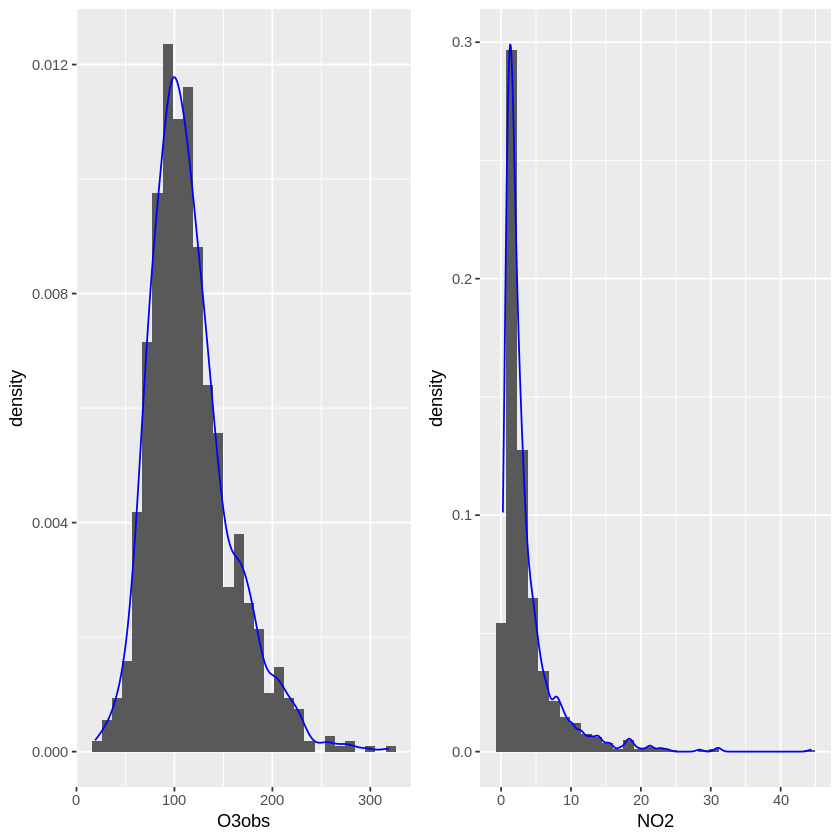

In [9]:
library(ggplot2)
library(gridExtra)
g1<-ggplot(ozone,aes(x=O3obs))+
  geom_histogram(aes(y=after_stat(density)))+
  geom_density(alpha=.2, col="blue")
g2<-ggplot(ozone,aes(x=NO2))+
  geom_histogram(aes(y=..density..))+
  geom_density(alpha=.2, col="blue")

grid.arrange(g1,g2,ncol=2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


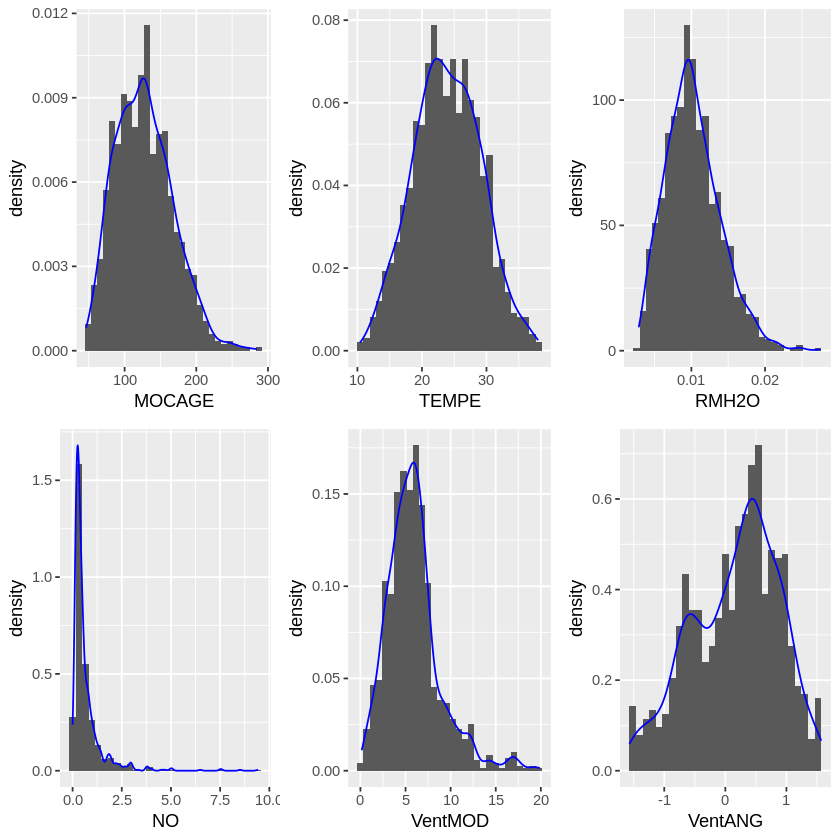

In [10]:
# Même chose pour les autres variables
g3<-ggplot(ozone,aes(x=MOCAGE))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue")
g4<-ggplot(ozone,aes(x=TEMPE))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue")
g5<-ggplot(ozone,aes(x=RMH2O))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue")
g6<-ggplot(ozone,aes(x=NO))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue")
g7<-ggplot(ozone,aes(x=VentMOD))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue")
g8<-ggplot(ozone,aes(x=VentANG))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue")

grid.arrange(g3,g4,g5,g6,g7,g8,ncol=3)
rm(g1,g2,g3,g4,g5,g6,g7,g8)

Reponse:

**La nature des différentes variables:**

- O3obs (Concentration d'ozone observée):  Variable quantitative continue
- NO2 (Concentration de dioxyde d'azote) : Variable quantitative continue
- MOCAGE (prévision de la pollution par modèle déterministe): Variable quantitative continue
- TEMPE (température prévue): Variable quantitative continue
- RMH2O (Rapport d'humidité) : Quantitative continue
- NO (Concentration de monoxyde d'azote) : Quantitative continue
- VentMOD (Force du vent) : Quantitative continue
- VentANG (Orientation du vent) : Quantitative continue

**Il est nécessaire d'en étudier la distribution. Notez la symétrie ou non de celles-ci.**

- O3obs : La distribution semble asymétrique, avec beaucoup de données concentrées sur les faibles valeurs et une longue queue vers la droite.

- NO2 : Cette distribution est aussi asymétrique et présente un schéma similaire, avec une forte concentration près de zéro et une longue queue à droite. Tout comme pour O3obs, il s'agit d'une distribution positivement asymétrique.

- MOCAGE : La distribution de cette variable est clairement asymétrique à droite. Il y a beaucoup de données autour des faibles valeurs, avec une longue queue qui s'étend vers la droite.

- TEMPE : Cette distribution est plutôt symétrique. Elle ressemble à une courbe normale(près de 23 tempe) mais est un peu aplatie de chaque côté.

- RMH2O:   ctte distribution est asymétrique à droite. Il y a beaucoup de valeurs autour des petites valeurs (près de 0,01) et une longue queue qui va vers des valeurs plus élevées.

- NO  La distribution de cette variable est très asymétrique à droite, avec une forte concentration de données près de 0.

- VentMOD : Cette variable semble un peu asymétrique à droite, avec une queue assez longue vers les grandes valeurs. Elle est plus symétrique que certaines autres variables, mais l'asymétrie est tout de même visible.

- VentANG : La distribution de VentANG a deux pics, un près de -0,5 et l'autre près de 0,5. Cela signifie qu'elle est plus complexe et montre deux comportements différents dans les données.



### Transformations de variables

Des transformations sont proposées pour rendre certaines distributions plus symétriques et ainsi plus "gaussiennes". C'est nécessaire pour certaines méthodes à venir de modélisation (linéaires), pas pour toutes (arbres).

In [11]:
ozone[, "SRMH2O"] <- sqrt(ozone[, "RMH2O"])
ozone[, "LNO2"] <- log(ozone[, "NO2"])
ozone[, "LNO"] <- log(ozone[, "NO"])

**Question** Vérifiez l'opportunité de ces transformations puis retirez les variables initiales

'data.frame':	1041 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 2 2 1 ...
 $ O3obs  : int  91 100 82 94 107 150 164 135 121 129 ...
 $ MOCAGE : num  93.2 104.6 103.6 94.8 99 ...
 $ TEMPE  : num  21.5 20.2 17.4 18.8 23.7 23.6 26.6 23.5 23.3 23.7 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD: num  9.5 8.01 9.38 9.46 7.88 ...
 $ VentANG: num  -0.643 -0.05 -0.128 -0.345 -0.418 ...
 $ SRMH2O : num  0.092 0.0939 0.0975 0.0925 0.0855 ...
 $ LNO2   : num  0.471 0.752 0.505 0.854 0.503 ...
 $ LNO    : num  -0.858 -0.633 -0.761 -0.355 -0.794 ...


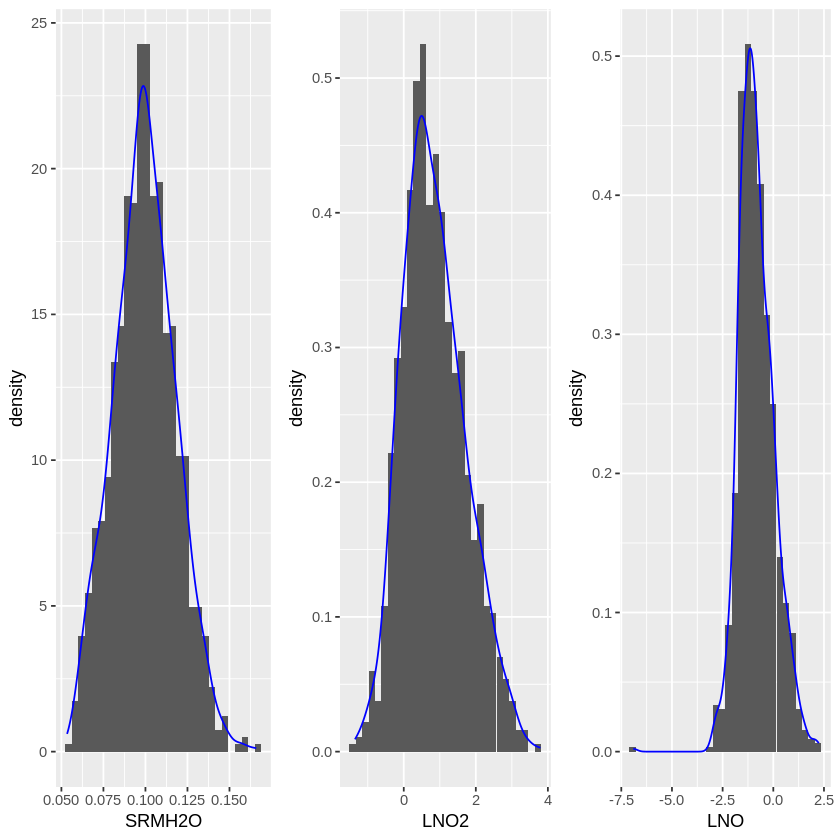

In [12]:
#Visualiser les distributions transformées
g4 <- ggplot(ozone, aes(x = SRMH2O)) + geom_histogram(aes(y = ..density..), bins = 30) + geom_density(alpha = .2, col = "blue")
g5 <- ggplot(ozone, aes(x = LNO2)) + geom_histogram(aes(y = ..density..), bins = 30) + geom_density(alpha = .2, col = "blue")
g6 <- ggplot(ozone, aes(x = LNO)) + geom_histogram(aes(y = ..density..), bins = 30) + geom_density(alpha = .2, col = "blue")
grid.arrange(g4, g5, g6, ncol = 3)

ozone <- ozone[, !(names(ozone) %in% c("RMH2O", "NO2", "NO"))]
str(ozone)

In [13]:

ozone <- ozone[, c(1:4, 8:13)]

ERROR: Error in `[.data.frame`(ozone, , c(1:4, 8:13)): undefined columns selected


**Reponse**

**Vérifiez l'opportunité de ces transformations puis retirez les variables initiales**

- RMH2O en SRMH2O : La transformation par racine carrée est utilisée car elle aide à réduire l'asymétrie positive des données et peut gérer les valeurs nulles.

- NO2 en LNO2 et NO en LNO : Les transformations logarithmiques aident à traiter les données qui ne sont pas symétriques à droite. Elles diminuent l'impact des valeurs très élevées et rendent les distributions plus normales mais, elle ne peut pas gérer les valeurs nulles ou négatives.

On construit maintenant la variable de dépassement de seuil `DepSeuil` pour obtenir le fichier qui sera effectivement utilisé.

In [14]:
ozone[, "DepSeuil"] <- as.factor(ozone[, "O3obs"] > 150)
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:199  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Als:222  
         Median :109.0   Median :125.6   Median :23.80   Cad:202  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Pla:208  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   Ram:210  
         Max.   :319.0   Max.   :284.7   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931  
      LNO           

### Corrélations des variables

**Question** Que dire sur les relations des variables 2 à 2 ?

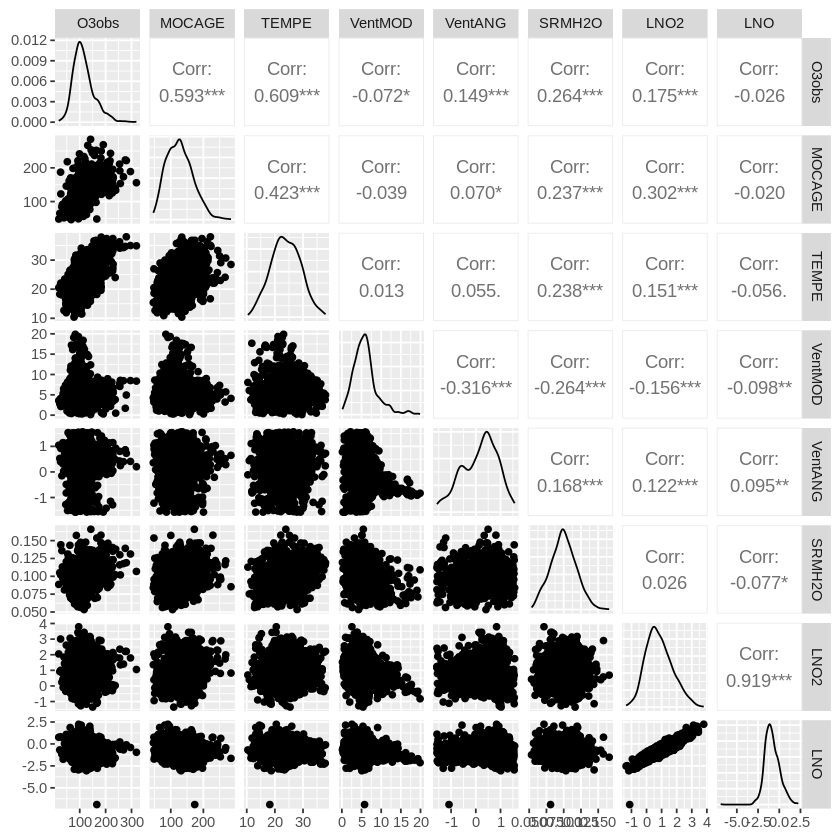

In [15]:
ggpairs(ozone[, c(2:4, 6:10)])

**Réponse**

**Que dire sur les relations des variables 2 à 2 ?**
-----------------------------
**Corrélations Positives**

- O3obs et MOCAGE (0.593*), O3obs et TEMPE (0.609*) montrent des corrélations positives importantes. Cela signifie que quand MOCAGE et la température augmentent, les niveaux d'ozone (O3obs) sont aussi plus élevés.

- LNO2 et LNO (0.919*) : NO2 et NO sont fortement liés. Cela veut dire que quand la concentration de dioxyde d'azote (NO2) augmente, celle du monoxyde d'azote (NO) augmente aussi.


**Corrélations Négatives :**

- VentMOD et VentANG (-0,312) ont une corrélation négative et significative. Cela veut dire que quand la force du vent (VentMOD) augmente, l'angle du vent (VentANG) diminue. Cela peut montrer qu'il y a des conditions météorologiques spécifiques.

**Corrélations Faibles :**

- Les relations entre LNO2 et RMH2O (0,026*) et entre VentANG et O3obs (0,149*) sont faibles.

- Les relations entre LNO2 et O3obs (0,175*) et entre VentANG et O3obs (0,149*) sont faibles. Cela signifie que ces variables influencent moins O3obs.





**Question** Complétez en visualisant les corrélations avec la fonction `corrplot()` (package `corrplot`). Quelle est la limite de ce type de diagnostic numérique : quel type de corrélation est mesuré ?

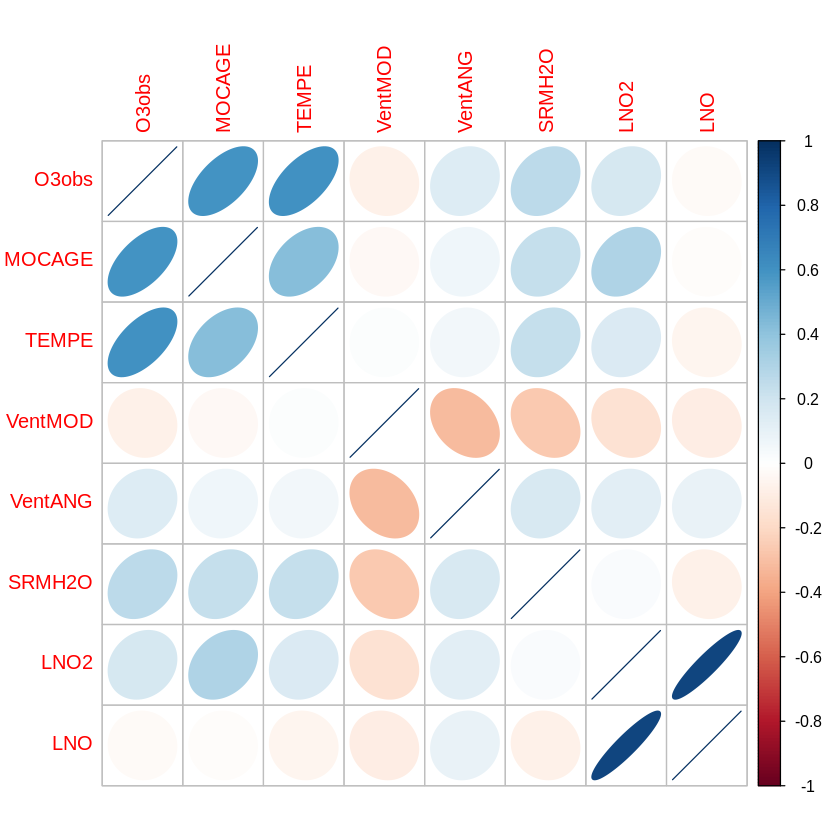

In [16]:

library(corrplot)
corrplot(cor(ozone[, c(2:4, 6:10)]),method="ellipse")

**Réponse**:

**Quelle est la limite de ce type de diagnostic numérique : quel type de corrélation est mesuré ?**


- Type de Corrélation Mesuré :Le type de corrélation mesurée est la corrélation de Pearson. Elle mesure la force et la direction de la relation linéaire entre deux variables continues. Elle varie de -1 à 1, où 1 indique une corrélation positive parfaite, 0 une absence de corrélation et -1 une corrélation négative parfaite.

- La limite de ce type de diagnostic numérique:

Tout d'abord, une des limites de ce type de diagnostic concerne les valeurs extrêmes. Ces valeurs inhabituelles peuvent fausser le coefficient de corrélation, ce qui le rend moins fiable pour montrer la vraie relation entre les variables. En effet, une seule valeur extrême peut changer complètement le résultat.

Ensuite, il est important de rappeler que corrélation ne veut pas dire lien de cause à effet. Même si deux variables sont fortement corrélées, cela ne veut pas dire que l'une cause l'autre. D'autres facteurs peuvent influencer les deux variables, ce qui rend l'interprétation des résultats plus compliquée.

par la suite Non-linéarité, elle ne capture pas les relations non linéaires entre les variables. Si deux variables ont une relation non linéaire forte, le coefficient de corrélation de Pearson peut être faible ou nul.





### Analyse en composantes principales

Les commandes suivantes permettent de réaliser une [analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf) (ACP) sur les seules variables quantitatives. Par ailleurs la variable à modéliser (O3obs, concentration observée) n'est pas utilisée.

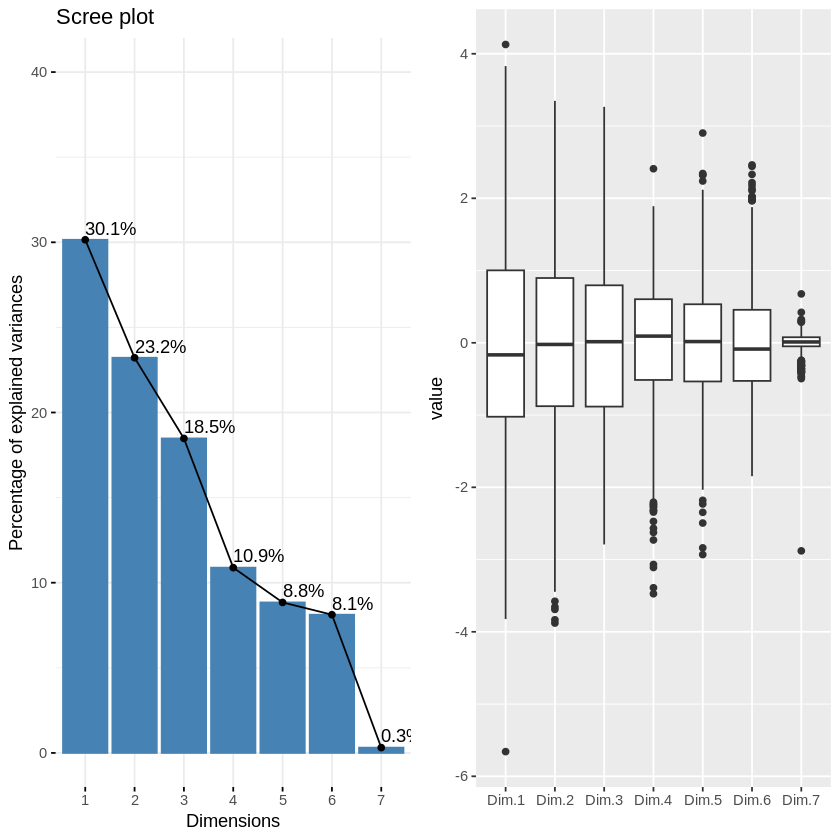

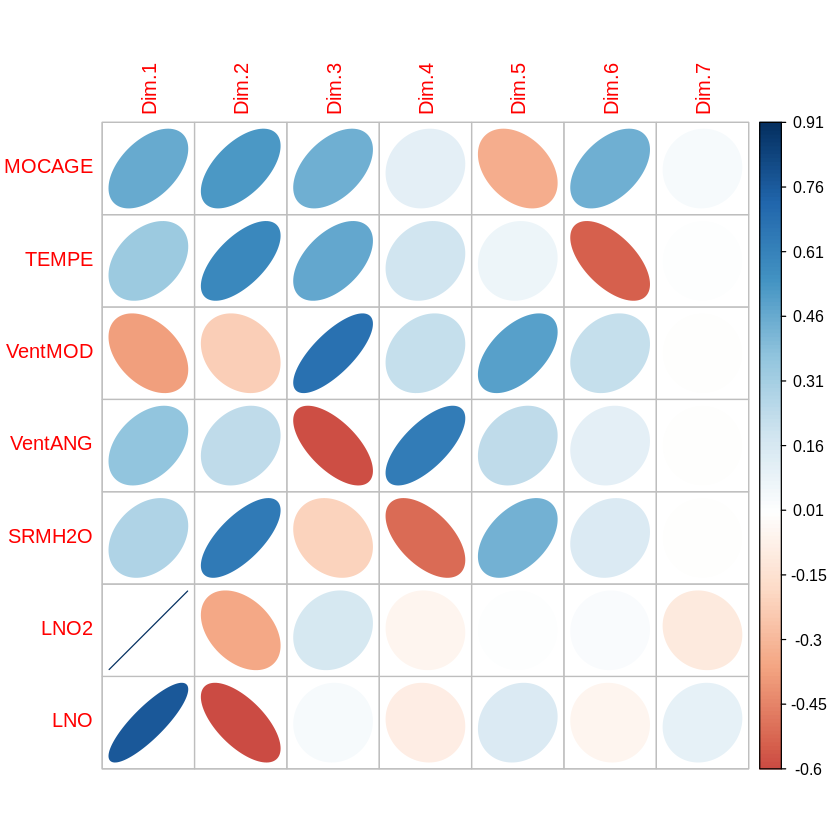

In [17]:
# ACP réduite
library(FactoMineR)
acp <- PCA(ozone[, c(11,2:4, 6:10)], scale.unit = TRUE,
           graph = FALSE, quali.sup = 1, quanti.sup = 2, ncp = 7)
# Décroissance des valeurs propres
library(factoextra)
g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))
library(reshape2)
g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)
#
library(corrplot)
corrplot(acp$var$cor, is.corr=FALSE,method="ellipse")

In [ ]:
help(PCA)

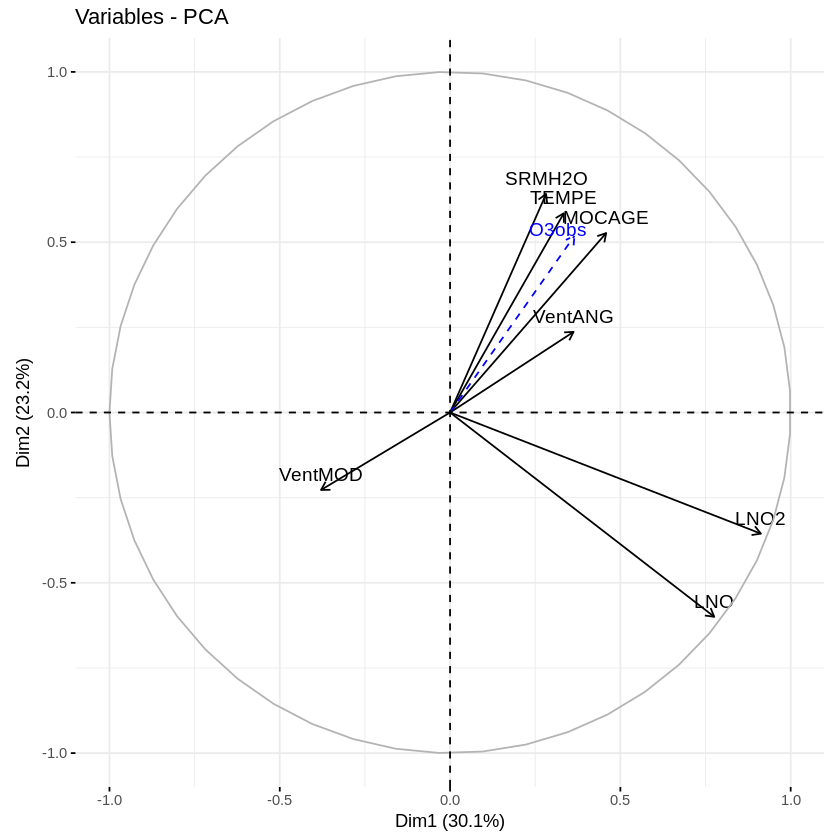

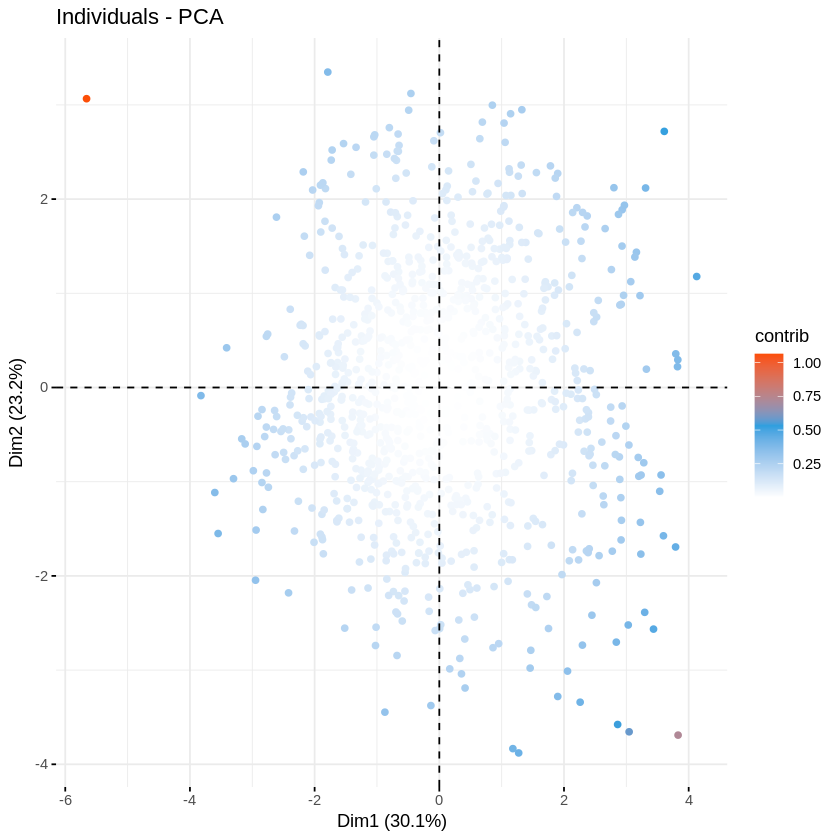

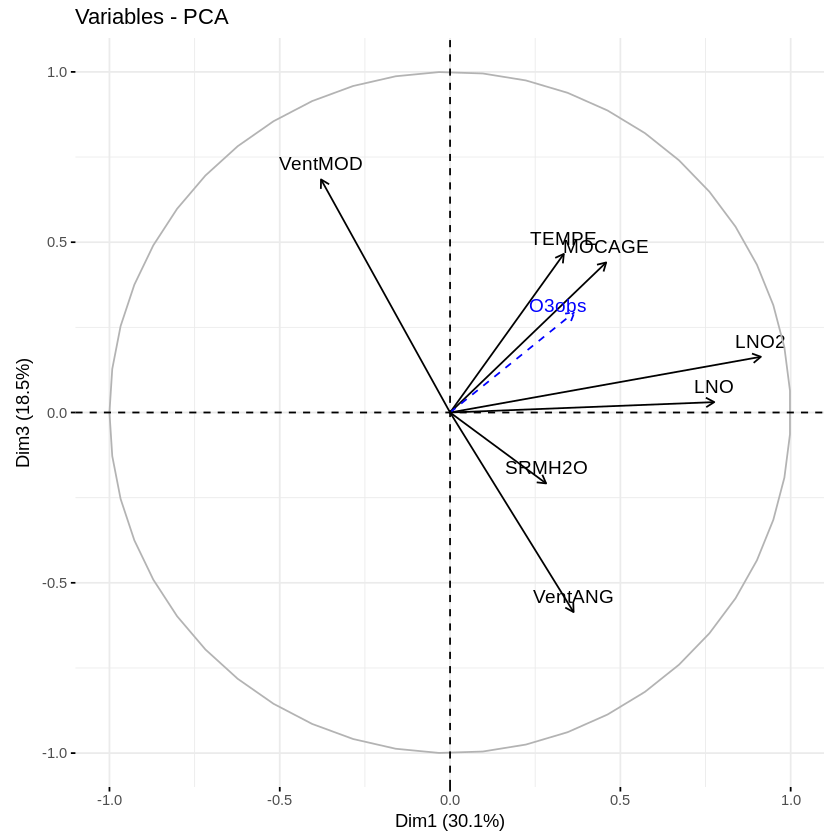

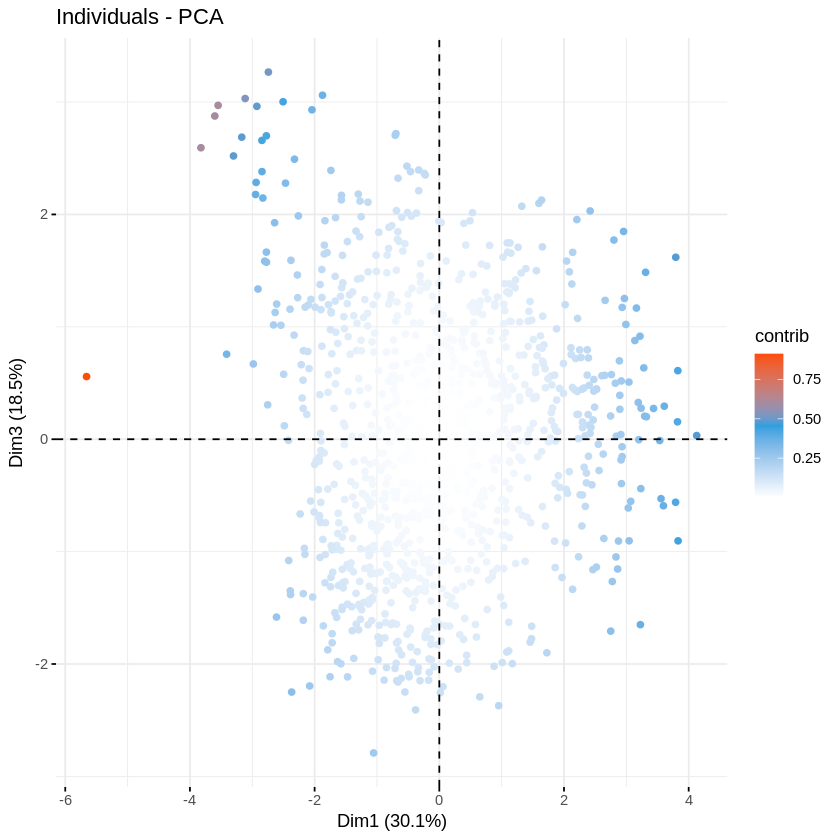

In [18]:
fviz_pca_var(acp)
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ))
fviz_pca_var(acp,axes=c(1,3))
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))

**Question** Que représentent ces différents graphiques?

**Question** Que dire du choix du nombre de dimensions, des valeurs atypiques?

**Question** Que dire de la structure de corrélation des variables ? Est-elle intuitive ?

**Rep :**

**Question Que représentent ces différents graphiques?**

- 1er Graphique des valeurs propres : Il montre le pourcentage de variance expliquée par chaque composante principale. Les barres descendent en hauteur de gauche à droite. Ce graphique aide à déterminer le nombre optimal de composantes principales à retenir pour une analyse en composantes principales (ACP).


- 2eme Box Plot : Le box plot montre la distribution des données pour chaque dimension (Dim1 à Dim7),
Chaque boîte représente la distribution des valeurs pour une dimension spécifique. La ligne médiane à l'intérieur de chaque boîte indique la médiane des données.Les extrémités des boîtes (quartiles) montrent la dispersion des données.

- 3eme Corrélation des variables : La matrice de corrélation est représentée par des ellipses de différentes couleurs et orientations. Chaque ellipse montre la corrélation entre deux variables. Les ellipses bleues indiquent des corrélations positives, tandis que les ellipses rouges indiquent des corrélations négatives. Ensuite Les ellipses étroites et inclinées indiquent des corrélations fortes (positives ou négatives), tandis que les ellipses plus larges et circulaires indiquent des corrélations faibles.


- 4eme cercle de corrélation : Obtenu grâce à une analyse en composantes principales (ACP) Les vecteurs comme "VentMOD", "VentANG", "LNO2", "LNO", "SRMH2O", "O3obs", montrent l'importance de chaque variable dans les deux premières composantes principales (Dim1 et Dim2). Plus une flèche (vecteur) est longue, plus la variable a d'importance. Si deux flèches sont proches, cela signifie que les variables sont positivement liées. Si elles vont dans des directions opposées, cela indique qu'elles sont négativement liées.

- 5eme graphique: il s'agit d'un nuage de points issu d'une analyse en composantes principales (ACP)



**Question Que dire du choix du nombre de dimensions, des valeurs atypiques?**


- Le choix du nombre de dimensions dépend du pourcentage de variance expliqué par chaque composante. Ici, Dim1 (30,1%), Dim2 (23,2%), dim3(18,5%) couvrent une bonne partie de l'information, donc ces 3 dimensions peuvent suffire.
En général, on retient les dimensions qui expliquent ensemble environ 70-80% de la variance totale.

- Pour les valeurs atypiques, on peut d'abord les repérer dans les boxplots. Les points qui se trouvent en dehors des "moustaches" des boxplots sont considérés comme atypiques. On observe quelques valeurs atypiques sur certaines composantes, notamment sur Dim1 et Dim7, et quelques autres légèrement éloignées pour Dim2, Dim4 et Dim5. Ensuite, dans le nuage de points des individus, certains points qui sont très éloignés des autres peuvent être considérés comme atypiques, surtout si un point est particulièrement éloigné du centre du nuage.


**Que dire de la structure de corrélation des variables ? Est-elle intuitive ?**

- **La structure de corrélation des variables :**

  Chaque ellipse montre la corrélation entre deux variables. Elles indiquent les relations entre différentes variables comme MOCAGE, TEMPE, VentANG, SRMH2O, LNO2, et LNO pour les dimensions Dim1 à Dim7.

  Les couleurs varient du bleu (corrélations positives) au rouge (corrélations négatives), et l'intensité de la couleur montre la force de la relation. Les ellipses étroites et inclinées indiquent des corrélations fortes.

  par exemple: Pour Dim1, les ellipses pour LNO2 et LNO sont bleu foncé, ce qui indique une forte corrélation. Quand les ellipses sont de couleur plus claire, cela signifie que la corrélation est plus faible.

  Pour les corrélations négatives, les ellipses sont rouges. Par exemple, dans Dim3, on voit une forte corrélation négative avec VentANG, représentée par une ellipse rouge et large.

- **Intuitivité de la Structure :**

 Cette représentation est intuitive car elle permet de visualiser rapidement les relations entre les variables sans avoir à lire des valeurs numériques. Les corrélations fortes et faibles sont immédiatement visibles grâce à la forme et à la couleur des ellipses.















Même graphe en coloriant selon le dépassement de seuil.

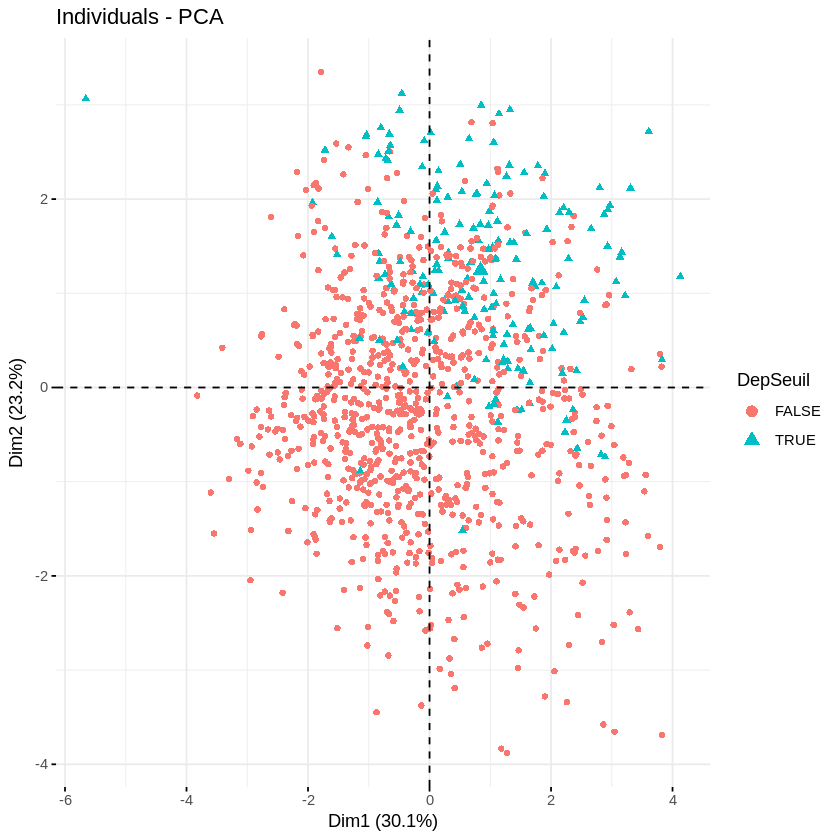

In [19]:
fviz_pca_ind(acp, label="none", habillage=1)

L'objectif est donc de définir une surface séparant les deux classes.

**Question** Une discrimination linéaire (hyperplan) semble-t-elle possible ?

**Réponse**

Question Une discrimination linéaire (hyperplan) semble-t-elle possible ?

- D'après le graphique des nuages de points, on peut observer deux groupes de
 points. L'un est rouge et représente 'FALSE', tandis que l'autre est bleu et représente 'TRUE'. Il est difficile de séparer parfaitement les deux classes avec une ligne droite. En effet, les points rouges et bleus se chevauchent beaucoup, ce qui montre qu'on ne peut pas les séparer facilement.

 Les nuages de points n'ont pas une forme claire qui permettrait de les séparer par une ligne droite, ils semblent se mélanger. De plus, aucune des deux dimensions ne réussit à séparer clairement les deux groupes, car les points des deux classes sont éparpillés le long de ces axes.

### Clustering

Ce n'est pas utile ici mais une classification non supervisée est facile à obtenir. Par exemple en 2 classes, par l'algorithme des K-means. Donne-t-elle la même information ?

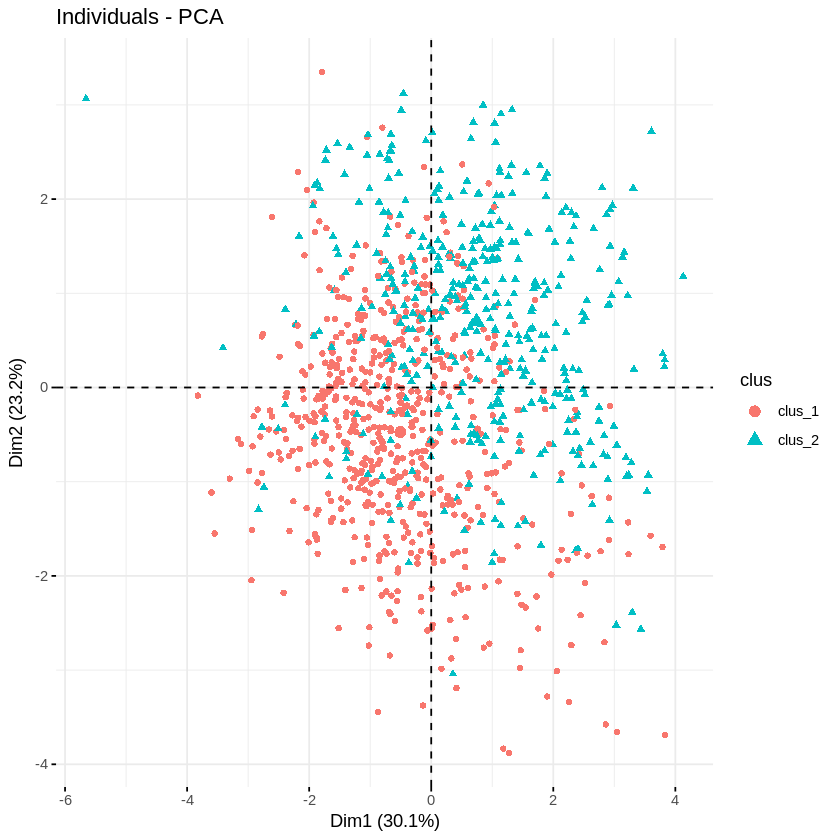

In [20]:
km.ozone <- kmeans(ozone[, c(3:4, 6:10)], centers = 2)
# Représentation dans les coordonnées de l'acp
acp2 <- PCA(cbind(clus = as.factor(km.ozone$cluster),
          ozone[, c(11, 3:4, 6:10)]), scale.unit = TRUE,
          graph = FALSE, quali.sup = 1:2, ncp = 7)
fviz_pca_ind(acp2, label="none", habillage="clus")

## Protocole de comparaison

### Stratégie

La recherche  d'une meilleure méthode de prévision suit le protocole suivant.

1. Étapes descriptives préliminaires uni- et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données.
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par [*validation croisée*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf):
    - Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
    - variables et méthode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de régression ou de classification;
    - architecture (nombre de neurones, pénalisation) du perceptron;
    - algorithme d'agrégation,
    - noyau et pénalisation des SVMs.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.



### Remarques

* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test, afin de réduire la variance (moyenne) des estimations des erreurs de prévision.

**Question** Comment appelle-t-on cette procédure spécifique de validation croisée ?

* *Attention* : ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test!
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, entropie, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...

**Réponse:**


**Question Comment appelle-t-on cette procédure spécifique de validation croisée ?**


- Cette méthode de validation croisée s'appelle validation croisée k-fold. Elle
 consiste à diviser les données en k sous-groupes. Ensuite, on utilise chaque sous-groupe une fois comme test, tandis que les autres servent à entraîner le modèle.







### Extraction des échantillons

Les commandes ci-dessous réalisent l'extraction du sous-ensemble des données d'apprentissage et de test.

Utilisez trois chiffres au hasard, et **remplacez** "111" ci-dessous, comme initialisation du générateur de nombres aléatoires. Attention, chaque participant tire un échantillon différent ; il est donc "normal" de ne pas obtenir les mêmes modèles, les mêmes résultats!

In [21]:
set.seed(123) # initialisation du générateur
# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(ozone) # nombre de lignes dans les données
nvar <- ncol(ozone) # nombre de colonnes
# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio)
# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi)


Construction des échantillons pour la régression: prévision de la concentration en ozone.

In [22]:
# construction de l'échantillon d'apprentissage
datappr <- ozone[appri, -11]
# construction de l'échantillon test
datestr <- ozone[testi, -11]
# vérification
str(datappr)
str(datestr)
#summary(datappr)

'data.frame':	832 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 2 2 1 1 ...
 $ O3obs  : int  91 100 82 94 150 164 135 121 129 118 ...
 $ MOCAGE : num  93.2 104.6 103.6 94.8 114.3 ...
 $ TEMPE  : num  21.5 20.2 17.4 18.8 23.6 26.6 23.5 23.3 23.7 22.2 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD: num  9.5 8.01 9.38 9.46 6.31 ...
 $ VentANG: num  -0.6435 -0.05 -0.1283 -0.3452 0.0634 ...
 $ SRMH2O : num  0.092 0.0939 0.0975 0.0925 0.1087 ...
 $ LNO2   : num  0.471 0.752 0.505 0.854 1.671 ...
 $ LNO    : num  -0.858 -0.633 -0.761 -0.355 0.295 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 1 1 2 1 1 2 1 2 1 1 ...
 $ O3obs  : int  57 102 26 101 105 183 138 52 83 98 ...
 $ MOCAGE : num  105 114 187 112 148 ...
 $ TEMPE  : num  19.4 30.2 21.7 27.9 25.9 20.8 25 23.1 15.8 21.6 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 2 3 1 3 1 4 5 3 5 4 ...
 $ VentMOD: num  4.52 5.17 4

Construction des échantillons pour la discrimination: prévision de dépassement.

In [23]:
# construction de l'échantillon d'apprentissage
datappq <- ozone[appri,-2]
# construction de l'échantillon test
datestq <- ozone[testi,-2]

# vérification
str(datappq)
str(datestq)
#summary(datappq)

'data.frame':	832 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 2 2 1 1 ...
 $ MOCAGE  : num  93.2 104.6 103.6 94.8 114.3 ...
 $ TEMPE   : num  21.5 20.2 17.4 18.8 23.6 26.6 23.5 23.3 23.7 22.2 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD : num  9.5 8.01 9.38 9.46 6.31 ...
 $ VentANG : num  -0.6435 -0.05 -0.1283 -0.3452 0.0634 ...
 $ SRMH2O  : num  0.092 0.0939 0.0975 0.0925 0.1087 ...
 $ LNO2    : num  0.471 0.752 0.505 0.854 1.671 ...
 $ LNO     : num  -0.858 -0.633 -0.761 -0.355 0.295 ...
 $ DepSeuil: Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 2 1 1 1 1 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 1 1 2 1 1 2 1 2 1 1 ...
 $ MOCAGE  : num  105 114 187 112 148 ...
 $ TEMPE   : num  19.4 30.2 21.7 27.9 25.9 20.8 25 23.1 15.8 21.6 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 2 3 1 3 1 4 5 3 5 4 ...
 $ VentMOD : num  4.52 5.17 4.12 9.55 4 ...
 $ VentANG : 

**Remarque** : Nous avons ici "manuellement" fait la construction des échantillons à des fins pédagogiques. En pratique, on peut utiliser des fonctions de R qui font ce travail, en particulier la fonction `createDataPartition` de la librairie `caret`.

Enfin, avant de passer aux différents algorithmes, définissons une fonction traçant le graphe des résidus avec des couleurs et des échelles fixes sur les axes.

In [24]:
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+xlim(0, 250)+ylim(-150, 150)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

## [Prévision par modèle linéaire Gaussien](http://wikistat.fr/pdf/st-m-app-select.pdf)

Le premier modèle à tester est un simple modèle linéaire Gaussien mais, comme certaines variables sont qualitatives, il s'agit d'une analyse de covariance. D'autre part, on s'intéresse à savoir si des interactions sont à prendre en compte. Le modèle devient alors polynomial d'ordre 2 ou quadratique.

### Modèle linéaire

#### Sans sélection de variables

Le modèle linéaire intégre ici des variables qualitatives; c'est dans ce cas une *analyse de covariance*  estimée par la fonction `aov` mieux adaptée à ce modèle.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


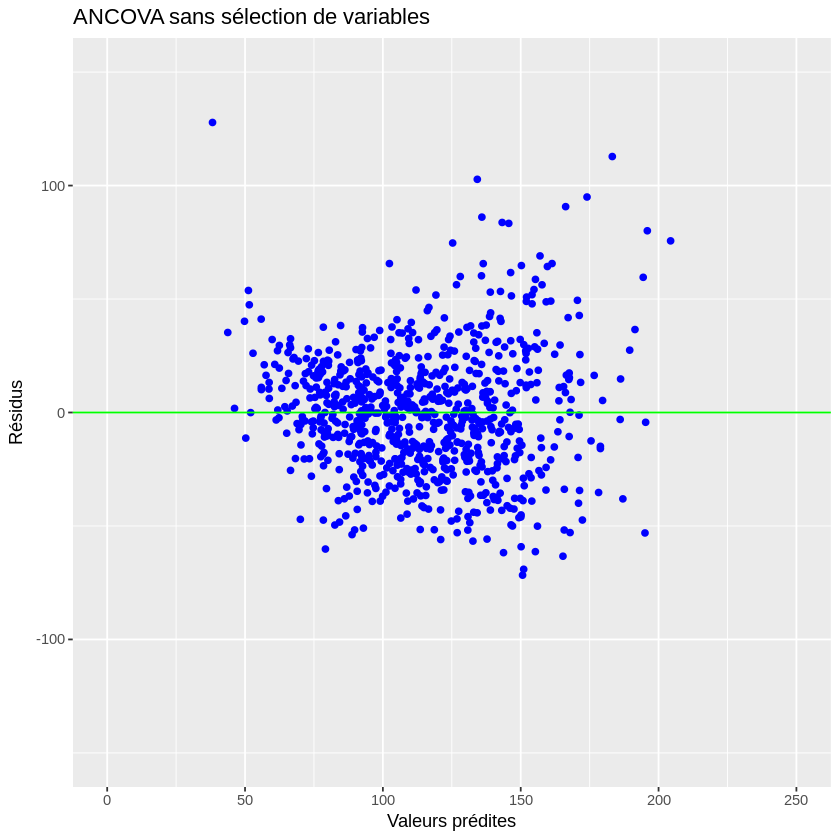

In [25]:
# estimation du modèle sans interaction
reg.lm <-aov(O3obs ~ . , data = datappr)
# Extraction des résidus et des valeurs ajustées de ce modèle
res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values
# Graphe des résidus.
gplot.res(fit.lm,res.lm,"ANCOVA sans sélection de variables")

**Question** Que dire de la distribution de ces résidus ?

**Question** La forme du nuage renseigne sur les hypothèses de linéarité du modèle et d'homoscédasticité. Que dire de la validité de ce modèle ?

Appréciez néanmoins sa significativité par la commande suivante.


**Réponse:**

**Question Que dire de la distribution de ces résidus**

- La distribution des résidus semble indiquer une homoscédasticité, car la
 majorité des résidus sont bien centrés autour de la ligne verte à zéro. Cela montre que les erreurs de prédiction sont globalement en moyenne. La dispersion des résidus semble assez stable, même si certains points s'éloignent beaucoup des autres.


**Question La forme du nuage renseigne sur les hypothèses de linéarité du modèle et d'homoscédasticité. Que dire de la validité de ce modèle ?**

- **les hypothèses de linéarité**: La forme du nuage de points montre que le modèle semble respecter l'hypothèse de linéarité. En regardant le graphe des résidus par rapport aux valeurs prédites, on ne voit pas de schéma particulier, comme une courbe qui monte ou descend. Dans un bon modèle linéaire, les résidus devraient être dispersés de façon aléatoire autour de la ligne zéro, ce qui semble être le cas ici.

- **Homoscédasticité**: la dispersion des résidus semble relativement constante par rapport aux valeurs prédites.


  On peut donc en déduire qu'il respecte les principales hypothèses de linéarité et d'homoscédasticité.
  

In [26]:
summary(reg.lm)

             Df Sum Sq Mean Sq F value   Pr(>F)    
JOUR          1    964     964   1.243 0.265189    
MOCAGE        1 468441  468441 603.952  < 2e-16 ***
TEMPE         1 218521  218521 281.735  < 2e-16 ***
STATION       4   5100    1275   1.644 0.161242    
VentMOD       1  10574   10574  13.633 0.000237 ***
VentANG       1  12105   12105  15.607 8.47e-05 ***
SRMH2O        1   2815    2815   3.630 0.057114 .  
LNO2          1   1550    1550   1.999 0.157807    
LNO           1   9310    9310  12.003 0.000559 ***
Residuals   819 635238     776                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [27]:
coef(reg.lm)

(Intercept)       JOUR1      MOCAGE       TEMPE  STATIONAls  STATIONCad 
-15.1954608  -0.2322255   0.3978666   4.0207792  -0.1284525   9.3467447 
 STATIONPla  STATIONRam     VentMOD     VentANG      SRMH2O        LNO2 
 14.9083328   2.6748795  -1.1297309   4.9959620 117.2695826 -15.4707914 
        LNO 
 17.1237425

**Question** Ce premier modèle est comparé avec celui de la seule prévision déterministe MOCAGE. Qu'en conclure?

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


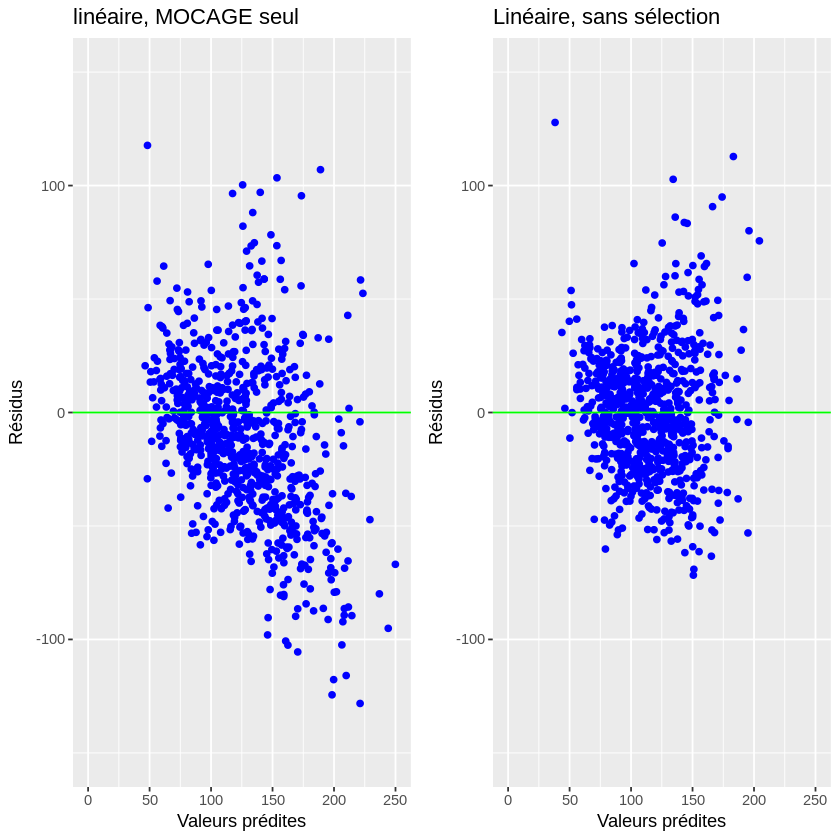

In [28]:
# Graphe des résidus du modèle déterministe MOCAGE
g1<-gplot.res(datappr[, "MOCAGE"],datappr[, "O3obs"]-datappr[, "MOCAGE"], "linéaire, MOCAGE seul")

g2<-gplot.res(fit.lm, res.lm, "Linéaire, sans sélection")
grid.arrange(g1,g2,ncol=2)

**Réponse:**

**Question Ce premier modèle est comparé avec celui de la seule prévision déterministe MOCAGE. Qu'en conclure?**

- Modèle linéaire avec MOCAGE seul : La plupart des résidus sont négatifs, ce
 qui signifie que le modèle prédit souvent des valeurs plus faibles que celles qui ont été observées et aussi le modèle ne suit pas toujours bien les règles de linéarité et d'homoscédasticité.

- Modèle linéaire sans sélection de variables: Les résidus sont mieux dispersés autour de zéro ce qui montre que les prévisions sont plus justes et le modèle  respecte mieux les règles de linéarité et d'homoscédasticité.

- En conclusion, le modèle linéaire sans sélection de variables est meilleur que le modèle MOCAGE seul. Il a des résidus plus équilibrés et respecte mieux les règles de base ce qui en fait un modèle plus fiable pour faire des prévisions.






#### Sélection de variable par régularisation L1 (LASSO)

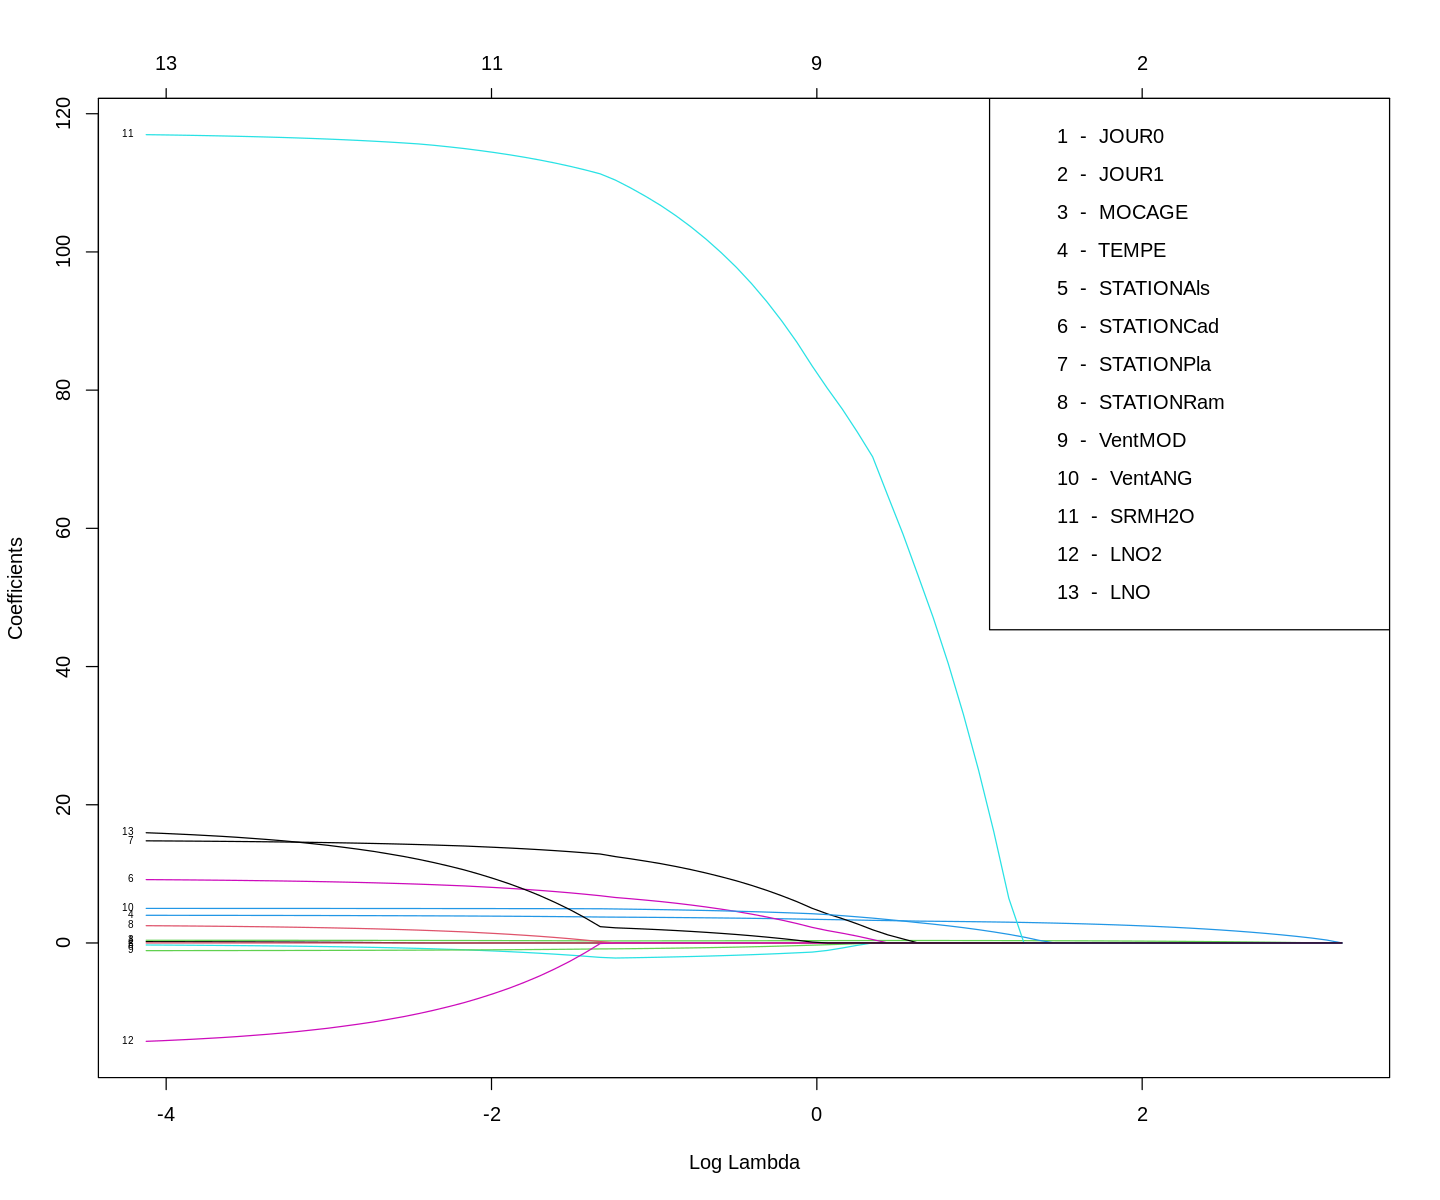

In [29]:
library(glmnet)
# avec des variables quantitatives seulement
reg.lasso.quanti <- glmnet(y = datappr[, 2],
                           x = as.matrix(datappr[, -c(1, 2, 5)]))
# avec toutes les variables, créer d'abord la matrice d'expériences
# avec 'model.matrix' (penser à retirer l'intercept du modèle)
x.mat <- model.matrix(O3obs ~ . - 1, data = datappr)
reg.lasso <- glmnet(y = datappr$O3obs, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright",
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

**Question** Que fait la commande model.matrix ? Comment sont gérées les variables catégorielles ?

**Réponse :**

**Question Que fait la commande model.matrix ? Comment sont gérées les variables catégorielles ?**

- La commande **model.matrix** prend un tableau de données (dataframe) et le transforme en une matrice numérique qu’on peut utiliser pour un modèle de régression. Pour les variables catégorielles, comme "STATION", elle les change en variables binaires. Cela signifie que chaque catégorie est montrée dans une colonne différente. Cette transformation ressemble à un tableau où chaque ligne représente une observation et chaque colonne une variable.

In [30]:
#help(model.matrix)
head(x.mat)

,JOUR0,JOUR1,MOCAGE,TEMPE,STATIONAls,STATIONCad,STATIONPla,STATIONRam,VentMOD,VentANG,SRMH2O,LNO2,LNO
1,0,1,93.2,21.5,0,0,0,0,9.5000,-0.64350,0.09203260,0.4712528,-0.8580218
2,0,1,104.6,20.2,0,0,0,0,8.0100,-0.04996,0.09386160,0.7518877,-0.6329933
3,1,0,103.6,17.4,0,0,0,0,9.3771,-0.12832,0.09751923,0.5050087,-0.7614260
4,1,0,94.8,18.8,0,0,0,0,9.4578,-0.34516,0.09246621,0.8544153,-0.3552474
6,1,0,114.3,23.6,0,0,0,0,6.3127,0.06341,0.10871982,1.6707211,0.2949059
7,1,0,127.7,26.6,0,0,0,0,4.8042,0.04164,0.09679876,1.0441561,-0.5978370


**Question** Que représentent les courbes ci-dessus, appelées "chemins de régularisation"?


**Réponse:**

**Question Que représentent les courbes ci-dessus, appelées "chemins de régularisation"?**

- Les courbes appelées "chemins de régularisation" montrent comment les
 coefficients d'un modèle de régression changent en fonction du niveau de régularisation. Elles aident à identifier les variables importantes dans le modèle. Si le coefficient d'une variable reste élevé même avec beaucoup de régularisation, cela signifie qu'elle est importante pour le modèle, comme la variable 11 - SRMH20. En revanche, si le coefficient d'une variable tend vers 0, cela signifie qu'elle est moins importante comme la variable 1 ou 2.

 Ces courbes nous aident donc à comprendre comment la régularisation affecte le modèle et à savoir quelles variables sont les plus significatives.

On s'intéresse ensuite au choix du paramètre de régularisation par validation croisée:

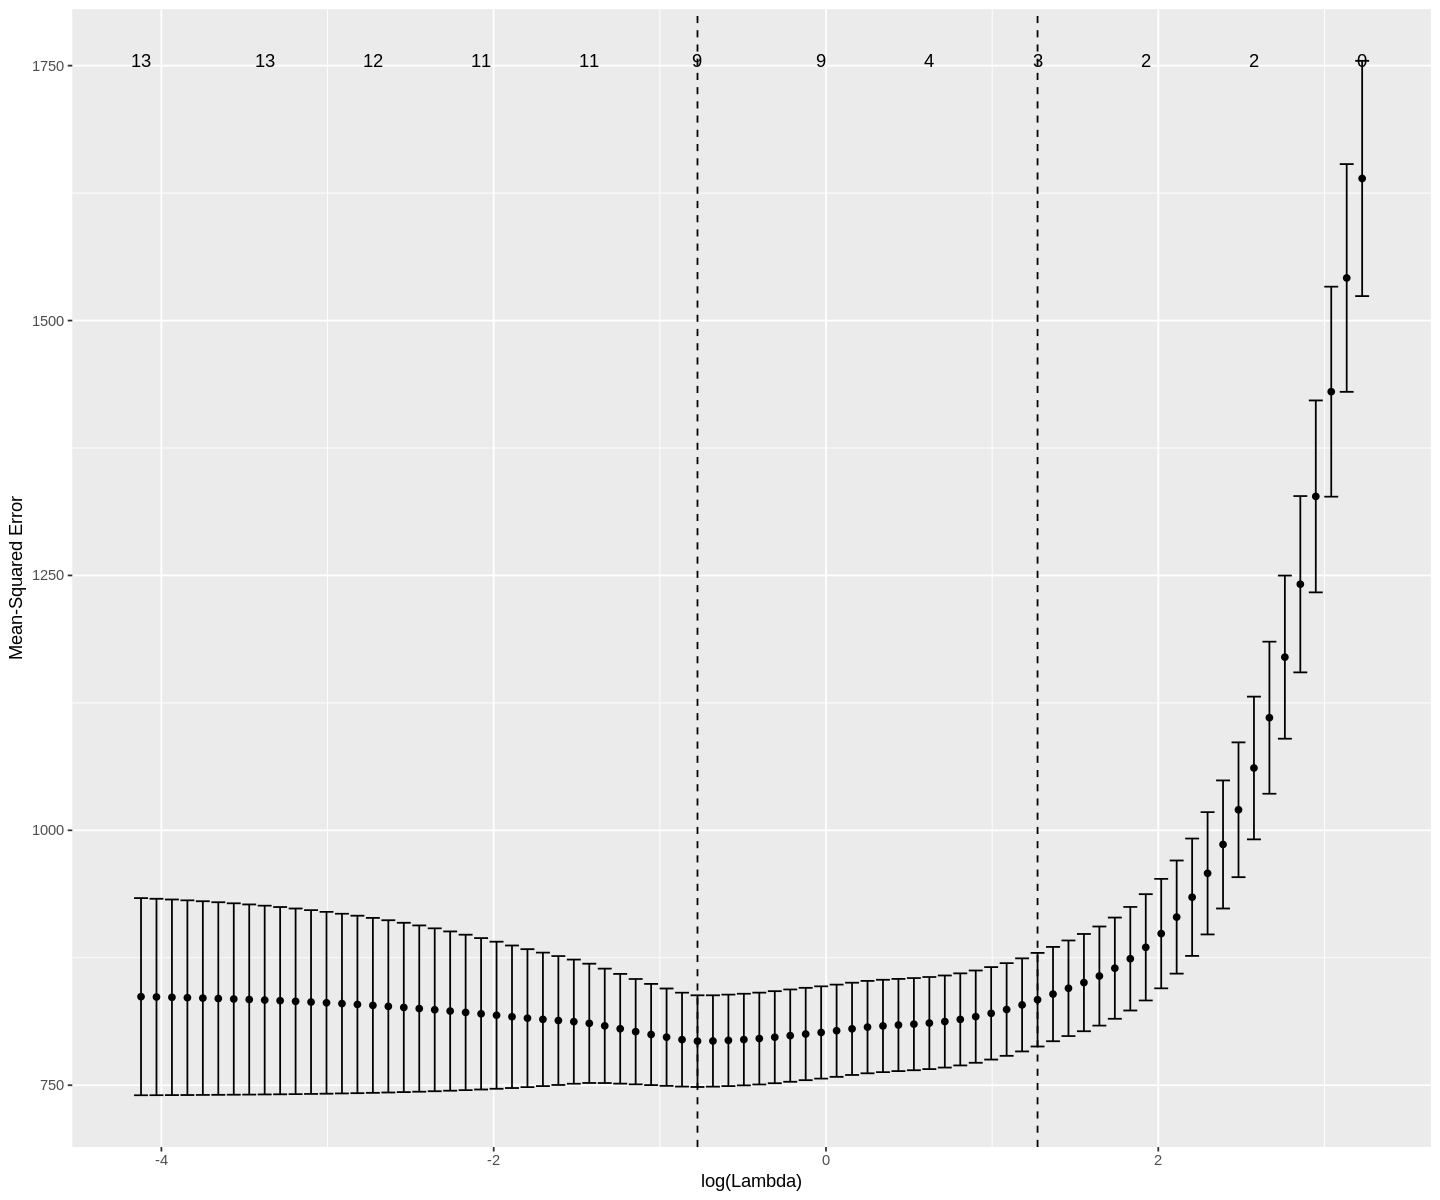

In [31]:
reg.lasso.cv <- cv.glmnet(y = datappr[, 2], x = x.mat)
#plot(reg.lasso.cv)
autoplot(reg.lasso.cv)

In [33]:
library(glmnet)
#help(cv.glmnet)

**Question** Que représente les points gras ? Et la bande qui est autour ?

**Question** Comment sont obtenues les valeurs de log(lambda) correspondant aux lignes verticales en pointillé ?

**Réponse:**

**Question Que représente les points gras ? Et la bande qui est autour ?**
- Les points en gras sur le graphique montrent les valeurs de l'erreur
 quadratique moyenne (MSE) pour différents niveaux de régularisation. L'axe des x représente le logarithme de. La bande autour de ces points indique l'intervalle de confiance pour chaque valeur de MSE.

**Question Comment sont obtenues les valeurs de log(lambda) correspondant aux lignes verticales en pointillé ?**

- Les valeurs de log(λ) correspondant aux lignes verticales en pointillé sont
 obtenues grâce à la validation croisée appliquée au modèle de régularisation, en particulier le Lasso, via la fonction cv.glmnet().

  Ces valeurs indiquent les niveaux de λ testés qui minimisent l’erreur du modèle, aidant ainsi à choisir la meilleure régularisation. Cela correspond aux points où le modèle atteint soit l'erreur la plus basse, soit un bon équilibre pour éviter qu'il ne devienne trop complexe, tout en gardant de bonnes performances.



In [34]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 3.573"

14 x 1 sparse Matrix of class "dgCMatrix"
                   s1
(Intercept) 1.5611446
JOUR0       .        
JOUR1       .        
MOCAGE      0.3329366
TEMPE       2.9684488
STATIONAls  .        
STATIONCad  .        
STATIONPla  .        
STATIONRam  .        
VentMOD     .        
VentANG     0.8430936
SRMH2O      .        
LNO2        .        
LNO         .        

**Question** Combien restent-ils de coefficients non nuls. Vérifiez sur les chemins de régularisation.

**Question** Même question en choisissant l'autre valeur de lambda retenue par glmnet, i.e. `reg.lasso.cv$lambda.min`\

**Réponse:**

**Question Combien restent-ils de coefficients non nuls. Vérifiez sur les chemins de régularisation.**

- Après la régularisation, on observe 4 coefficients non nuls : MOCAGE, TEMPE, VentANG, ainsi que l'intercept. Les autres variables ont été éliminées, car leurs coefficients sont nuls (indiqués par un point ".").

**Question Même question en choisissant l'autre valeur de lambda retenue par glmnet, i.e. reg.lasso.cv$lambda.min**

- Pour la valeur de λ correspondant à lambda.min, elle est 0.461. Après la régularisation, on constate qu'il y a 10 coefficients non nuls. Les autres variables ont été éliminées car leurs coefficients sont nuls (indiqués par un point ".").





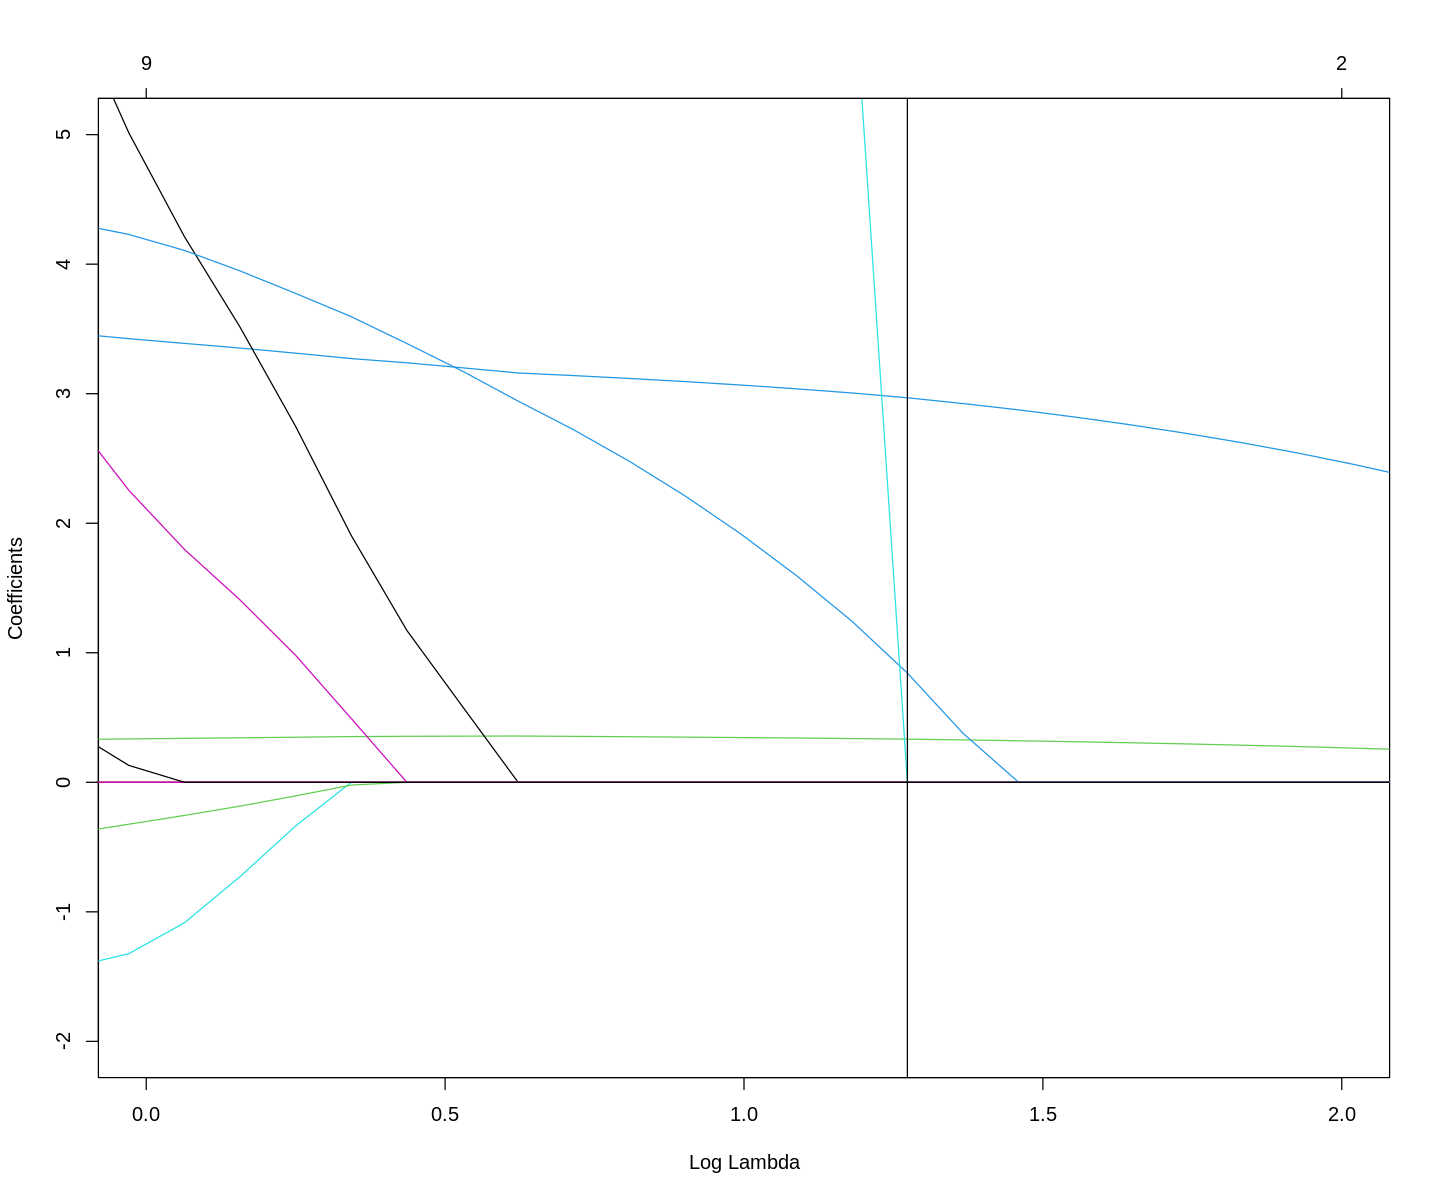

In [35]:
plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(0,2),ylim=c(-2,5))
abline(v=log(reg.lasso.cv$lambda.1se),col="black")

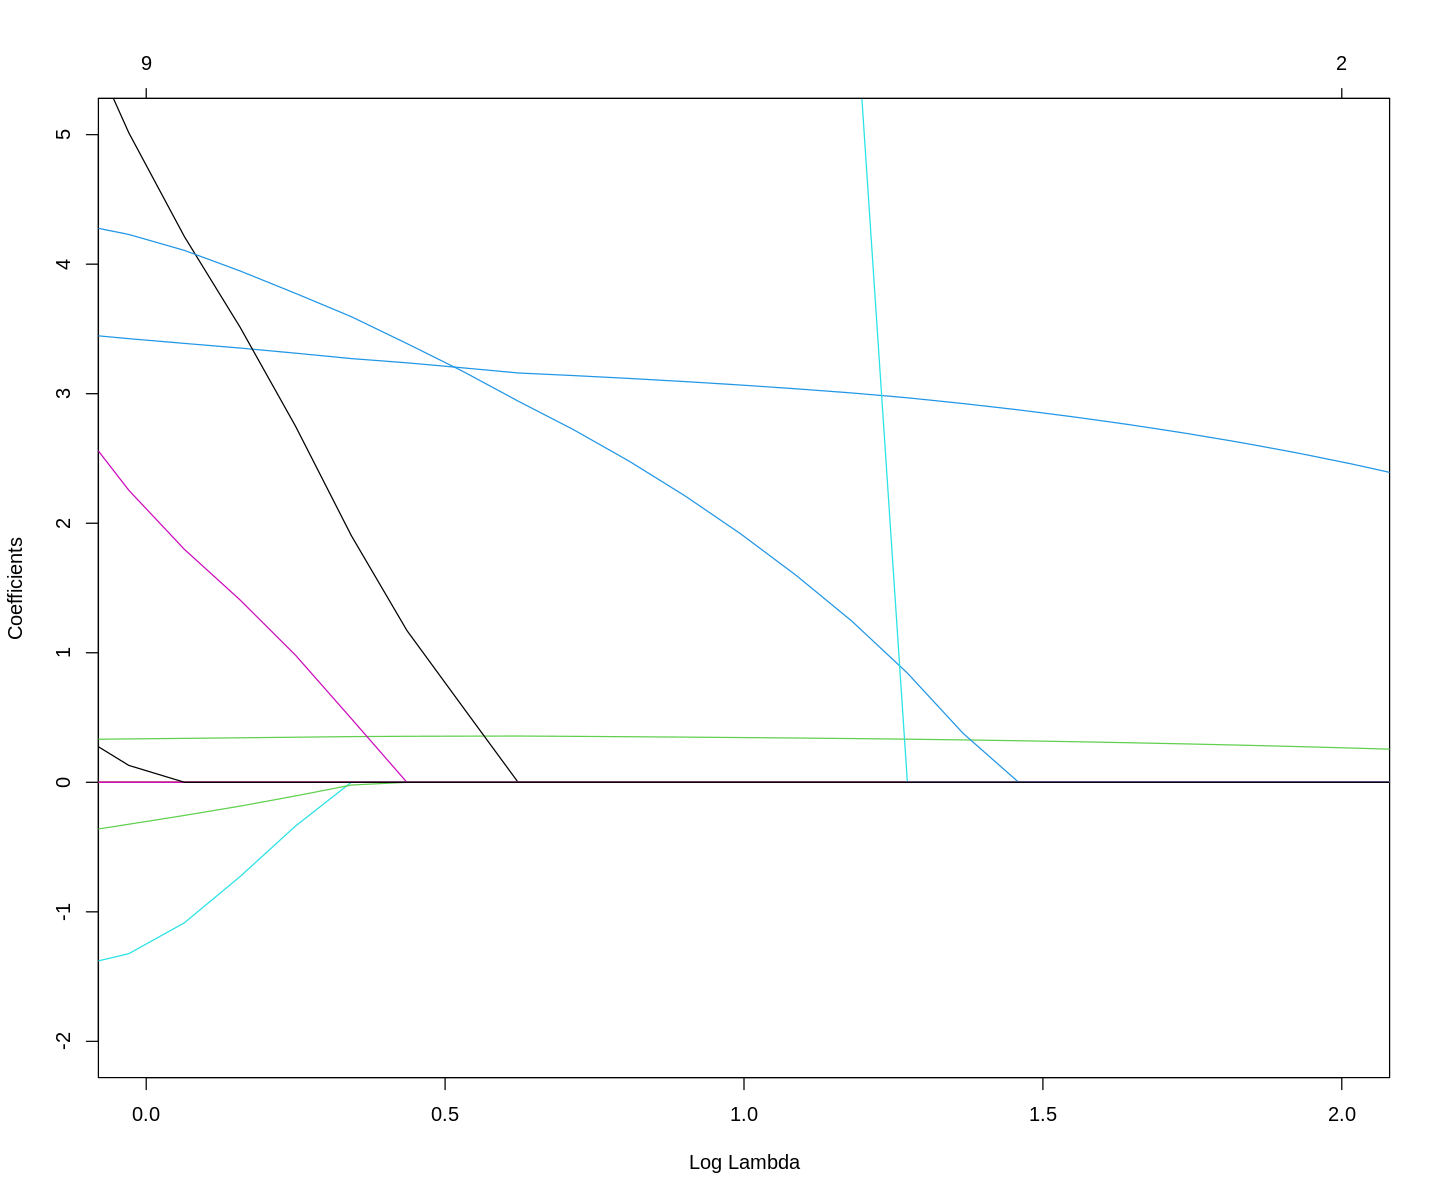

In [36]:
plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(0,2),ylim=c(-2,5))
abline(v=log(reg.lasso.cv$lambda.min),col="black")

[1] "CV estimate of lambda : 0.461"

14 x 1 sparse Matrix of class "dgCMatrix"
                     s1
(Intercept) -19.6479845
JOUR0         .        
JOUR1         .        
MOCAGE        0.3072467
TEMPE         3.6587258
STATIONAls   -1.9623652
STATIONCad    5.4905714
STATIONPla   10.6115081
STATIONRam    .        
VentMOD      -0.7172606
VentANG       4.7444935
SRMH2O      103.6163971
LNO2          .        
LNO           1.6725730

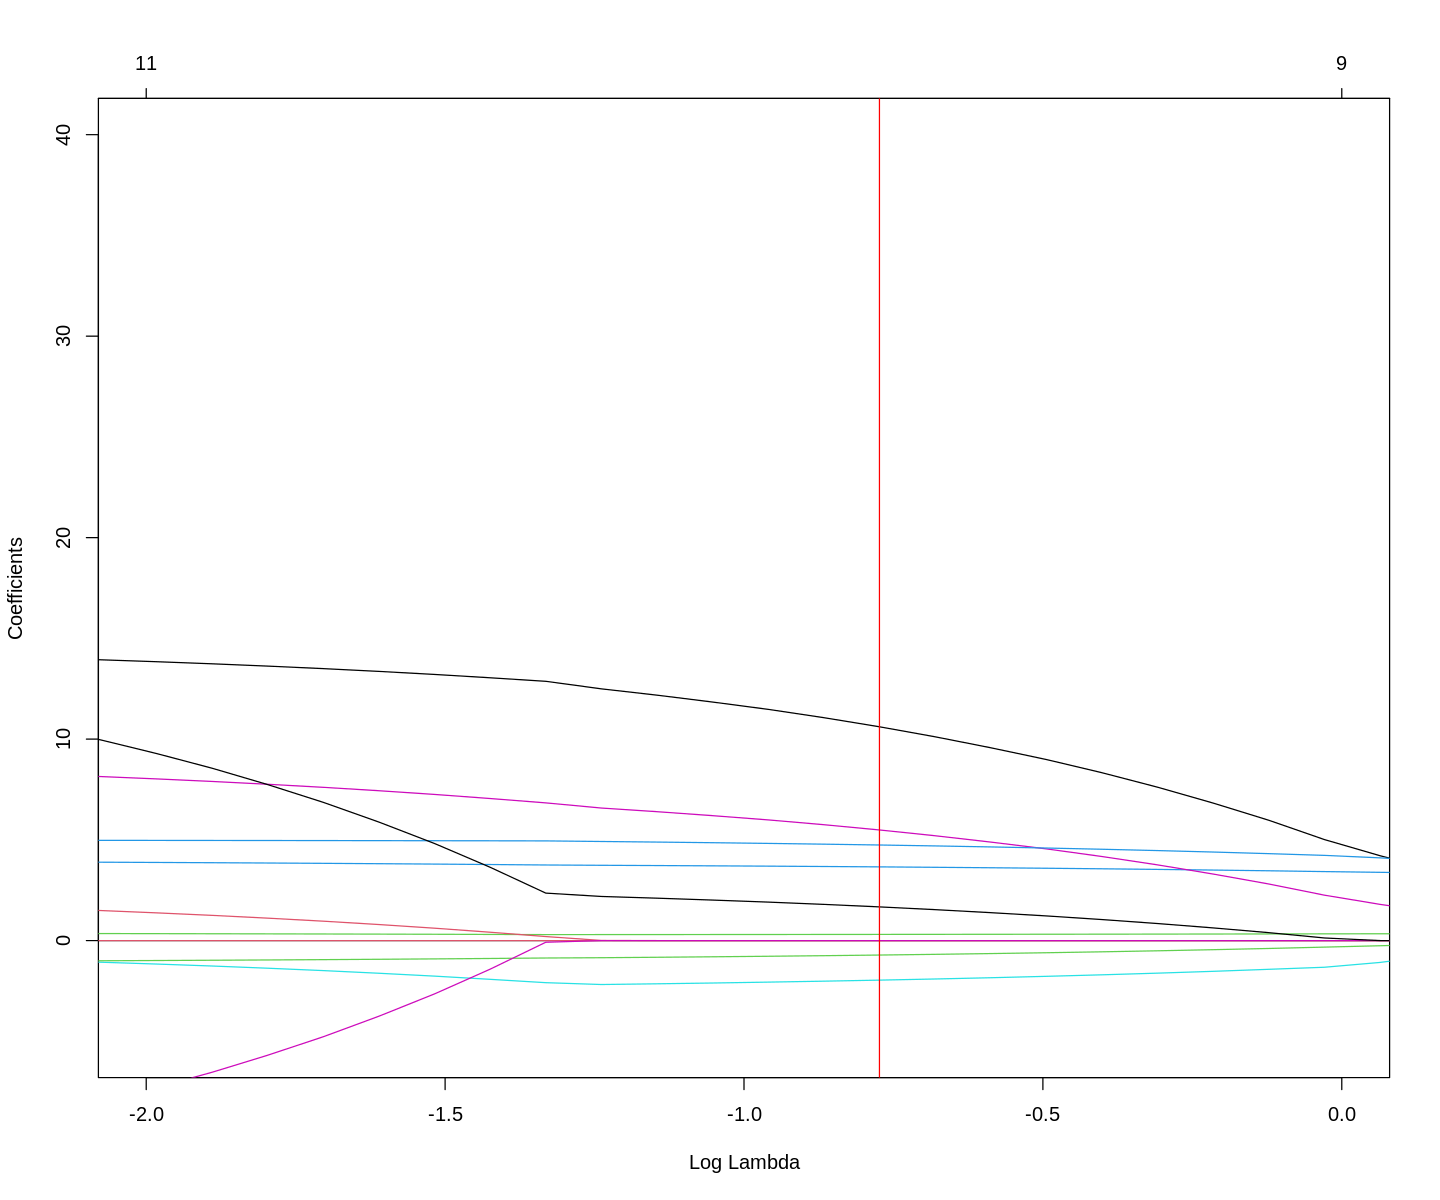

In [37]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.min, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.min")

plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(-2,0),ylim=c(-5,40))
abline(v=log(reg.lasso.cv$lambda.min),col="red")

On trace ensuite les résidus en fonction des valeurs prédites.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


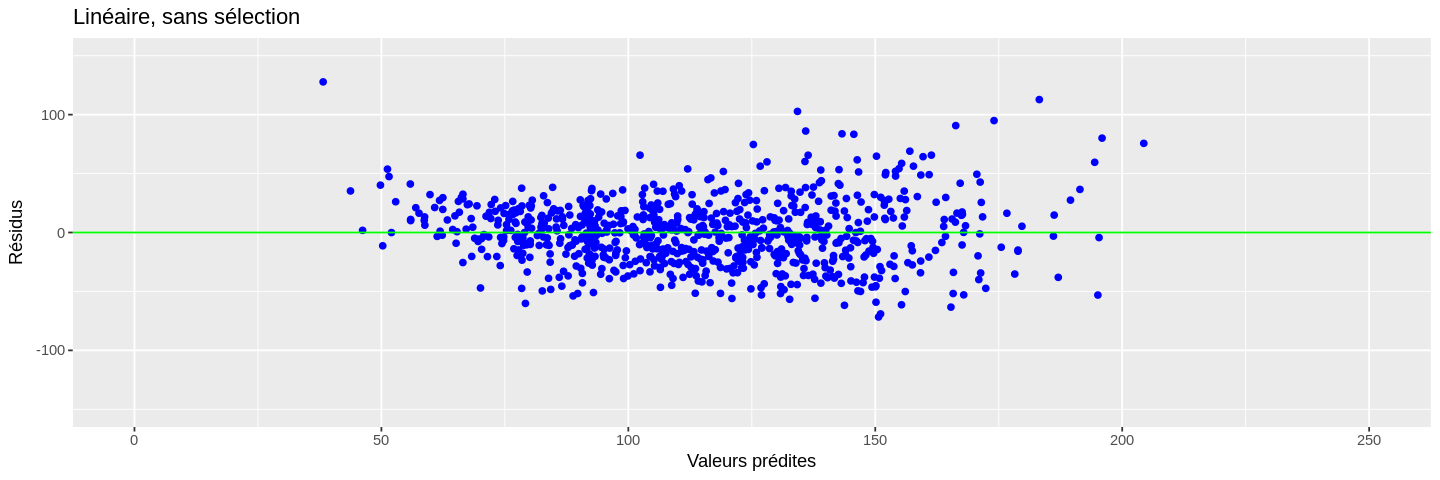

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


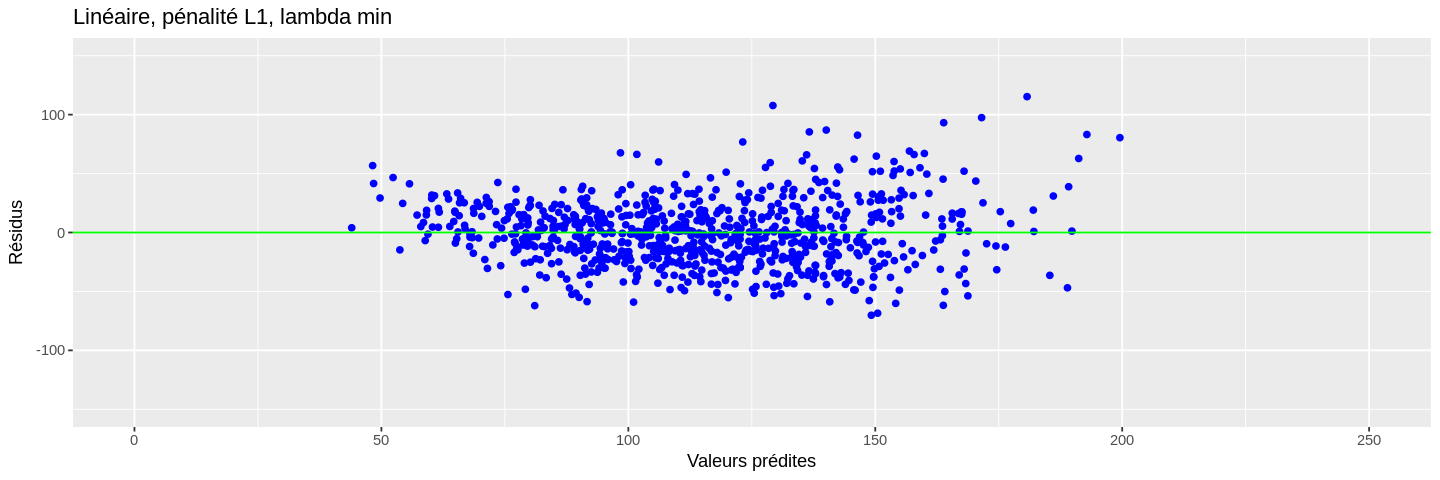

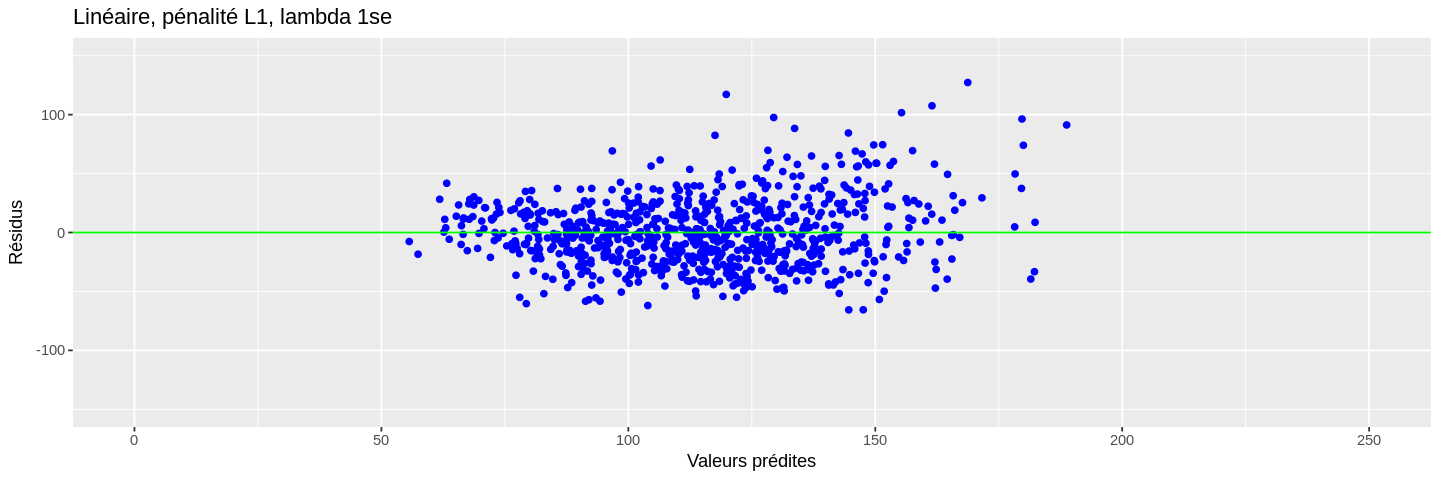

In [38]:
# Extraction des valeurs ajustées et des résidus
fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- datappr$O3obs - fit.lasso

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)
res.lasso.1se <- datappr$O3obs - fit.lasso.1se

# Graphe des résidus
options(repr.plot.width = 12, repr.plot.height = 4)
par(mfrow = c(1, 3))
gplot.res(fit.lm, res.lm, "Linéaire, sans sélection")
gplot.res(fit.lasso, res.lasso, "Linéaire, pénalité L1, lambda min")
gplot.res(fit.lasso.1se, res.lasso.1se, "Linéaire, pénalité L1, lambda 1se")

**Question** Commentez.

**Question** Calculez le critère MSE (moyenne des carrés des résidus) pour les deux modèles. Pourquoi celui obtenu par LASSO est-il moins bon ? Quel critère LASSO minimise t-il ?

**Réponse:**

**Question Commentez.**
- Les trois graphiques montrent les résidus d'un modèle de régression par
 rapport aux valeurs prédites. Ils montrent tous une bonne homoscédasticité, ce qui signifie que les résidus sont assez constants et ne varient pas trop. De plus, les résidus sont bien centrés autour de la ligne verte à zéro, ce qui indique que les erreurs de prédiction sont équilibrées.

**Pourquoi celui obtenu par LASSO est-il moins bon ?**

- Le LASSO est moins performant ici car il impose une pénalité sur les
 coefficients. Le MSE (moyenne des carrés des résidus) obtenu avec les modèles LASSO est un peu plus élevé que celui du modèle linéaire sans sélection. Cela s'explique par le fait que le LASSO réduit la taille des coefficients, parfois même à zéro pour certaines variables.

**Quel critère LASSO minimise t-il ?**






In [39]:
paste("Modèle linéaire sans sélection:",mean(res.lm^2))
paste("LASSO avec lambda.min:",mean(res.lasso^2))
paste("LASSO avec lambda.1se:",mean(res.lasso.1se^2))

[1] "Modèle linéaire sans sélection: 763.507246231797"

[1] "LASSO avec lambda.min: 774.896148437077"

[1] "LASSO avec lambda.1se: 826.516162681358"

**Question** Estimez l'erreur du modèle linéaire simple sans sélection de variables par validation croisée. Comparez avec celle du LASSO. Qu'observez-vous?

In [40]:
V=10 ; nV=floor(nrow(datappr)/V)
S=sample(1:nrow(datappr),replace=FALSE)
error.CV = c()
for(v in 1:V)
{ # Rq : les deux dernières obs sont tjs dans l'échantillon d'apprentissage...
    datappr.learn=datappr[-c(S[(nV*(v-1)):(nV*v)]),]
    datappr.valid=datappr[c(S[(nV*(v-1)):(nV*v)]),]
    error.CV=c(error.CV,mean((datappr.valid$O3obs-predict(aov(O3obs ~ ., data=datappr.learn),newdata=datappr.valid))^2))
}
mean(error.CV)

print(reg.lasso.cv)

[1] 844.5252


Call:  cv.glmnet(x = x.mat, y = datappr[, 2]) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  0.461    44   793.2 44.95       9
1se  3.573    22   833.9 45.89       3


**Réponse:**

**Question Estimez l'erreur du modèle linéaire simple sans sélection de variables par validation croisée. Comparez avec celle du LASSO. Qu'observez-vous?**

- L'erreur du modèle linéaire simple sans sélection de variables estimée par validation croisée est 839.94. En comparaison, l'erreur du modèle LASSO avec lambda.min est 798.1, et celle avec lambda.1se est 833.2. Ainsi, le modèle LASSO (avec lambda.min) a une meilleure performance, car il présente une erreur MSE inférieure à celle du modèle linéaire simple


### Modèle quadratique

L'étude suivante met en oeuvre toutes les interactions d'ordre 2 entre les variables. Il s'agit donc d'un modèle de régression quadratique. Il est estimé avec la fonction `glm()` qui permet une sélection automatique de modèle. La méthode descendante est utilisée mais celle pas-à-pas pourrait également l'être. Ce type de procédure n'est pas implémentée en python.

#### Sélection de variables par critère AIC

Sélection descendante: à chaque étape, chaque modèle est comparé à tous les sous-modèles possibles obtenus par suppression d'une des interactions ou une des variables, à condition qu'elle ne soit pas présente dans une interaction. La variable sélectionnée et supprimée est celle qui fait décroîre le critère considéré : AIC (*Akaïke Information Criterion*).

**Question** Quel autre critère, équivalent à AIC dans le cas gaussien et de variance résiduelle connue, est utilisé en régression linéaire ?

**Réponse:**

**Quel autre critère, équivalent à AIC dans le cas gaussien et de variance résiduelle connue, est utilisé en régression linéaire ?**

- Le critère BIC (Bayesian Information Criterion) est une alternative à l'AIC utilisée en régression linéaire quand on connaît la variance résiduelle. Le BIC pénalise plus la complexité du modèle que l'AIC. Donc, il aide à choisir des modèles plus simples. En résumé, l'AIC pénalise moins la complexité du modèle, tandis que le BIC la pénalise plus fortement.





In [41]:
# Estimation du modèle avec toutes les interactions d'ordre 2
reg.glm <- glm(O3obs ~ .^2, data = datappr)
# Recherche du meilleur modèle au sens
# du critère d'Akaïke par méthode descendante
reg.glm.step <- step(reg.glm, direction = "backward")

Start:  AIC=7775.04
O3obs ~ (JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO)^2

                  Df Deviance    AIC
- STATION:VentANG  4   466934 7767.8
- JOUR:STATION     4   467365 7768.5
- STATION:LNO      4   468272 7770.1
- STATION:LNO2     4   468532 7770.6
- JOUR:LNO         1   466536 7773.1
- VentMOD:VentANG  1   466536 7773.1
- LNO2:LNO         1   466564 7773.1
- JOUR:MOCAGE      1   466567 7773.1
- MOCAGE:LNO2      1   466592 7773.2
- MOCAGE:LNO       1   466608 7773.2
- JOUR:LNO2        1   466614 7773.2
- VentMOD:LNO2     1   466647 7773.3
- TEMPE:VentANG    1   466810 7773.5
- TEMPE:VentMOD    1   466816 7773.6
- VentANG:SRMH2O   1   466890 7773.7
- JOUR:TEMPE       1   466924 7773.7
- VentMOD:LNO      1   466977 7773.8
- JOUR:SRMH2O      1   467300 7774.4
- JOUR:VentANG     1   467615 7775.0
<none>                 466530 7775.0
- VentANG:LNO2     1   467806 7775.3
- VentMOD:SRMH2O   1   467808 7775.3
- MOCAGE:VentANG   1   467855 7775.4


In [42]:
# Coefficients du modèle
anova(reg.glm.step, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,831,1364618.9,NA,NA
JOUR,1,9.642305e+02,830,1363654.7,1.595718e+00,2.068876e-01
MOCAGE,1,4.684412e+05,829,895213.5,7.752295e+02,4.365858e-119
TEMPE,1,2.185214e+05,828,676692.1,3.616340e+02,1.437557e-66
STATION,4,5.099857e+03,824,671592.2,2.109955e+00,7.780965e-02
VentMOD,1,1.057406e+04,823,661018.2,1.749916e+01,3.199949e-05
VentANG,1,1.210514e+04,822,648913.0,2.003296e+01,8.743243e-06
SRMH2O,1,2.815143e+03,821,646097.9,4.658817e+00,3.119815e-02
LNO2,1,1.550295e+03,820,644547.6,2.565603e+00,1.096148e-01


#### Sélection de variable par régularisation L1 (LASSO)

In [58]:
# Comparer avec un modèle quadratique avec pénalité L1
x.mat2 <- model.matrix(O3obs ~ .^2 - 1, data = datappr)
reg.lasso2.cv <- cv.glmnet(y = datappr[, "O3obs"], x = x.mat2)
coef(reg.lasso2.cv, s = "lambda.1se")

74 x 1 sparse Matrix of class "dgCMatrix"
                            s1
(Intercept)        33.60454924
JOUR0               .         
JOUR1               .         
MOCAGE              .         
TEMPE               0.89305529
STATIONAls          .         
STATIONCad          .         
STATIONPla          .         
STATIONRam          .         
VentMOD             .         
VentANG             .         
SRMH2O              .         
LNO2                .         
LNO                 .         
JOUR1:MOCAGE        .         
JOUR1:TEMPE         .         
JOUR1:STATIONAls    .         
JOUR1:STATIONCad    .         
JOUR1:STATIONPla    .         
JOUR1:STATIONRam    .         
JOUR1:VentMOD       .         
JOUR1:VentANG       .         
JOUR1:SRMH2O        .         
JOUR1:LNO2          .         
JOUR1:LNO           .         
MOCAGE:TEMPE        0.01319568
MOCAGE:STATIONAls   .         
MOCAGE:STATIONCad   .         
MOCAGE:STATIONPla   .         
MOCAGE:STATIONRam   .       

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


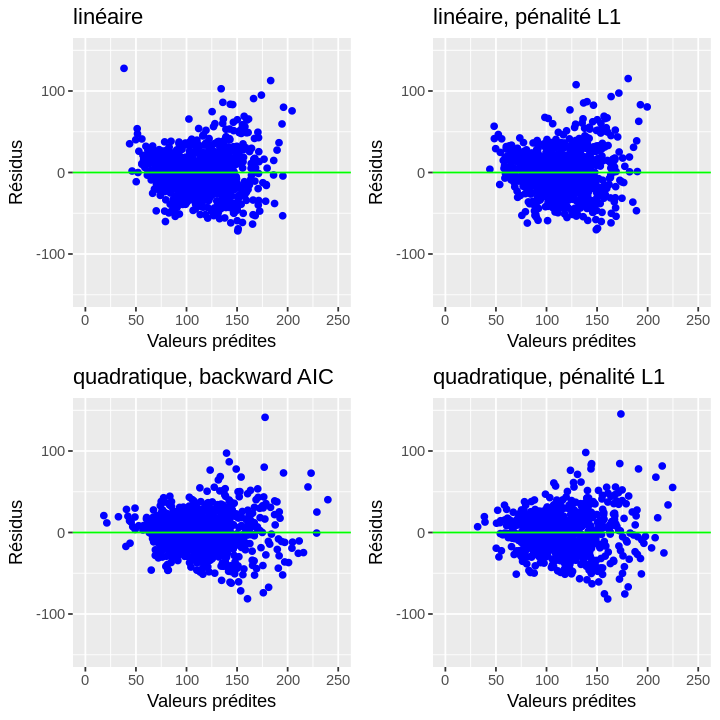

In [59]:
# Extraction des valeurs ajustées et des résidus
fit.glm <- reg.glm.step$fitted.values
res.glm <- reg.glm.step$residuals
fit.lasso2 <- predict(reg.lasso2.cv, s = "lambda.min", newx = x.mat2)
res.lasso2 <- datappr$O3obs - fit.lasso2

# Graphe des résidus
g1<-gplot.res(fit.lm, res.lm, "linéaire")
g2<-gplot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")
g3<-gplot.res(fit.glm, res.glm, "quadratique, backward AIC")
g4<-gplot.res(fit.lasso2, res.lasso2, "quadratique, pénalité L1")
grid.arrange(g1,g2,g3,g4,ncol=2,nrow=2)

 On remarque que la présence de certaines interactions ou variables sont pertinentes au sens du critère d'Akaïke mais pas significative au sens du test de Fisher. Cette présence dans le modèle pourrait être plus finement analysée en considérant une estimation de l'erreur par validation croisée. L'idée serait de retirer une à une les variables ou interactions les moins significatives pour voir comment se comporte la validation croisée. D'autre part, si la procédure pas-à-pas conduit à un modèle différent, l'estimation de l'erreur par validation croisée permet également d'optimiser le choix.

Ces raffinements ne s'avèrent pas efficaces sur ces données. Le modèle obtenu par minimisaiton du critère AIC est conservé.

### Prévision de l'échantillon test

Le modèle "optimal" obtenu par la méthode descendante est utilisé pour prédire l'échantillon test et estimer ainsi, sans biais, une erreur de prévision. Deux erreurs sont estimées : la première est celle quadratique pour la régression tandis que la deuxième est issue de la matrice de confusion qui croise les dépassements de seuils prédits avec ceux effectivement observés.

#### Erreur de régression

In [45]:
# Calcul des prévisions pour le modèle quadratique backward AIC
pred.glm <- predict(reg.glm.step, newdata = datestr)
# Erreur quadratique moyenne de prévision (MSE)
sum((pred.glm - datestr[, "O3obs"])^2) / nrow(datestr)

[1] 632.1576

In [46]:
# Erreur quadratique par MOCAGE
sum((datestr[,"MOCAGE"] - datestr[,"O3obs"])^2) / nrow(datestr)

[1] 1577.113

#### Erreur de classification (matrice de confusion)

In [47]:
# Matrice de confusion pour la prévision du dépassement de seuil
table(pred.glm > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   157   18
  TRUE      8   26

In [48]:
# Matrice de confusion pour la prévision du
# dépassement de seuil par MOCAGE
table(datestr[, "MOCAGE"] > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   131   14
  TRUE     34   30

Noter ces erreurs pour les comparer avec celles obtenues par les autres méthodes. Noter l'asymétrie des erreurs.

## [Prévision par modèle binomial](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)

Plutôt que de prévoir la concentration puis le dépassement, on peut se poser la question de savoir s'il ne serait pas pertinent de prévoir directement la présence ou l'absence d'un dépassement. La variable à modéliser étant binaire, c'est la régression logistique qui va être employée. Comme pour la régression, différentes stratégies de choix de modèle peuvent être utilisées et comparées avant d'estimer l'erreur de prévision sur l'échantillon test.

### Régression logistique sans interaction

In [49]:
# estimation du modèle complet
log.lm <- glm(DepSeuil ~. , data = datappq, family = binomial)
# significativité des paramètres
anova(log.lm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,734.5222,NA
JOUR,1,0.1647852,830,734.3575,6.847886e-01
MOCAGE,1,117.5971083,829,616.7604,2.124401e-27
TEMPE,1,149.8623985,828,466.8980,1.857959e-34
STATION,4,14.1091275,824,452.7888,6.954788e-03
VentMOD,1,11.1636715,823,441.6252,8.341468e-04
VentANG,1,1.6809416,822,439.9442,1.947994e-01
SRMH2O,1,16.3403451,821,423.6039,5.292510e-05
LNO2,1,0.2082303,820,423.3956,6.481580e-01


In [50]:
# Recherche d'un modèle optimal au sens d'Akaïke
log.lm.step <- step(log.lm, direction = "backward")

Start:  AIC=443.04
DepSeuil ~ JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO

          Df Deviance    AIC
- MOCAGE   1   417.04 441.04
- JOUR     1   417.07 441.07
<none>         417.04 443.04
- VentANG  1   419.16 443.16
- VentMOD  1   420.89 444.89
- LNO2     1   422.16 446.16
- LNO      1   423.40 447.40
- STATION  4   436.03 454.03
- SRMH2O   1   434.14 458.14
- TEMPE    1   531.55 555.55

Step:  AIC=441.04
DepSeuil ~ JOUR + TEMPE + STATION + VentMOD + VentANG + SRMH2O + 
    LNO2 + LNO

          Df Deviance    AIC
- JOUR     1   417.07 439.07
<none>         417.04 441.04
- VentANG  1   419.18 441.18
- VentMOD  1   421.11 443.11
- LNO2     1   427.72 449.72
- LNO      1   427.88 449.88
- SRMH2O   1   434.40 456.40
- STATION  4   443.26 459.26
- TEMPE    1   536.28 558.28

Step:  AIC=439.07
DepSeuil ~ TEMPE + STATION + VentMOD + VentANG + SRMH2O + LNO2 + 
    LNO

          Df Deviance    AIC
<none>         417.07 439.07
- VentANG  1   419.18 439.18

In [51]:
# Modèle obtenu
anova(log.lm.step, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,734.5222,NA
TEMPE,1,235.1882740,830,499.3340,4.404738e-53
STATION,4,24.9944161,826,474.3396,5.044004e-05
VentMOD,1,24.8315098,825,449.5080,6.256632e-07
VentANG,1,2.6215573,824,446.8865,1.054209e-01
SRMH2O,1,18.5675412,823,428.3189,1.639892e-05
LNO2,1,0.4134857,822,427.9055,5.202056e-01
LNO,1,10.8350627,821,417.0704,9.959595e-04


In [52]:
# matrice de confusion de l'échantillon d'apprentissage et erreur apparente
table(log.lm.step$fitted.values > 0.5, datappq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   678   65
  TRUE     20   69

### Régression logistique avec interactions

Avec autant de variables et d'interactions donc de paramètres, l'estimation du modèle complet de régression logistique  rencontre des soucis et affiche des *warnings* car certaines probabilité trop bien ajustés (0 ou 1) provoquent des divisions par 0. Ici une procédure *forward* ou  mieux *stepwise* de sélection des variables et interactions  conduit à des résultats raisonnables. Une méthode avec pénalisation L1 peut aussi être utilisée.

In [53]:
# régression avec le modèle minimum
log.qm <- glm(DepSeuil ~ 1, data = datappq,family = binomial)
# algorithme stepwise en précisant le plus grand
# modèle possible
log.qm.step1 <- step(log.qm, direction = "both",
    scope = list(lower = ~1, upper = ~(JOUR + MOCAGE + TEMPE +
            STATION + VentMOD + VentANG + LNO2 + LNO + SRMH2O)^2),
    family=binomial)

Start:  AIC=736.52
DepSeuil ~ 1

          Df Deviance    AIC
+ TEMPE    1   499.33 503.33
+ MOCAGE   1   616.81 620.81
+ SRMH2O   1   665.18 669.18
+ STATION  4   713.89 723.89
+ VentANG  1   723.09 727.09
+ LNO2     1   727.96 731.96
+ LNO      1   730.71 734.71
+ VentMOD  1   732.07 736.07
<none>         734.52 736.52
+ JOUR     1   734.36 738.36

Step:  AIC=503.33
DepSeuil ~ TEMPE

          Df Deviance    AIC
+ MOCAGE   1   466.91 472.91
+ SRMH2O   1   468.52 474.52
+ STATION  4   474.34 486.34
+ VentANG  1   489.75 495.75
+ VentMOD  1   491.61 497.61
+ LNO      1   495.73 501.73
<none>         499.33 503.33
+ JOUR     1   499.32 505.32
+ LNO2     1   499.33 505.33
- TEMPE    1   734.52 736.52

Step:  AIC=472.91
DepSeuil ~ TEMPE + MOCAGE

               Df Deviance    AIC
+ SRMH2O        1   446.96 454.96
+ STATION       4   452.83 466.83
+ LNO           1   460.34 468.34
+ VentANG       1   461.91 469.91
+ LNO2          1   462.00 470.00
+ VentMOD       1   463.96 471.96
<none>  

In [54]:
anova(log.qm.step1, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,734.5222,NA
TEMPE,1,235.188274,830,499.3340,4.404738e-53
MOCAGE,1,32.423381,829,466.9106,1.239857e-08
SRMH2O,1,19.948650,828,446.9619,7.955010e-06
STATION,4,16.500681,824,430.4613,2.415908e-03
VentMOD,1,5.396408,823,425.0649,2.017824e-02
LNO,1,1.118036,822,423.9468,2.903418e-01
SRMH2O:STATION,4,12.400521,818,411.5463,1.460862e-02
TEMPE:SRMH2O,1,5.378442,817,406.1679,2.038708e-02


### Prévision de l'échantillon test

#### Matrice de confusion

In [55]:
# Prévision du modèle quadratique
pred.log <- predict(log.qm.step1, newdata = datestq, type = "response")
# Matrice de confusion pour la prévision du
# dépassement de seuil
table(pred.log > 0.5, datestq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   162   24
  TRUE      3   20

Comparer avec l'approche précédente. Mémoriser les résultats obtenus pour comparer avec les autres méthodes.

#### Courbe ROC

Il est également possible de construire une courbe ROC en association de la prévision obtenue à partir d'un modèle gaussien. En effet, la variation du seuil théorique de dépassement (150) va faire varier les proportions respectives des taux de vrais et faux positifs. Cela revient encore à faire varier le seuil d'une "proba" pour les valeurs de prévisions divisées par 300.

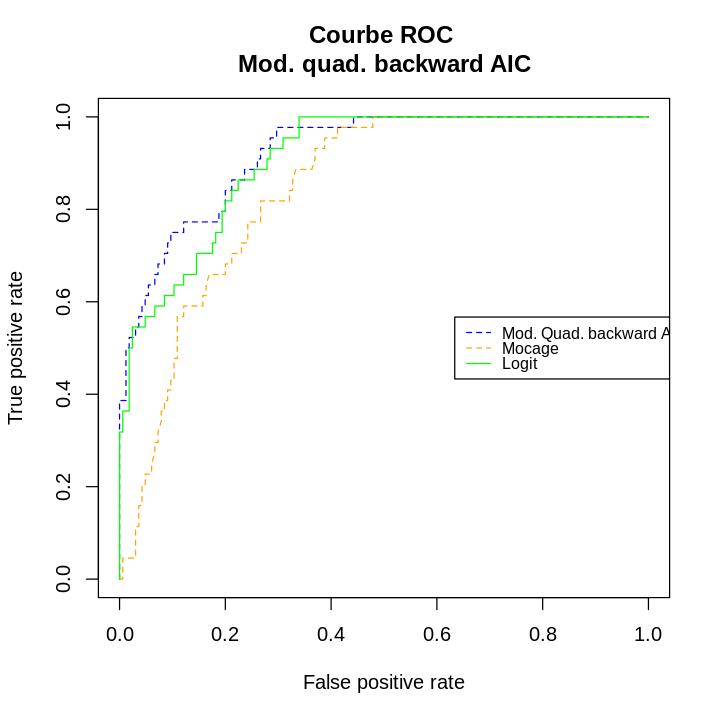

In [60]:
options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(1, 1))
rocmocage <- datestr[,  "MOCAGE"] / 300
DepSeuil=c(datestr[, "O3obs"] > 150)
predmocage <- prediction(rocmocage,DepSeuil)
perfmocage <- performance(predmocage, "tpr", "fpr")

rocglm <- pred.glm / 300
predglm <- prediction(rocglm,DepSeuil)
perfglm <- performance(predglm, "tpr", "fpr")

roclogit <- predict(log.qm.step1, newdata = datestq, type="response")
predlogit <- prediction(roclogit, datestq[, "DepSeuil"])
perflogit <- performance(predlogit, "tpr", "fpr")

plot(perfglm, col = "blue",lty=2, main = "Courbe ROC \n Mod. quad. backward AIC ")
plot(perfmocage,col="orange",lty=2,add=TRUE)
plot(perflogit,col="green",lty=1,add=TRUE)

legend("right", legend=c("Mod. Quad. backward AIC", "Mocage", "Logit"),
       col=c("blue","orange","green"), lty=c(2,2,1), text.font=1,    cex=0.8)

# <FONT COLOR="Red">Épisode 3 :  CART, Agrégation de modèles  </font>

## [Arbre de décision binaire (CART)](http://wikistat.fr/pdf/st-m-app-cart.pdf)

La librairie `rpart` est celle la plus couramment utilisée pour la construction d'arbres de décision. Deux types d'arbres peuvent être estimés selon que la variable à modéliser est la concentration d'ozone (arbre de régression) ou directement le dépassement du seuil (arbre de discrimination ou de décision). Différents paramètres contrôlent l'exécution de l'algorithme : la pénalisation minimale (cp) pour la construction de l'arbre maximal, le nombre minimal d'observations par noeud, le nombre de validations croisées (par défaut 10)... cf. l'aide en ligne (`?rpart.control`) pour plus de détails mais celle-ci n'est pas très explicite sur certains paramètres.

NB. Une séquence de valeurs de la pénalisation `cp` est associée à une séquence d'arbres emboîtés.


### Estimation et élagage de l'arbre de régression
**Question** Quel critère est optimisé lors de la création d'un noeud de l'arbre?

**Reponse :**

Arbre de régression : Critère optimisé = Somme des carrés des erreurs résiduelles (RSS).

Arbre de classification/discrimination : Critère optimisé = Indice de Gini ou entropie.

En effet, l'algorithme choisit d'abord la variable qui permet de réduire le plus l'erreur ou d'améliorer la pureté à chaque division, ce qui signifie que cette première variable est souvent celle qui a le plus fort pouvoir explicatif dans l'arbre.

In [73]:
#install.packages("rpart")
install.packages("rpart.plot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [69]:
library(rpart)
#help(rpart)
#help(rpart.control)

In [70]:
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=0.001))

La commande `summary(tree.reg)` fournit un descriptif de l'arbre obtenu mais un graphe est  préférable.

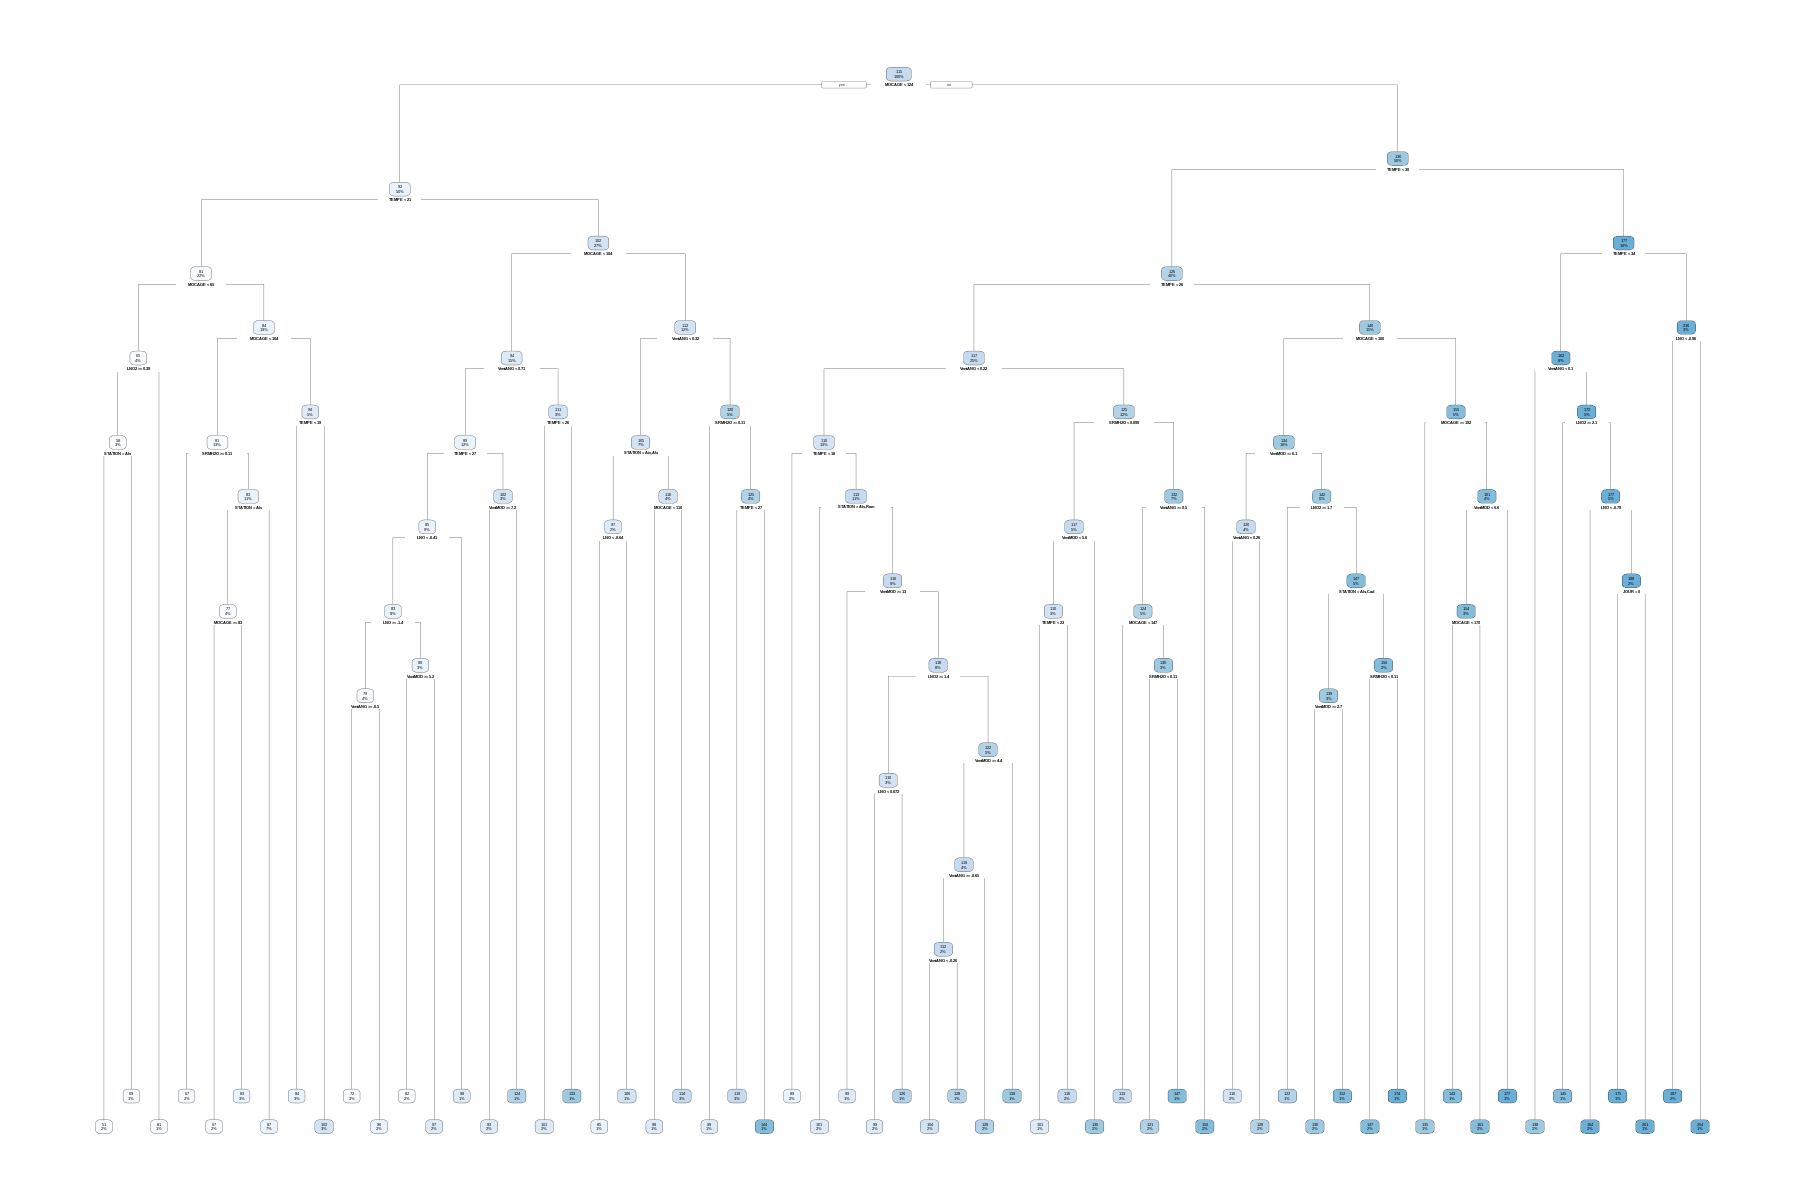

In [74]:
library(rpart.plot)
options(repr.plot.width = 15, repr.plot.height = 10)
rpart.plot(tree.reg)

L'arbre est illisible et présente trop de feuilles pour une bonne prévision (sur-apprentissage), il est nécessaire d'en réduire le nombre par élagage. Les commandes suivantes calculent les prévisions obtenues par validation croisée 10-fold pour chaque arbre élagué suivant les valeurs successives du coefficient de complexité. La séquence de ces valeurs est implicitement celle fournit par `rpart`.

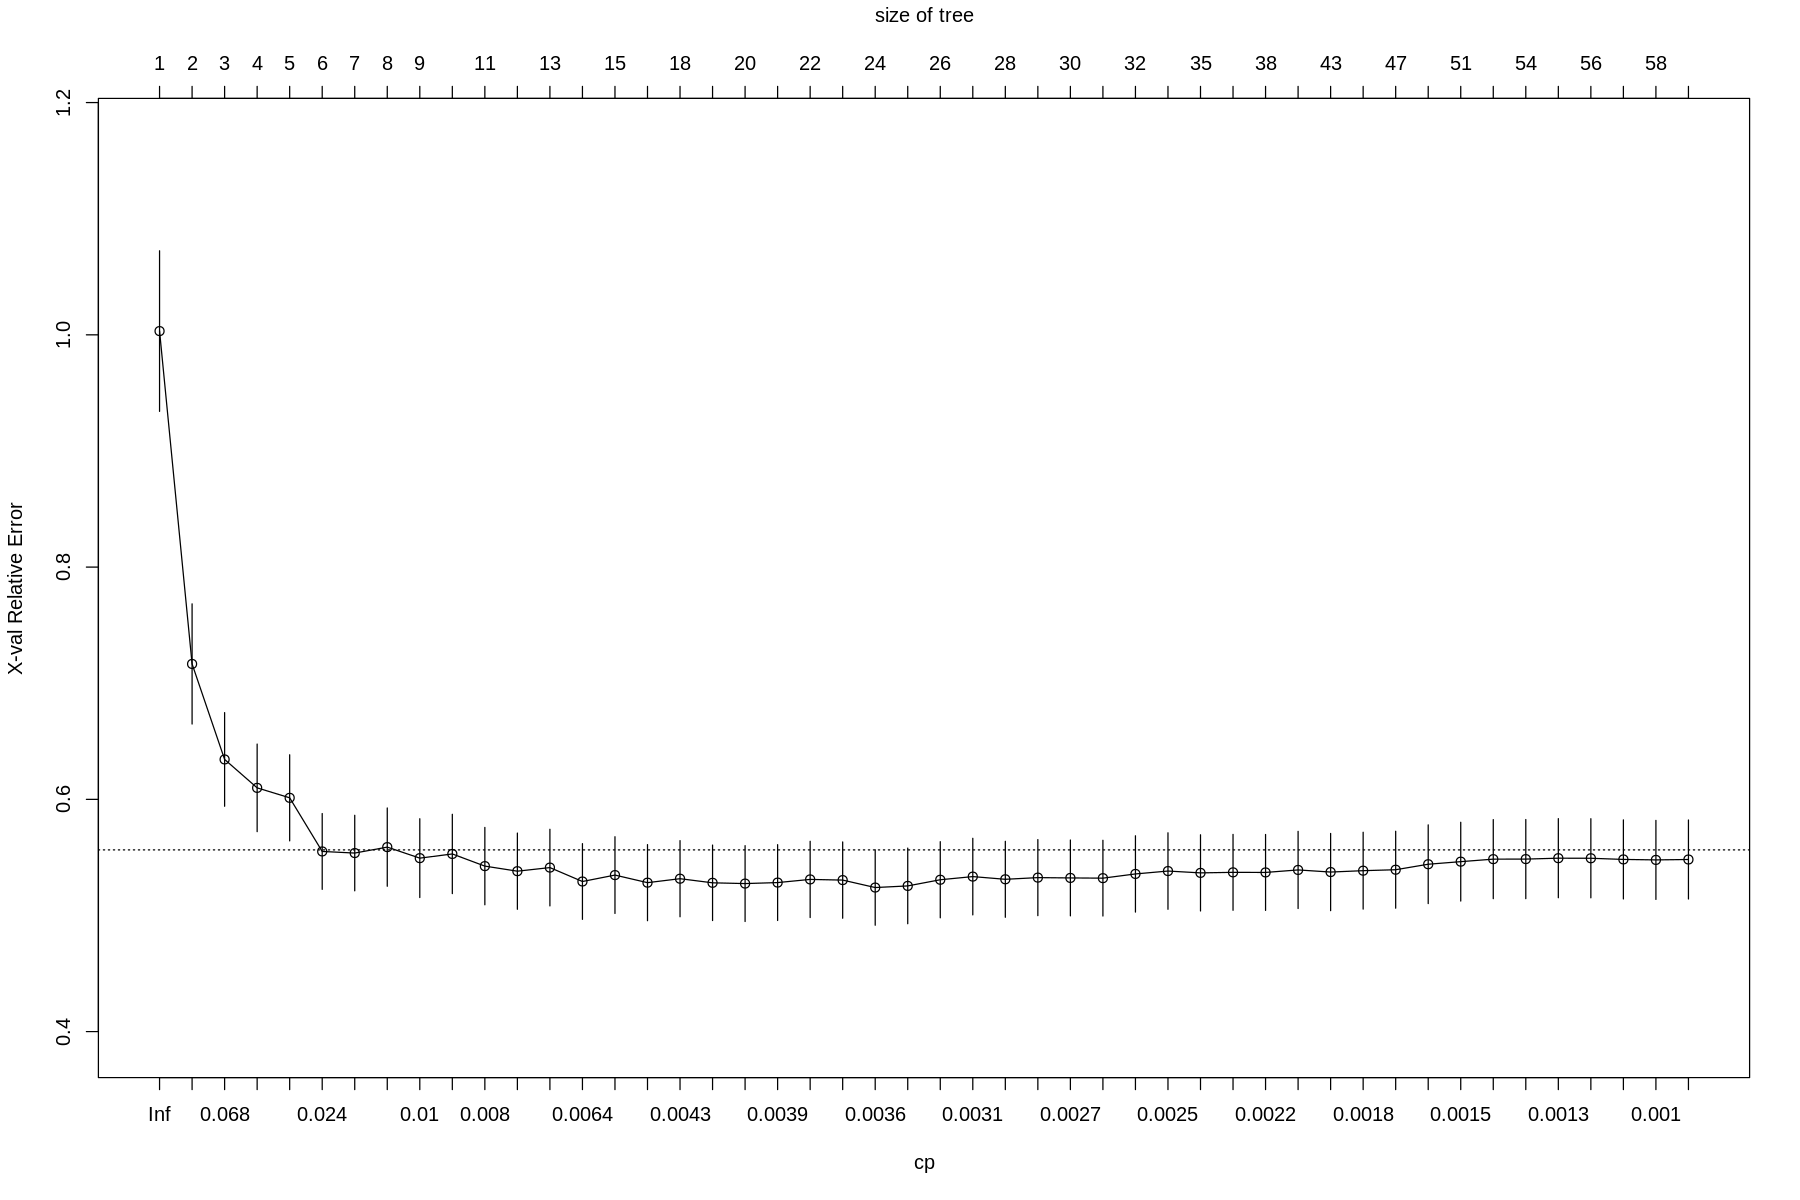

In [77]:
help(xpred.rpart)
xmat<-xpred.rpart(tree.reg,xval=10)
# one row for each observation and one column for each complexity value

# Cross-validation error par valeur de CP
CVerr<-apply((xmat-datappr[,"O3obs"])^2,2,sum)

plotcp(tree.reg)

Cherchez la valeur de `cp` correspondant à la plus petite erreur puis utilisez la pour la construction del'arbre.

[1] 0.006419232

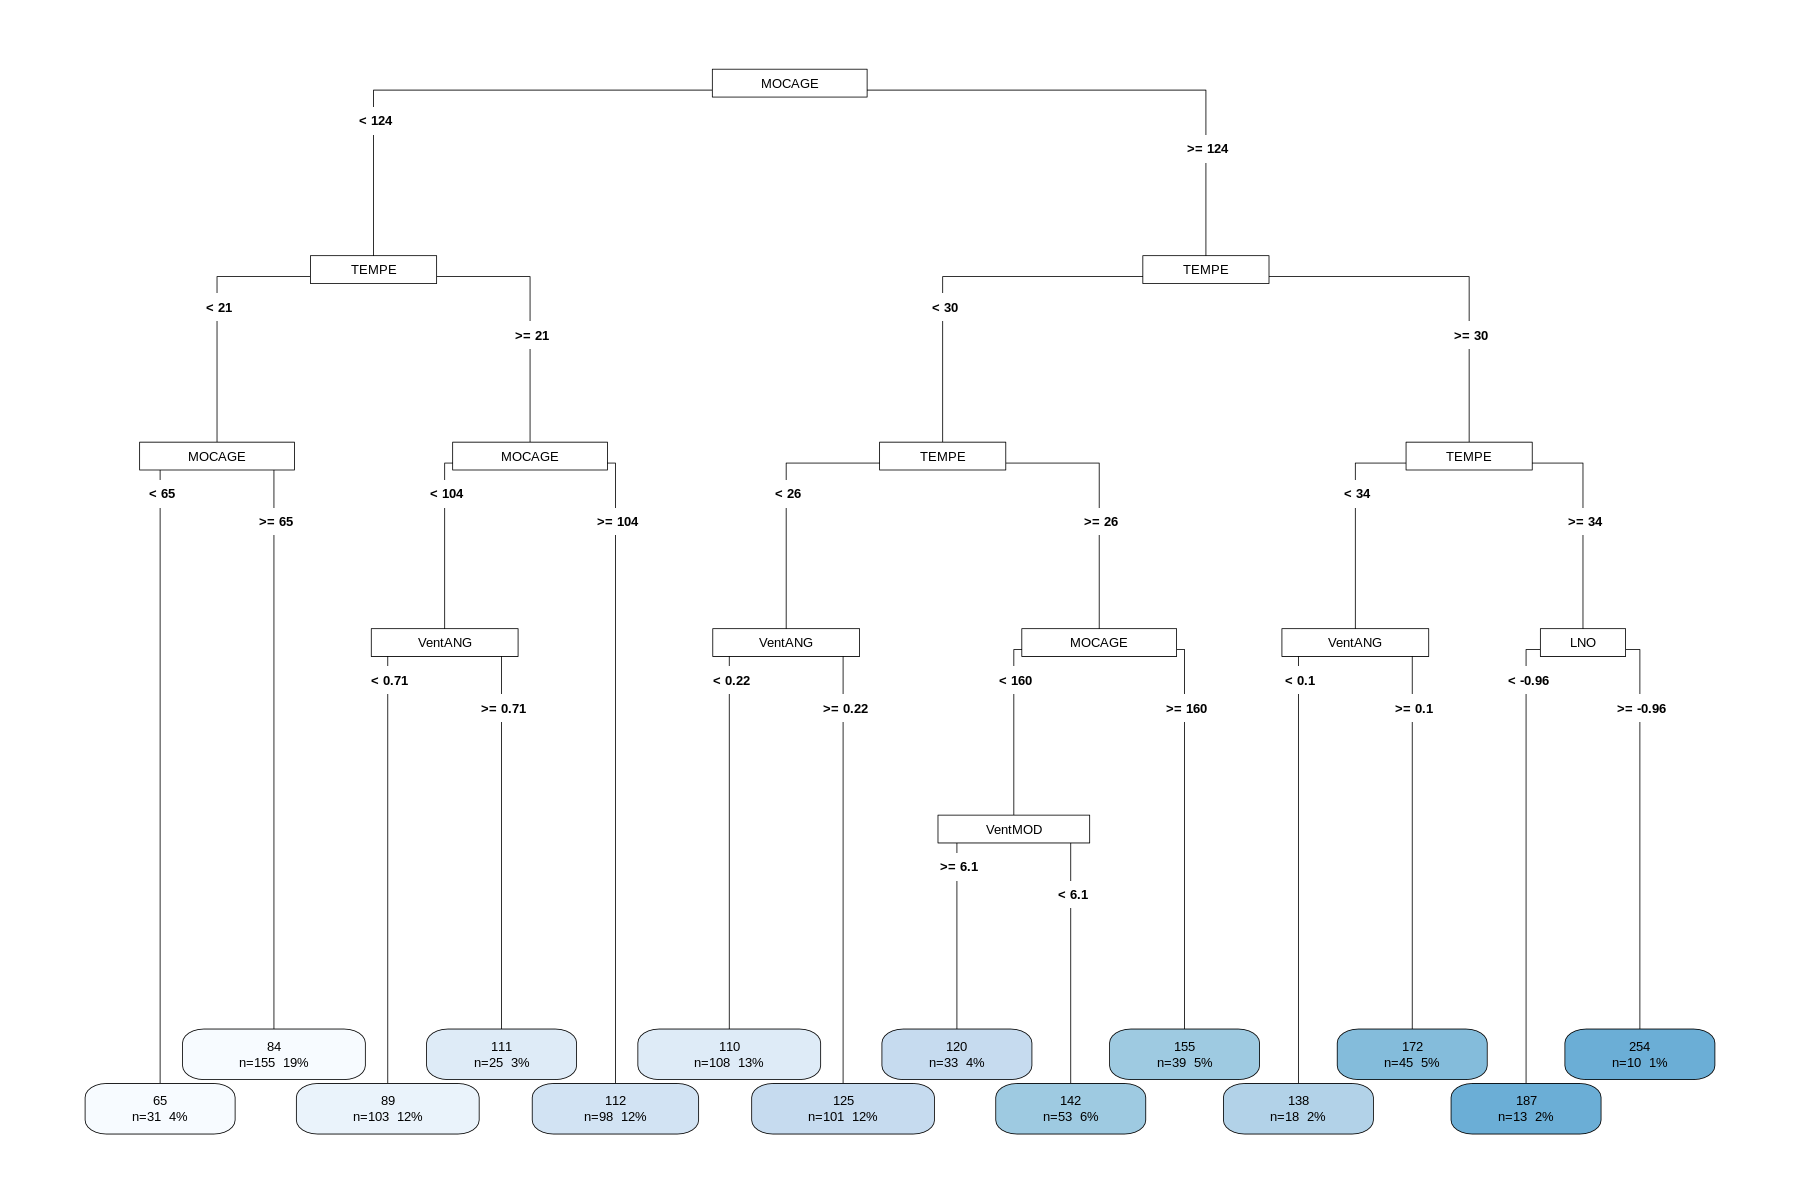

In [78]:
as.numeric(attributes(which.min(CVerr))$names)
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))
rpart.plot(tree.reg,type=5,extra=101)

La librairie `partykit` propose une construction graphique de l'arbre:

In [80]:
install.packages("partykit")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘libcoin’, ‘inum’




Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm



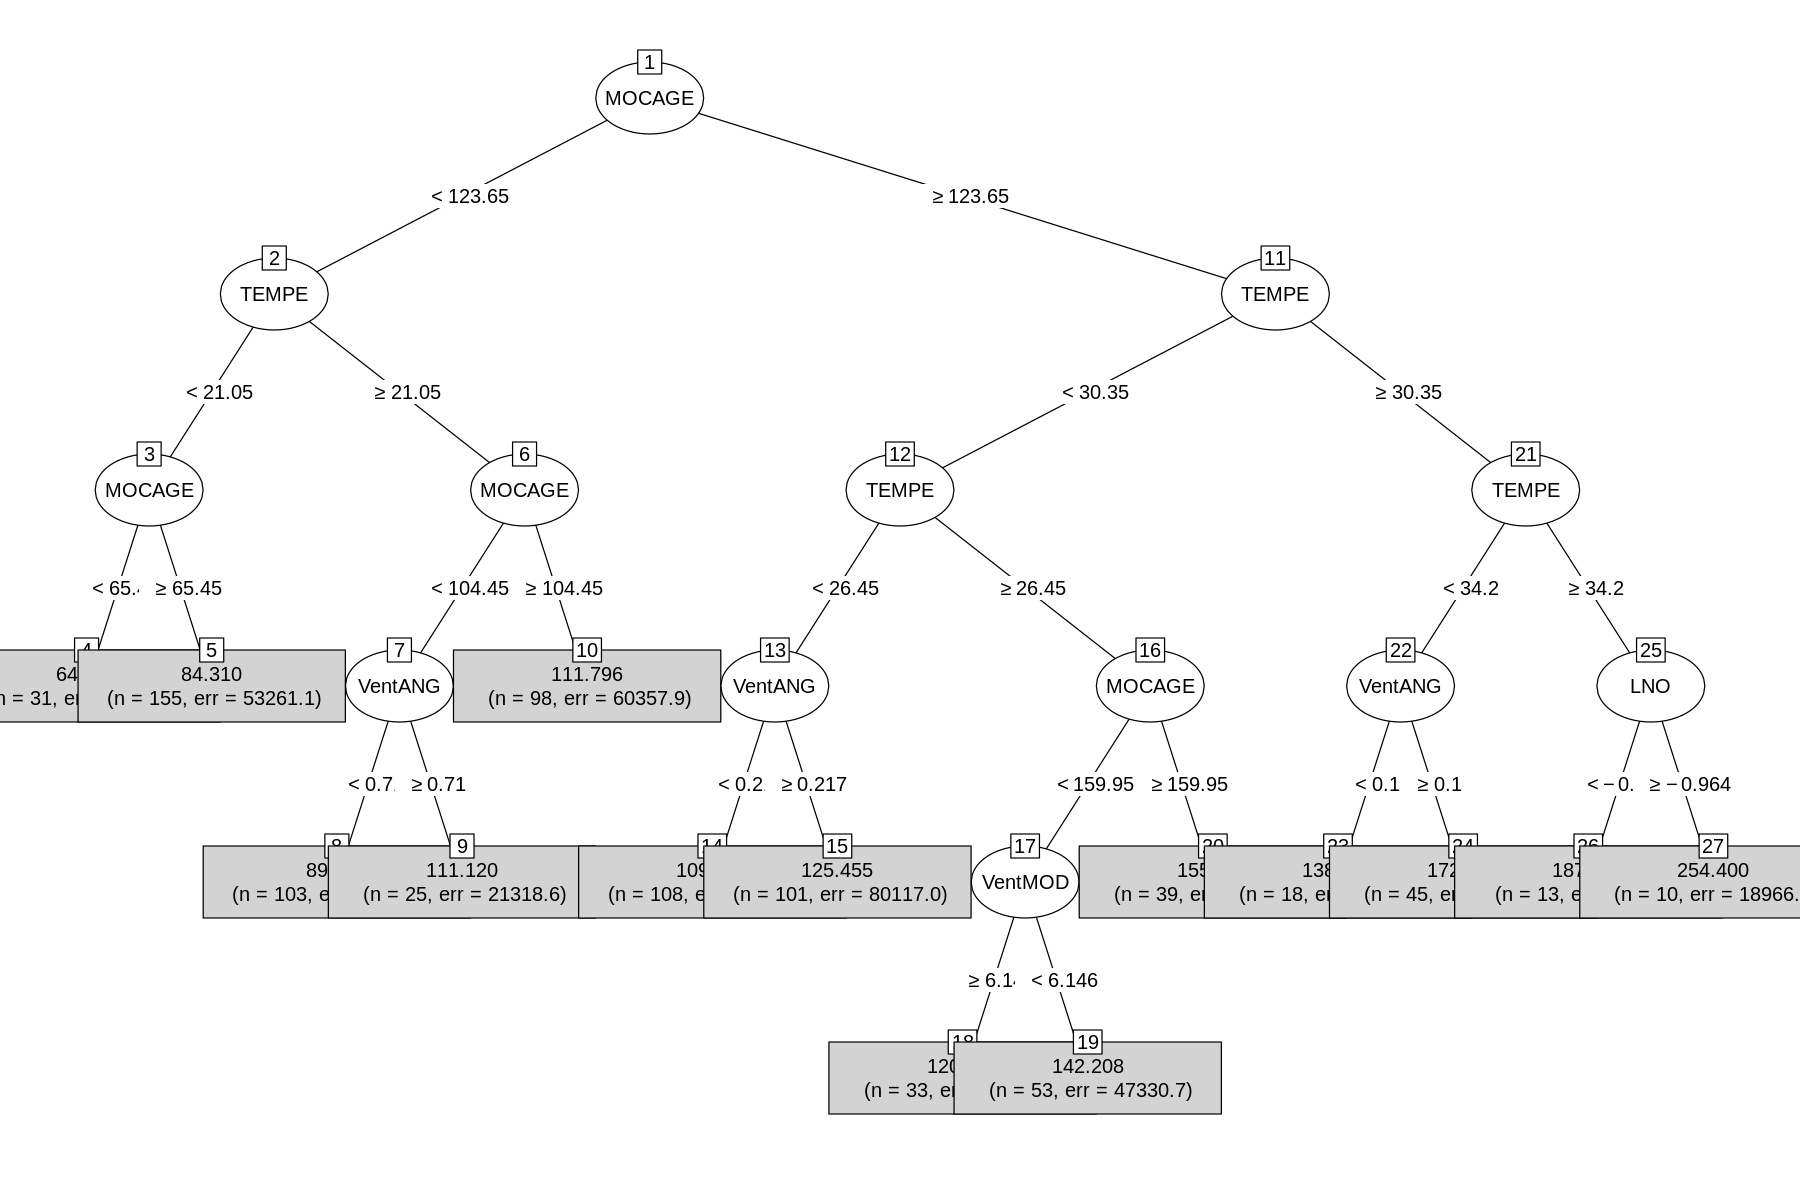

In [81]:
library(partykit)
plot(as.party(tree.reg), type="simple")

La fenêtre est trop petite pour représenter les distributions (histogramme) de la variable cible (concentration en ozone) dans chaque feuille.

**Question** Quelle est la variable qui contribue le plus à l'interprétation ?
**MOCAGE** ,**TEMPE**

Graphe des résidus

In [87]:
summary(tree.reg)

Call:
rpart(formula = O3obs ~ ., data = datappr, control = rpart.control(cp = as.numeric(attributes(which.min(CVerr))$names)))
  n= 832 

            CP nsplit rel error    xerror       xstd
1  0.295561507      0 1.0000000 1.0031426 0.06915800
2  0.129577868      1 0.7044385 0.7398299 0.05293057
3  0.036181442      2 0.5748606 0.6276855 0.03904459
4  0.031399600      3 0.5386792 0.5915675 0.03558553
5  0.031053573      4 0.5072796 0.5800772 0.03565214
6  0.018687228      5 0.4762260 0.5407030 0.03099268
7  0.013291593      6 0.4575388 0.5412808 0.03197043
8  0.010905823      7 0.4442472 0.5284951 0.03117500
9  0.009713967      8 0.4333414 0.5133420 0.03119282
10 0.009018856      9 0.4236274 0.5104824 0.03136901
11 0.007177020     10 0.4146085 0.5103223 0.03125079
12 0.007130909     11 0.4074315 0.5066218 0.03068085
13 0.006893857     12 0.4003006 0.5062815 0.03080083
14 0.006419232     13 0.3934068 0.5192684 0.03129230

Variable importance
 MOCAGE   TEMPE STATION    LNO2 VentMOD  SRMH2

Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_point()`).”


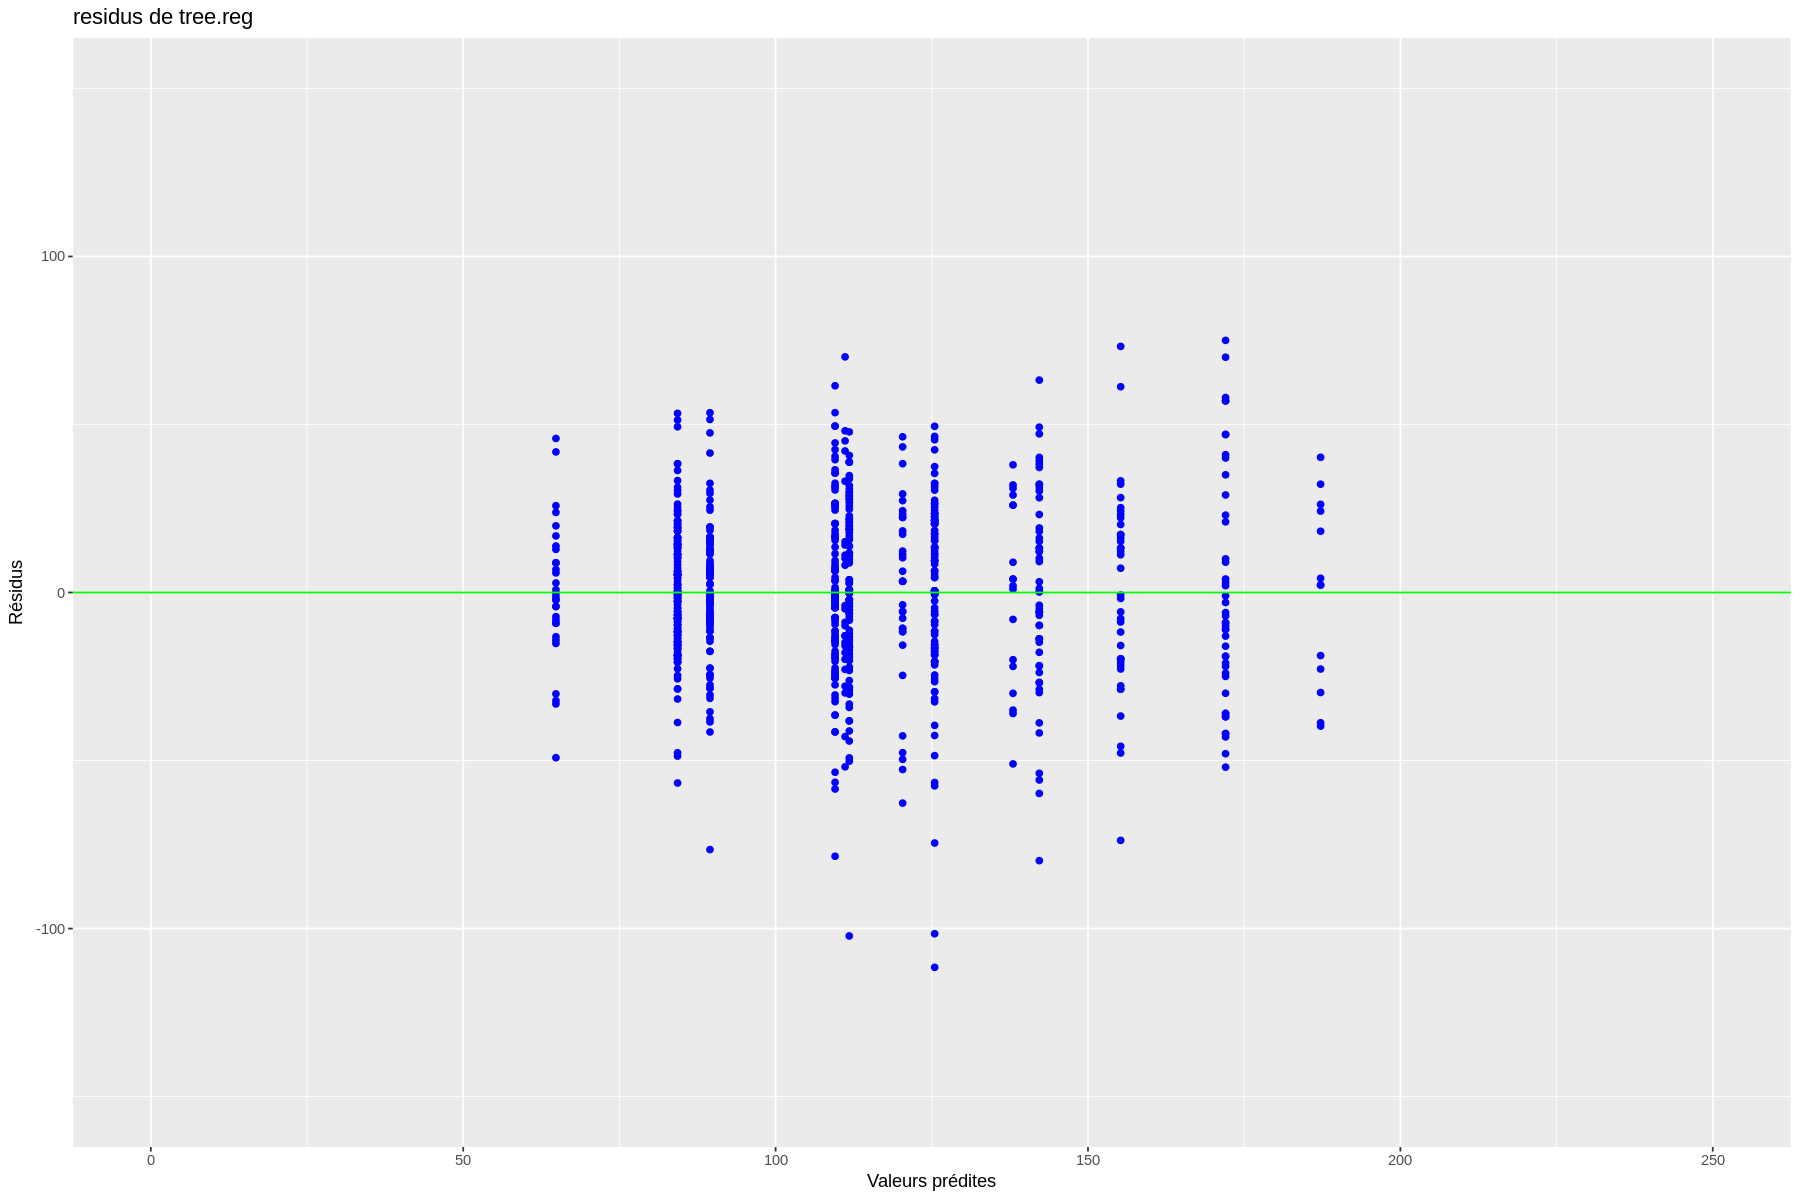

In [82]:
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"O3obs"]
gplot.res(fit.tree,res.tree,"residus de tree.reg")

**Question** A quoi est due la structure particulière de ce graphe ? **feuille de l'arbre**

La structure particulière du graphe des résidus est due au fait que les arbres de décision créent des prédictions constantes dans des segments de l'espace des variables explicatives, entraînant des résidus qui montrent souvent des paliers ou des segments correspondant aux divisions effectuées par l'arbre.

Voici un exemple de code pour faire cet élagage avec la librairie `caret`

In [85]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘ModelMetrics’, ‘recipes’




Loading required package: lattice

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


[1] "Valeur de cp retenue = 0.00689385681323849"


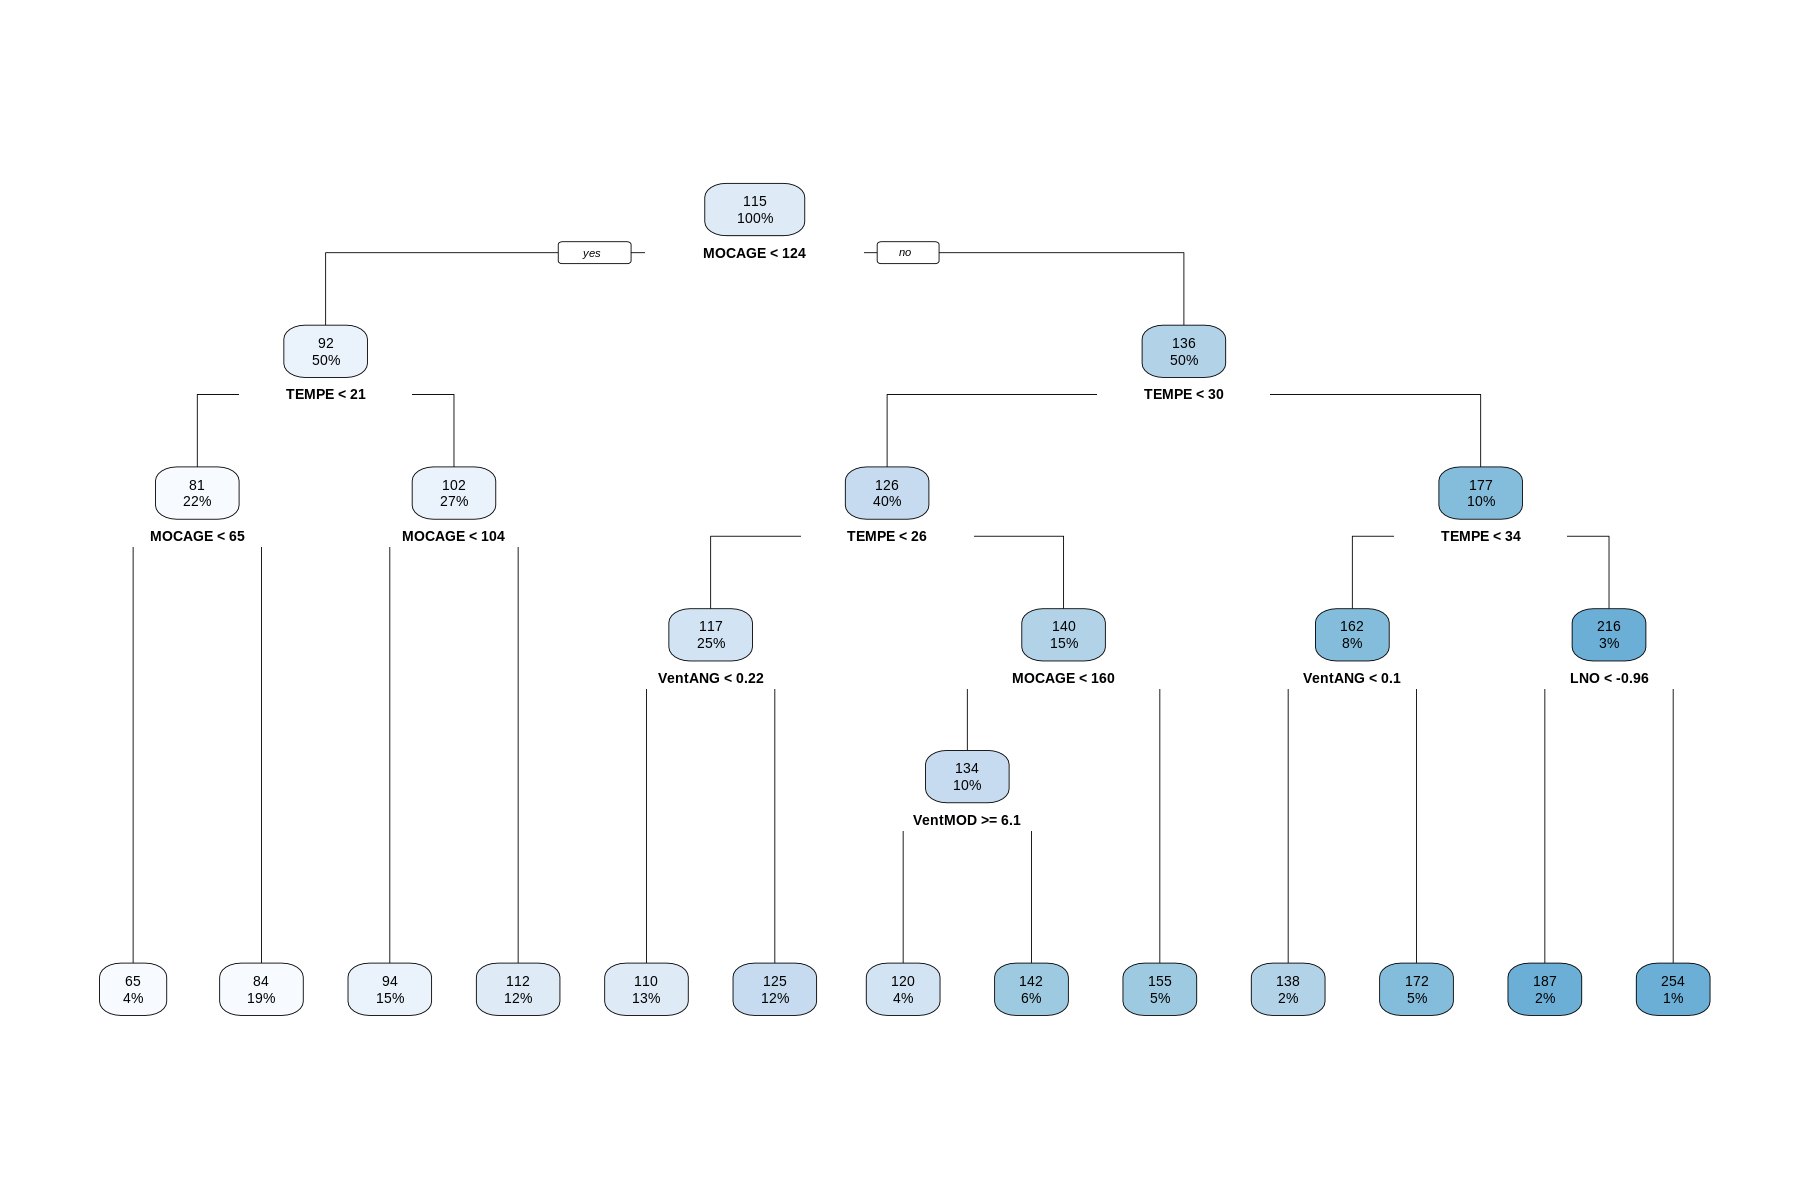

In [88]:
library(caret)
ctrl <- trainControl(method = "cv",number = 10)
treecaret <- train(O3obs~.,data=datappr,method = "rpart",trControl = ctrl,tuneLength =20)
print(paste("Valeur de cp retenue = ",treecaret$bestTune,sep=""))
rpart.plot(treecaret$finalModel)

### Estimation et élagage d'un arbre de discrimination

Dans le cas d'une discrimination, le critère par défaut est l'indice de concentration de Gini ; il est possible de préciser un autre critère (split="information") ainsi que des poids sur les observations, une matrice de coûts de mauvais classement ainsi que des probabilités a priori (`?rpart` pour plus de détails).

**Question** Quel autre critère d'hétérogénéité est utilisé ?

**Indice de Gini (utilisé par défaut)**

**Entropie (gain d'information)**

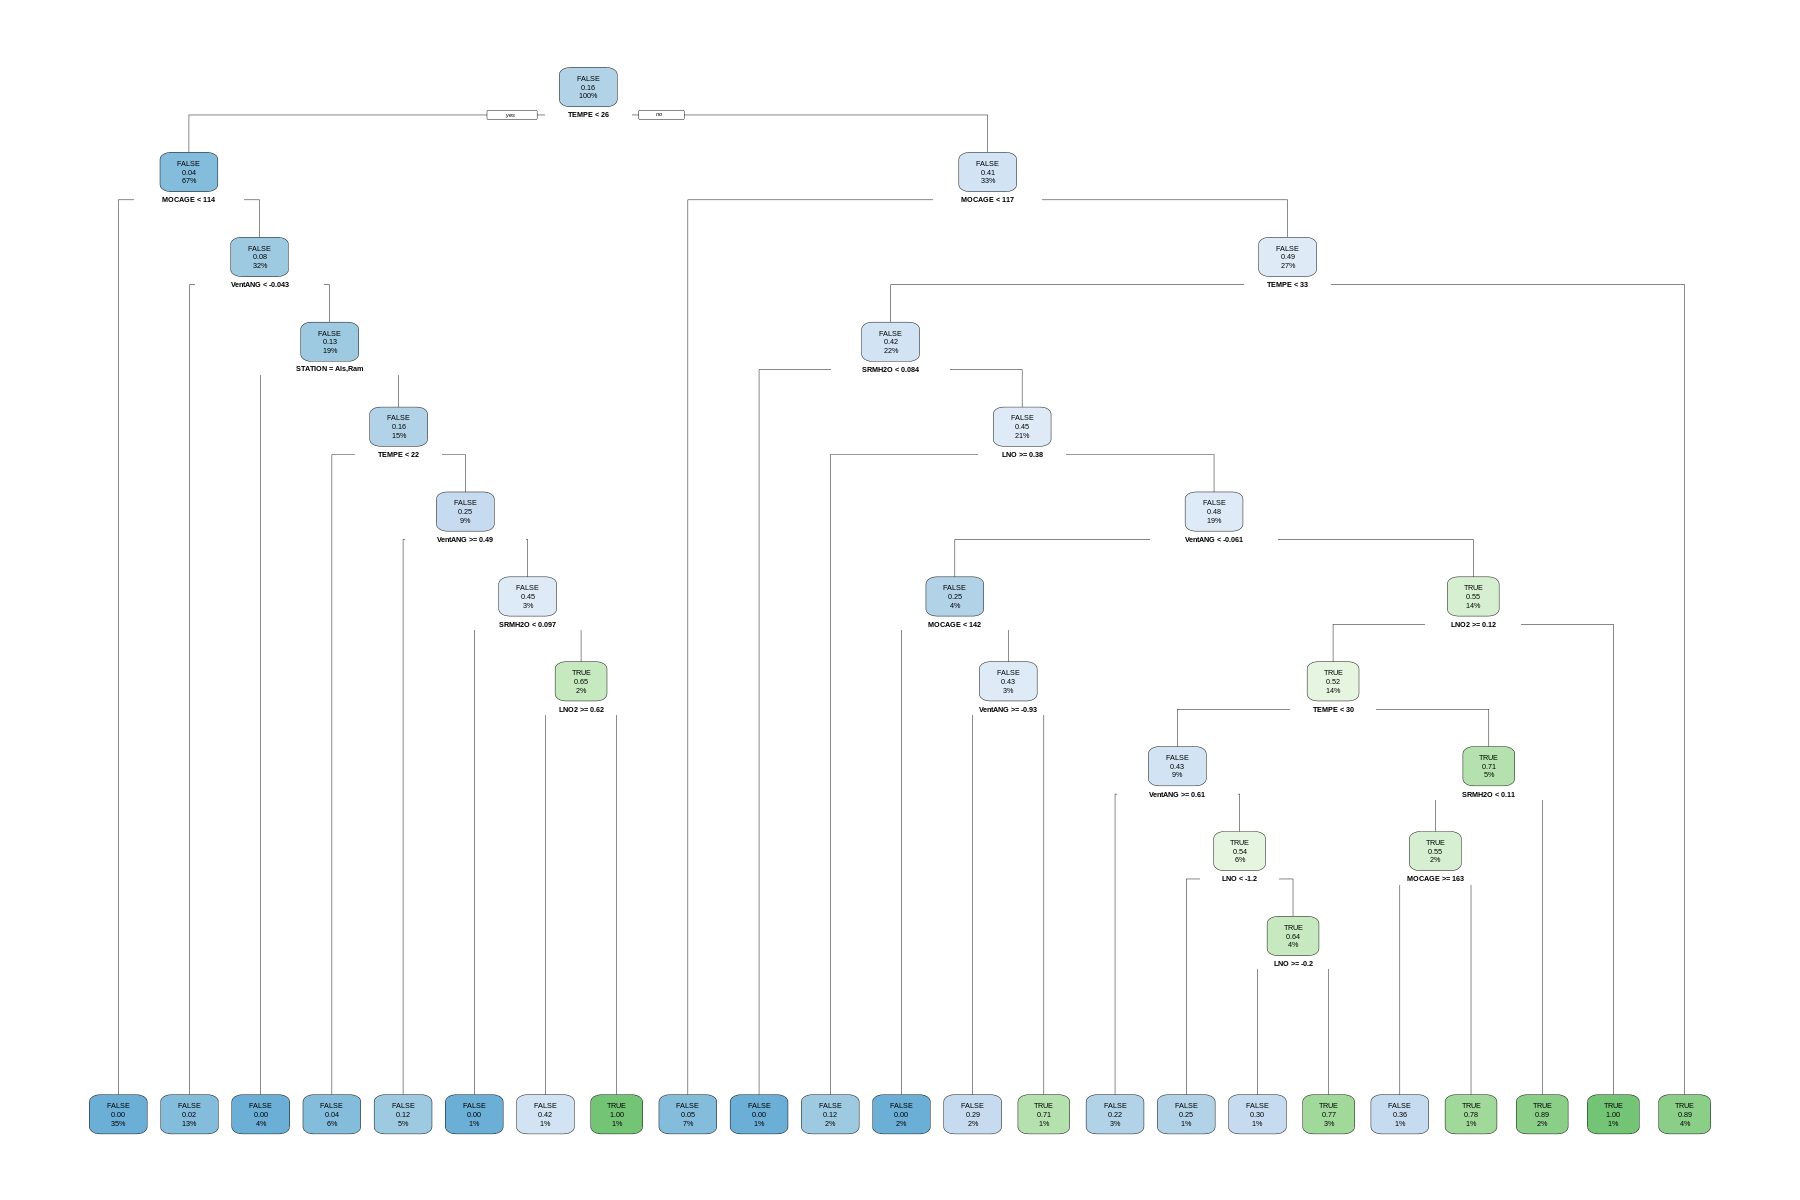

In [89]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),cp=0.001)
rpart.plot(tree.dis)

La même procédure d'élagage par validation croisée est mise en place mais avec une expression différente de l'erreur de prévision: taux de mal classés plutôt qu'erreur quadratique.

In [90]:
xmat = xpred.rpart(tree.dis)
# Comparaison des valeurs prédite et observée
xerr=datappq$DepSeuil!= (xmat>1.5)
# Calcul  des estimations des taux d'erreur
CVerr=apply(xerr, 2, sum)/nrow(xerr)
CVerr

0.534825871 0.045597768 0.018279774 0.009139887 0.002731792 
  0.1610577   0.1526442   0.1430288   0.1514423   0.1490385

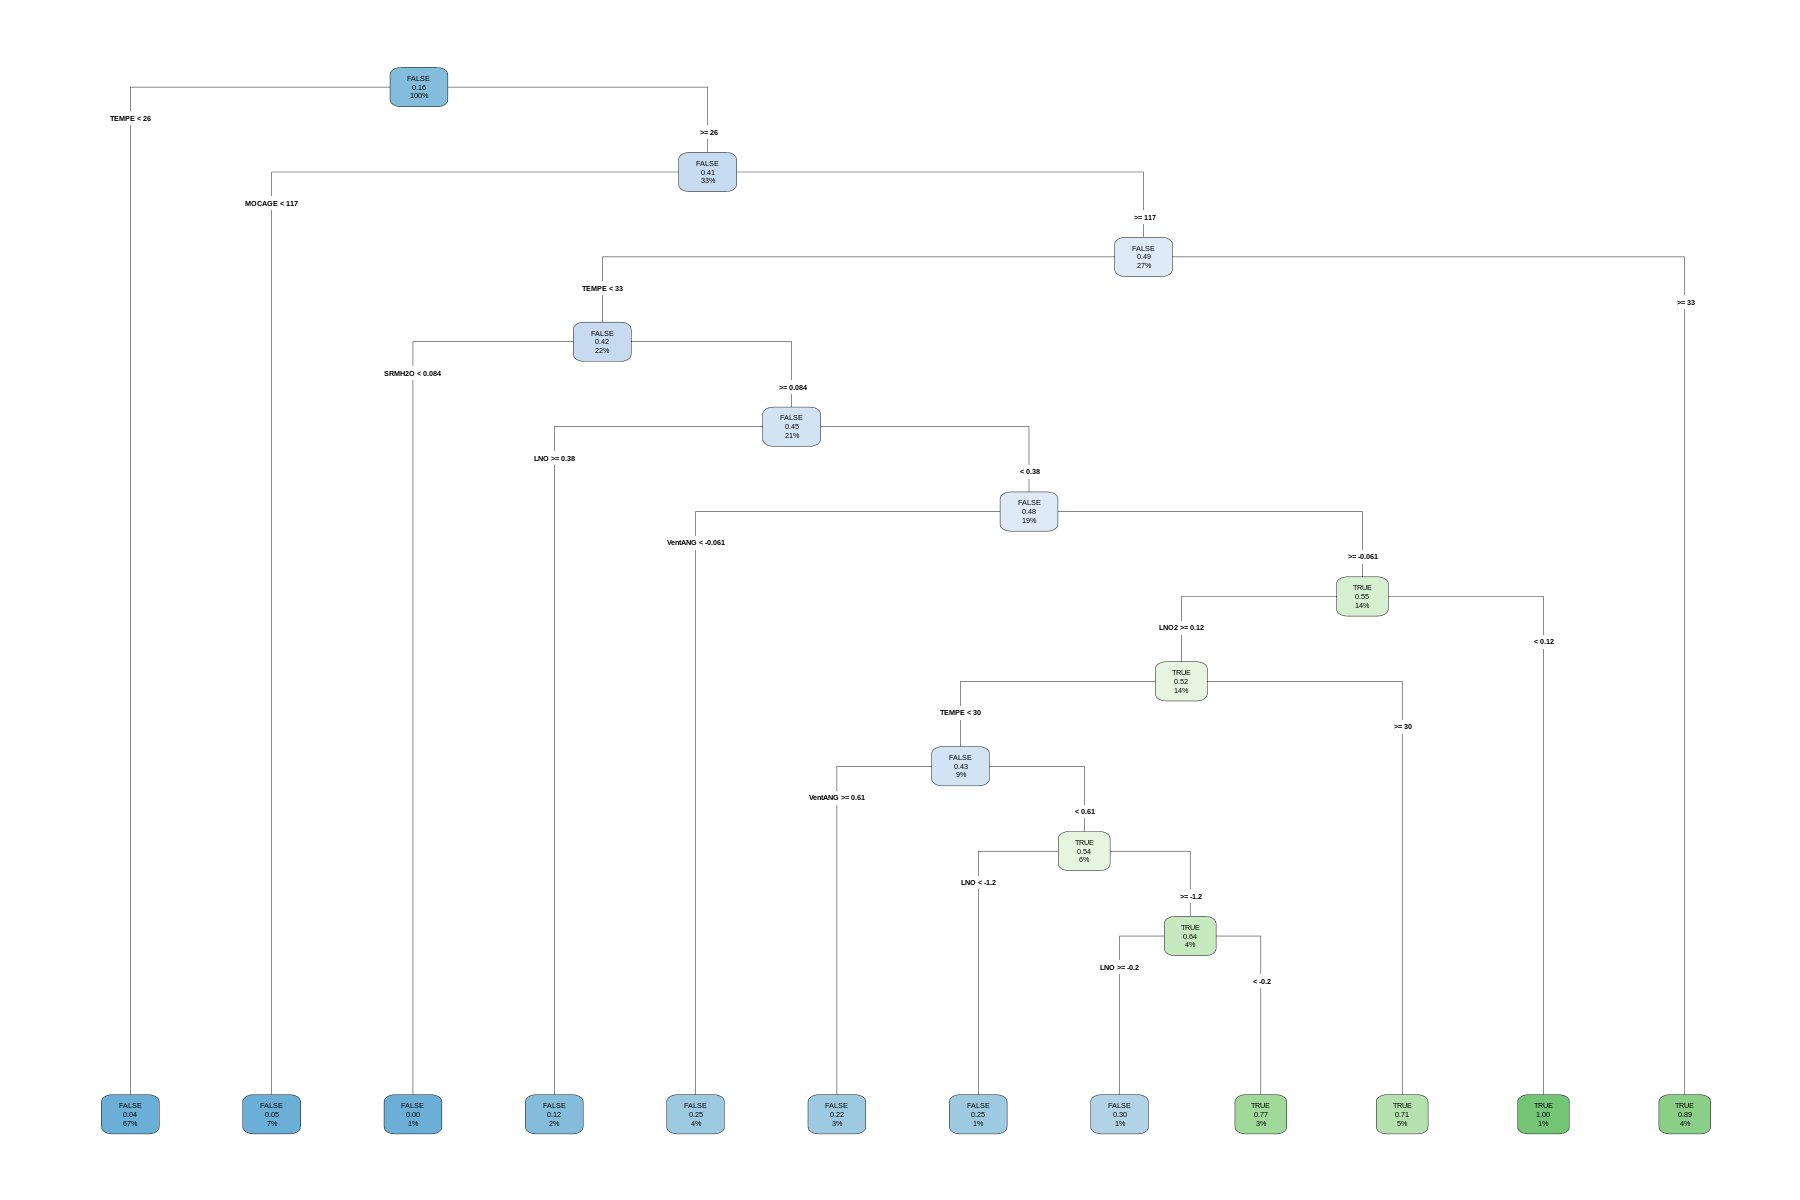

In [91]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),cp=as.numeric(attributes(which.min(CVerr))$names))
rpart.plot(tree.dis,type=4)

Avec la librairie `caret`:

[1] "Valeur de cp retenue = 0.0267085624509034"


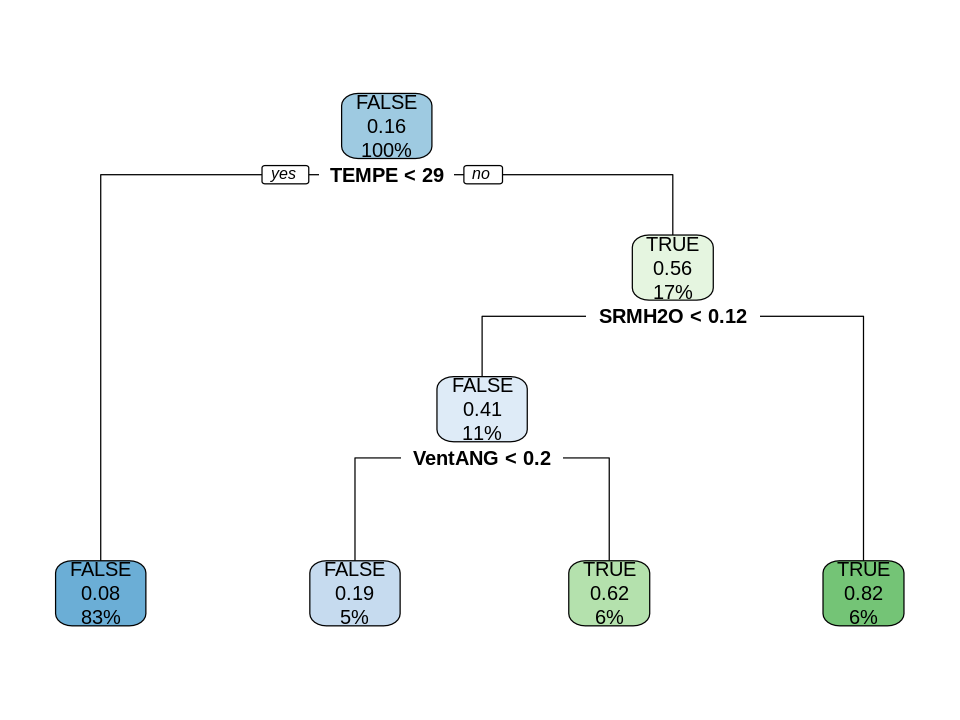

In [98]:
ctrl <- trainControl(method = "cv",number = 10)
treecaret <- train(DepSeuil~.,data=datappq,method = "rpart",trControl = ctrl,tuneLength =20,metric="Accuracy")
print(paste("Valeur de cp retenue = ",treecaret$bestTune,sep=""))
rpart.plot(treecaret$finalModel)

### Prévision de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision.

#### Erreur de régression

In [99]:
# Calcul des prévisions
pred.treer=predict(tree.reg,newdata=datestr)
# Erreur quadratique moyenne de prévision en régression
sum((pred.treer-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 883.3908

#### Erreur de classification (matrice de confusion)

In [94]:
# Matrice de confusion pour la prévision du
# dépassement de seuil (régression)
  #table(pred.treer>150,datestr[,"O3obs"]>150)
confusionMatrix(as.factor(pred.treer>150),as.factor(datestr[,"O3obs"]>150))$table

          Reference
Prediction FALSE TRUE
     FALSE   155   22
     TRUE     10   22

In [100]:
# Même chose pour l'arbre de discrimination
pred.treeq=predict(tree.dis,newdata=datestq,type="class")
  #table(pred.treeq,datestq[,"DepSeuil"])
confusionMatrix(pred.treeq,datestq[,"DepSeuil"])$table

          Reference
Prediction FALSE TRUE
     FALSE   157   25
     TRUE      8   19

:**Question** Quelle stratégie semble meilleure à ce niveau ?

Arbre de classification, car elle permet de modéliser directement le dépassement du seuil d'ozone (DepSeuil), ce qui est l'objectif principal. L'arbre de régression, bien qu'il donne des prédictions continues, introduit une complexité inutile lorsqu'il s'agit de classifier des dépassements de seuils.

#### Courbes ROC

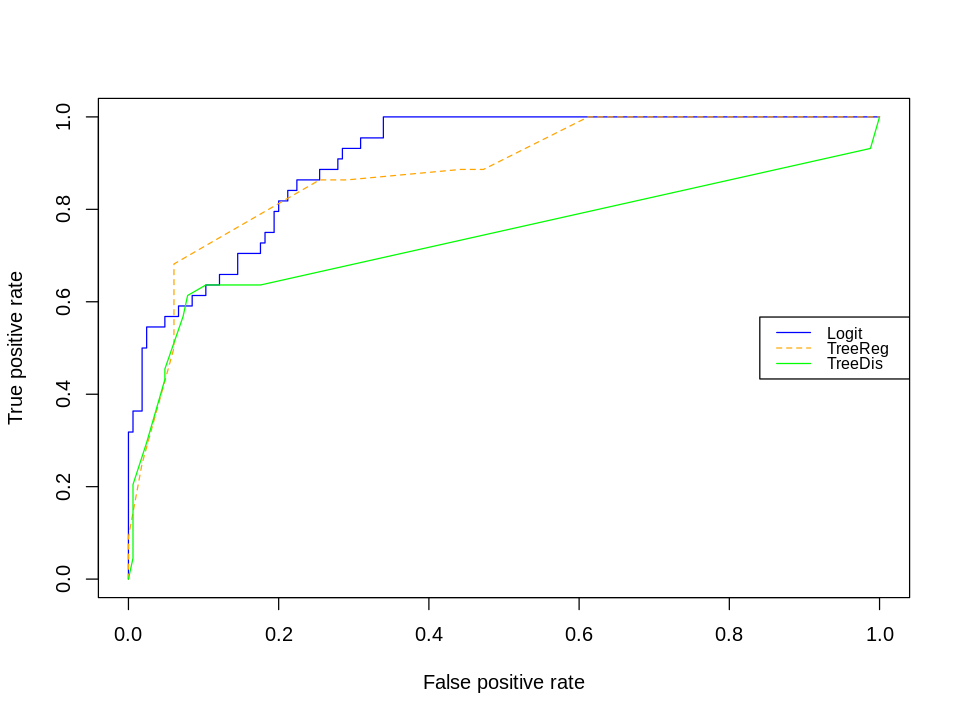

In [101]:
ROCregtree=pred.treer/300
predregtree=prediction(ROCregtree,datestq$DepSeuil)
perfregtree=performance(predregtree,"tpr","fpr")
ROCdistree=predict(tree.dis,newdata=datestq,type="prob")[,2]
preddistree=prediction(ROCdistree,datestq$DepSeuil)
perfdistree=performance(preddistree,"tpr","fpr")
# tracer les courbes ROC en les superposant
# pour mieux comparer

options(repr.plot.width = 8, repr.plot.height = 6)
plot(perflogit,col="blue")
plot(perfregtree,col="orange",lty=2,add=TRUE)
plot(perfdistree,col="green",add=TRUE)

legend("right", legend=c("Logit", "TreeReg", "TreeDis"),
       col=c("blue","orange","green"), lty=c(1,2,1), text.font=1,    cex=0.8)


**Question** Comparez les qualités de prévision. Une meilleure méthode se dégage-t-elle ?

La régression logistique (Logit) semble être la méthode avec la meilleure capacité de prévision, suivie de près par l'arbre de régression (TreeReg). L'arbre de classification (TreeDis) est clairement moins performant sur cette évaluation, comme l'indique sa courbe ROC.

## [Agrégation de modèles](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

### Introduction
Les sections précédentes ont permis d'expérimenter les constructions d'un modèle de prévision assorties du problème récurrent lié à l'optimisation de la complexité d'un modèle. Cette section aborde d'autres stratégies dont l'objectif est de s'affranchir de ce problème de choix par des méthodes se montrant très peu sensibles au sur-apprentissage ; c'est le cas des algorithmes d'agrégation de modèles.

Cette section propose de mettre en évidence la plus ou moins grande influence des paramètres de ces méthodes.

* *Random forest* : nombre d'arbres et `mtry` et intérêt des critères de Breiman permettant de mesurer l'influence des variables au sein d'une famille agrégée de modèles.

* *Boosting* : profondeur d'arbre, nombre d'itérations ou d'arbres et coefficient de *shrinkage*.



### Forêts aléatoires
Le programme est disponible dans la librairie `randomForest`. Il est écrit en fortran, donc en principe efficace en terme de rapidité d'exécution, et facile à utiliser grâce à une interface avec R. La comparaison avec Python montre qu'il n'est finalement pas très efficace sans doute à cause de l'interface avec R. Les paramètres et sorties sont explicités dans l'aide en ligne.

En R et pour des gros fichiers, privilégier la librairie `ranger` à la place de `randomForest`.

**Question** Quel est le paramètre `mtry` de la fonction `randomForest`?

**Question** En quoi le bagging est un cas particulier des forêts aléatoires ?
Le bagging ne sera pas traité dans ce TP.


In [ ]:
library(randomForest)
help(randomForest)

#### Régression

In [ ]:

rf.reg=randomForest(O3obs~., data=datappr,xtest=datestr[,-2],ytest=datestr[,"O3obs"],
   ntree=500,do.trace=50,importance=TRUE)
attributes(rf.reg)
rf.reg$mtry

**Question** Quelles est la valeur par défaut de `mtry` ?

Relancez en faisant varier les paramètres `mtry` et `ntree` pour expérimenter leur peu d'influence sur les erreurs.

Calcul et graphe des résidus.

In [ ]:
fit.rfr=rf.reg$predicted
res.rfr=fit.rfr-datappr[,"O3obs"]
gplot.res(fit.rfr,res.rfr,titre="")

#### Discrimination
**Question** Quelle est la valeur par défaut de `mtry`?

In [ ]:
rf.dis=randomForest(DepSeuil~.,data=datappq,xtest=datestq[,-10],ytest=datestq[,
   "DepSeuil"],ntree=500,do.trace=50,importance=TRUE)
rf.dis$importance

In [ ]:
rf.dis$mtry

**Question** Commentez les erreurs, testez d'autres exécutions avec d'autres valeurs des paramètres.

### Importance des variables
Le modèle obtenu est ininterprétable mais des coefficients estiment les contributions des variables dans leur participation à la discrimination. Comparer avec les variables sélectionnées par les autres modèles dans l'épisode 1. Deux critères d'importance sont proposés.

**Question** Quelles sont les deux mesures d'importance des variables ?

In [ ]:
sort(round(importance(rf.reg), 2)[,1], decreasing=TRUE)
sort(round(importance(rf.dis), 2)[,4], decreasing=TRUE)

In [ ]:
varImpPlot(rf.reg)

In [ ]:
varImpPlot(rf.dis)

In [ ]:
library(ggRandomForests)
plot(gg_vimp(rf.reg))
plot(gg_vimp(rf.dis))

### Prévision de l'échantillon test

#### En régression

In [ ]:
# Forêts aléatoires
pred.rfr=rf.reg$test$predicted
# Erreur quadratique moyenne de prévision
sum((pred.rfr-datestr[,"O3obs"])^2)/nrow(datestr)

In [ ]:
# Forêts aléatoires
# Matrice de confusion pour la prévision du
# dépassement de seuil (régression)
table(pred.rfr>150,datestr[,"O3obs"]>150)

#### En classification

In [ ]:
pred.rfq=rf.dis$test$predicted
table(pred.rfq,datestq[,"DepSeuil"])
confusionMatrix(pred.rfq,datestq[,"DepSeuil"],positive="TRUE")

**Question** Qu'indique la comparaison des courbes ROC ?

### Boosting

Deux librairies proposent des versions relativement  sophistiquées des algorithmes de *boosting* dans R. La librairie *boost* propose 4 approches : *adaboost, bagboost* et deux *logitboost*. Développée pour une problématique particulière: l'analyse des données d'expression génomique, elle n'est peut-être pas complètement adaptée aux données étudiées ; elle se limite à des prédicteurs quantitatifs et peut fournir des résultats étranges. La librairie *gbm* lui est préférée ; elle offre aussi plusieurs versions dépendant de la fonction coût choisie. Une librairie plus récente `xgboost` intègre des fonctionnalités de parallélisation (pas sous Windows) et fait intervenir plusieurs autres paramètres.

La variable à prévoir doit être codée numériquement (0-1) pour cette implémentation. Le nombre d'itérations, ou nombre d'arbres, est paramétré ainsi qu'un coefficient de rétrécissement (*shrinkage*).

**Question** Comment intervient le *shrinkage* en *boosting*?

**Question** Pour quel boosting? Ou que signifie `gbm`?

*Attention*, par défaut, ce paramètre a une valeur très faible (0.001) et il faut un nombre important d'itérations (d'arbres) pour atteindre une estimation raisonnable. La qualité est visualisée par un graphe représentant l'évolution de l'erreur d'apprentissage. D'autre part, une procédure de validation croisée est incorporée afin d'optimiser le nombre d'arbres car la version de *boosting* considérée est (légèrement) sujette au sur-apprentissage.

#### Régression

In [ ]:
class(ozone$STATION)

In [ ]:
library(gbm)
boost.reg = gbm(O3obs ~ ., data = datappr, distribution = "gaussian", n.trees = 500,
    cv.folds = 10, n.minobsinnode = 5, shrinkage = 0.03, verbose = FALSE)
# fixer verbose à FALSE pour éviter trop de sorties
plot(boost.reg$cv.error, type = "l")

In [ ]:
# nombre optimal d'itérations par valiation croisée
best.iter=gbm.perf(boost.reg,method="cv")

On peut s'assurer de l'absence d'un phénomène de sur-apprentissage critique en calculant puis traçant l'évolution de l'erreur sur l'échantillon test en fonction du nombre d'arbre dans le modèle. L'erreur reste stable autour du nombre d'arbres sélectionné et matérialisé par la ligne verticale.

**Question** Testez ces fonctions en faisant varier le coefficient de rétrécissement.

In [ ]:
test=numeric()
for (i in 10:500){
pred.test=predict(boost.reg,newdata=datestr,n.trees=i)
err=sum((pred.test-datestr[,"O3obs"])^2)/nrow(datestr)
test=c(test,err)}
plot(10:500,test,type="l")
abline(v=best.iter)

#### Discrimination
Attention, la variable à modéliser doit être codée $(0, 1)$ et il faut préciser un autre paramètre de distribution pour considérer le bon terme d'erreur.

In [ ]:
datappq2=datappq
datappq2[,"DepSeuil"]=as.numeric(datappq[,"DepSeuil"])-1
boost.dis=gbm(DepSeuil~.,data=datappq2,distribution="adaboost",n.trees=500, cv.folds=10,
              n.minobsinnode = 5,shrinkage=0.03,verbose=FALSE)
plot(boost.dis$cv.error,type="l")

In [ ]:
# nombre optimal d'itérations
best.ited=gbm.perf(boost.dis,method="cv")

Comme pour la régression, il est possible de faire varier le coefficient de rétrécissement en l'associant au nombre d'arbres dans le modèle.

Calcul des résidus et graphe.

In [ ]:
fit.boostr=boost.reg$fit
res.boostr=fit.boostr-datappr[,"O3obs"]
gplot.res(fit.boostr,res.boostr,titre="")

### Prévision de l'échantillon test

#### Erreur de régression

In [119]:
 pred.boostr=predict(boost.reg,newdata=datestr,n.trees=best.iter)
# Erreur quadratique moyenne de prévision
sum((pred.boostr-datestr[,"O3obs"])^2)/nrow(datestr)

ERROR: Error: object 'boost.reg' not found


#### Erreur de classification (matrices de confusion)

In [ ]:
# Matrice de confusion pour la prévision
# du dépassement de seuil (régression)
table(pred.boostr>150,datestr[,"O3obs"]>150)

In [ ]:
# Même chose pour la discrimination
pred.boostd=predict(boost.dis,newdata=datestq,n.trees=best.ited)
table(as.factor(sign(pred.boostd)),datestq[,"DepSeuil"])


#### Courbes ROC

In [ ]:
# Forêts aléatoires
rocrfr=pred.rfr/300
predrfr=prediction(rocrfr,datestq$DepSeuil)
perfrfr=performance(predrfr,"tpr","fpr")

# Boosting
rocbstr=pred.boostr/300
predbstr=prediction(rocbstr,datestq$DepSeuil)
perfbstr=performance(predbstr,"tpr","fpr")

# tracer les courbes ROC en les superposant
# pour mieux comparer
plot(perflogit,col="blue")
plot(perfrfr,col="purple",lty=2,add=TRUE)
plot(perfbstr,col="green",add=TRUE)

legend("right", legend=c("Logit","RF", "Boosting"),
       col=c("blue","purple","green"), lty=c(1,2,1), text.font=1,    cex=0.8)

**Question** Quelle  stratégie d'agrégation de modèles vous semble fournir le meilleur résultat de prévision?

**Question** Est-elle, sur ce jeu de données, plus efficace que les modèles classiques expérimentés auparavant ?

# <FONT COLOR="Red">Épisode 4 : Réseaux de neurones </font>

## [Réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf)

### Introduction

Il s'agit d'estimer un modèle de type *perceptron* avec en entrée les variables qualitatives ou quantitatives et en sortie la variable à prévoir. Des fonctions R pour l'apprentissage d'un perceptron élémentaire ont été réalisées par différents auteurs et sont accessibles sur le réseau. La librairie `nnet` de (Ripley, 1999), est limitée au perceptron à une couche. Ce n'est pas de l'*apprentissage profond* ! mais suffisant dans bien des cas. Une librairie R associée au logiciel éponyme H2O propose des réseaux à plusieurs couches et "convolutionnels".

Comme pour les arbres, la variable à expliquer est soit quantitative soit qualitative ; la fonction de transfert du neurone de sortie d'un réseau doit être adaptée en conséquence.

**Question** Quelle fonction de transfert est utilisée pour le dernier neurone en régression ? en classification  binaire? en classification multiclasse ?

Fonction de transfert utilisée pour le dernier neurone :

    Régression : Fonction linéaire (ou identité).
    Classification binaire : Fonction sigmoïde.
    Classification multiclasse : Fonction softmax.

**Question** Quel est le choix par défaut pour les neurones de la couche cachée?

Choix par défaut pour les neurones de la couche cachée :

    Les fonctions d'activation par défaut sont souvent sigmoïde ou tangente hyperbolique (tanh).

Différentes stratégies sont proposées pour éviter le sur-apprentissage. La première consiste à optimiser le nombre de neurones sur la couche cachée. Très approximativement il est d'usage de considérer, qu'en moyenne, il faut une taille d'échantillon d'apprentissage 10 fois supérieure au nombre de poids c'est-à-dire au nombre de paramètres à estimer. On remarque qu'ici la taille de l'échantillon d'apprentissage (832) est modeste pour une application raisonnable du perceptron. Seuls des nombres restreints de neurones peuvent être considérés et sur une seule couche cachée.

**Question** Quel est le paramètre `decay` de la fonction `nnet`?
    Paramètre decay de la fonction nnet : Le paramètre decay est utilisé pour appliquer une régularisation L2 (ou pénalisation) sur les poids du réseau afin de contrôler leur taille et éviter le sur-apprentissage.

**Question** Indiquez une autre façon d'éviter le sur-apprentissage.

    Autre façon d'éviter le sur-apprentissage : Une autre stratégie est l'arrêt précoce (early stopping),
    qui consiste à arrêter l'entraînement lorsque la performance sur les données de validation cesse de s'améliorer.

### Cas de la régression

In [102]:
library(MASS)
library(nnet)
# apprentissage
# attention au paramètre linout dans le cas de la régression
nnet.reg=nnet(O3obs~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500)
summary(nnet.reg)

# weights:  71
initial  value 12358208.941949 
iter  10 value 1400049.874842
iter  20 value 1376626.286703
iter  30 value 1331152.189251
iter  40 value 1152398.455792
iter  50 value 1063784.950283
iter  60 value 1026559.696753
iter  70 value 884431.915432
iter  80 value 667329.574631
iter  90 value 641239.569250
iter 100 value 617081.337701
iter 110 value 604605.993910
iter 120 value 580426.787278
iter 130 value 562304.841679
iter 140 value 548428.328043
iter 150 value 536622.445327
iter 160 value 527167.500519
iter 170 value 513971.593499
iter 180 value 508509.880631
iter 190 value 504598.008730
iter 200 value 499105.511284
iter 210 value 495617.527627
iter 220 value 493059.694078
iter 230 value 490485.357487
iter 240 value 486068.496534
iter 250 value 477983.834906
iter 260 value 471135.432200
iter 270 value 468112.212182
iter 280 value 465789.925167
iter 290 value 463867.874894
iter 300 value 463734.294556
iter 310 value 462714.968811
iter 320 value 461670.071594
iter 330 value 4608

a 12-5-1 network with 71 weights
options were - linear output units  decay=1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
 -18.78    2.12    0.17    1.46    6.08    4.10   -2.19   -6.96   -0.74   -9.44 
i10->h1 i11->h1 i12->h1 
  14.27  -22.01   16.88 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
 -23.62    0.17    0.23    0.63   -4.40   -4.45   -0.37   -4.57   -0.87   13.00 
i10->h2 i11->h2 i12->h2 
   0.71  -10.51   10.58 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
  15.41   -8.21    0.03    1.37  -10.36    1.71    2.69   -2.70    1.46   -2.47 
i10->h3 i11->h3 i12->h3 
 -29.89  -23.44   26.13 
  b->h4  i1->h4  i2->h4  i3->h4  i4->h4  i5->h4  i6->h4  i7->h4  i8->h4  i9->h4 
 -11.17  -17.45   -1.72    5.04   -3.64   12.04  -19.71    4.79    7.51    8.61 
i10->h4 i11->h4 i12->h4 
   1.51    7.06  -17.05 
  b->h5  i1->h5  i2->h5  i3->h5  i4->h5  i5->h5  i6->h5  i7->h5  i8->h5  i9

La commande donne la "trace" de l'exécution avec le comportement de la convergence mais le détail des poids de chaque entrée de chaque neurone ne constitue pas un résultats très explicite !

**Question** Contrôlez le nombre de poids estimés.

L'optimisation des paramètres nécessite encore le passage par la validation croisée. Il n'y a pas de fonction dans la librairie `nnet` permettant de le faire mais la fonction ` tune.nnet` de la librairie `e1071` est adaptée à cette démarche.

In [105]:
summary(nnet.reg)

a 12-3-1 network with 43 weights
options were - linear output units  decay=2
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
  -3.98    0.38    0.07    0.17    0.55   -0.50    0.88    1.85   -0.20    1.43 
i10->h1 i11->h1 i12->h1 
 -22.65   -3.42    3.27 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
 -18.00    0.53   -0.01    0.41    0.84    0.79    2.63    0.22   -0.11    0.28 
i10->h2 i11->h2 i12->h2 
  28.47    2.31   -2.01 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
   8.80   -4.11    0.08    0.47   -4.38    0.88   -1.87   -5.76   -0.10   -1.93 
i10->h3 i11->h3 i12->h3 
 -16.06  -13.56   13.67 
  b->o  h1->o  h2->o  h3->o 
 55.60  42.49  85.24  31.70 

In [106]:
# Charger la librairie nécessaire
library(e1071)

# Définir les plages de paramètres à tester
tune_results <- tune.nnet(
  O3obs ~ .,
  data = datappr,
  size = c(1, 5, 10),  # Exemple : tester pour 1, 5, et 10 neurones cachés
  decay = c(0, 0.01, 0.1, 1),  # Exemple : tester différentes valeurs de decay
  linout = TRUE,  # Indiquer que c'est une régression
  maxit = 500,    # Nombre maximum d'itérations
  tunecontrol = tune.control(sampling = "cross", cross = 10)  # Validation croisée à 10 plis
)

# Afficher les résultats
print(tune_results)



Parameter tuning of ‘nnet’:

- sampling method: 10-fold cross validation 

- best parameters:
 size decay
    5     1

- best performance: 731.8137 



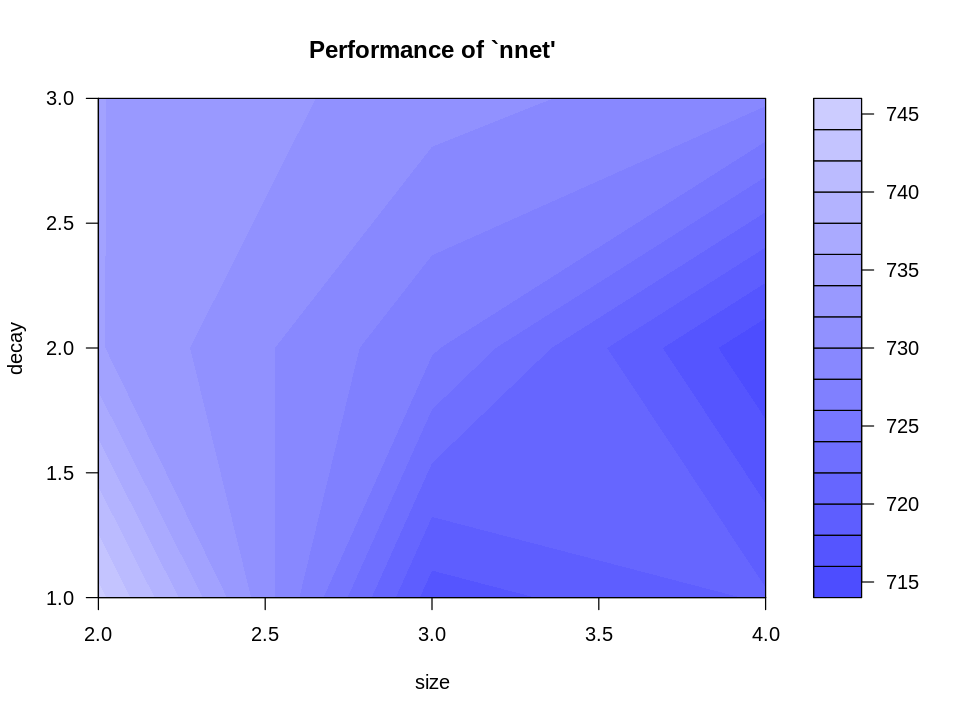

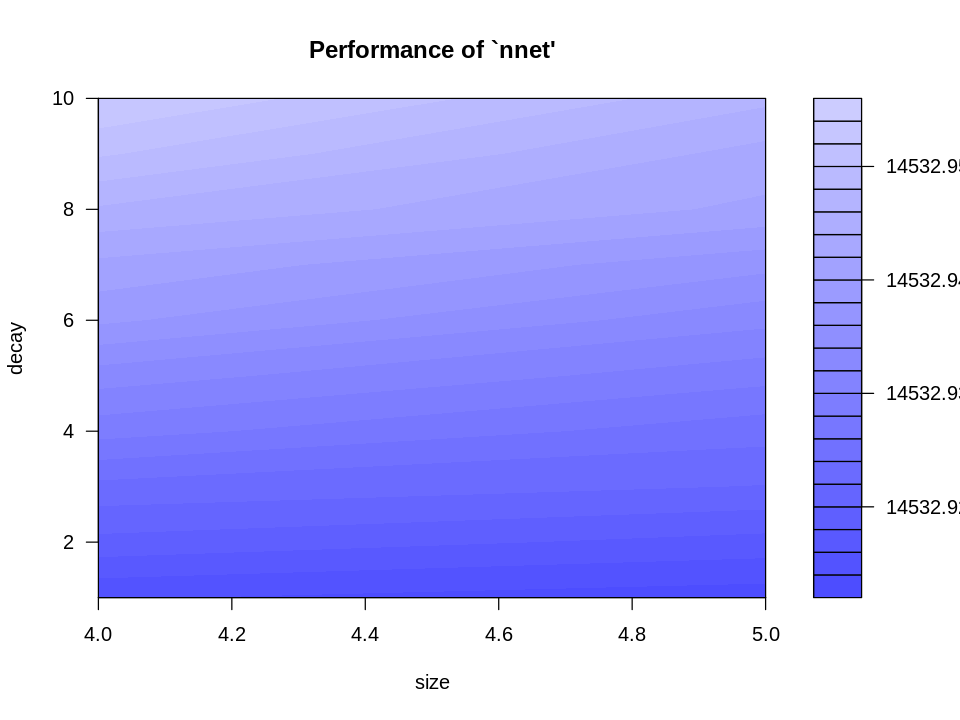

In [107]:
library(e1071)
plot(tune.nnet(O3obs~.,data=datappr,size=c(2,3,4),decay=c(1,2,3),maxit=200,linout=TRUE))
plot(tune.nnet(O3obs~.,data=datappr,size=4:5,decay=1:10))

Faire éventuellement varier la grille des paramètres (zoom), notez la taille et le `decay` optimaux. Il faudrait aussi  faire varier le nombre total d'itérations. Cela risque de prendre un peu de temps ! Notez également que chaque exécution donne des résultats différents... il n'est donc pas très utile d'y passer beaucoup de temps !

**Question** Ré-estimez le modèle supposé optimal avant de tracer le graphe des résidus.

In [108]:
## reponse question precedant

# Supposons que les meilleurs paramètres trouvés sont size = 4 et decay = 1
optimal_size <- 4
optimal_decay <- 1

# Ré-estimer le modèle avec les paramètres optimaux
nnet_optimal <- nnet(O3obs ~ ., data = datappr, size = optimal_size, decay = optimal_decay, linout = TRUE, maxit = 500)

# Afficher le résumé du modèle
summary(nnet_optimal)

# weights:  57
initial  value 12170514.524853 
iter  10 value 1306422.549211
iter  20 value 1138342.646926
iter  30 value 914249.462442
iter  40 value 769884.301568
iter  50 value 730165.766559
iter  60 value 709370.853446
iter  70 value 685503.074216
iter  80 value 663783.390901
iter  90 value 658194.075887
iter 100 value 573719.445154
iter 110 value 555145.131075
iter 120 value 551670.933188
iter 130 value 551485.963508
iter 140 value 551403.360692
iter 150 value 551389.903948
iter 160 value 550347.525987
iter 170 value 549770.645650
iter 180 value 548744.703033
iter 190 value 547382.677858
iter 200 value 529563.394949
iter 210 value 510741.771727
iter 220 value 505637.030303
iter 230 value 480879.463658
iter 240 value 469333.917389
iter 250 value 465649.365522
iter 260 value 465255.414506
iter 270 value 465035.500000
iter 280 value 464575.721035
iter 290 value 463501.954563
iter 300 value 462982.284851
iter 310 value 462234.928055
final  value 462225.392315 
converged


a 12-4-1 network with 57 weights
options were - linear output units  decay=1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
 -23.72    0.49   -0.03    0.60   -0.77    0.95    3.36   -1.10   -0.46    0.14 
i10->h1 i11->h1 i12->h1 
  41.44    3.92   -3.95 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
   3.61   -0.64    0.04    0.15   -2.14   -0.10   -2.79   -0.80    0.27    0.38 
i10->h2 i11->h2 i12->h2 
 -19.00   -5.22    4.75 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
  15.15   -6.17    0.22   -2.33   36.04  -20.14   11.69  -12.46    4.57   -7.36 
i10->h3 i11->h3 i12->h3 
   9.22   18.87    3.96 
  b->h4  i1->h4  i2->h4  i3->h4  i4->h4  i5->h4  i6->h4  i7->h4  i8->h4  i9->h4 
  -4.43    0.69    0.03    0.24    0.49    1.96    3.90    0.70   -0.56    0.22 
i10->h4 i11->h4 i12->h4 
  -9.57   -0.53    0.48 
  b->o  h1->o  h2->o  h3->o  h4->o 
 -4.20  71.84  61.34  30.74  54.87 

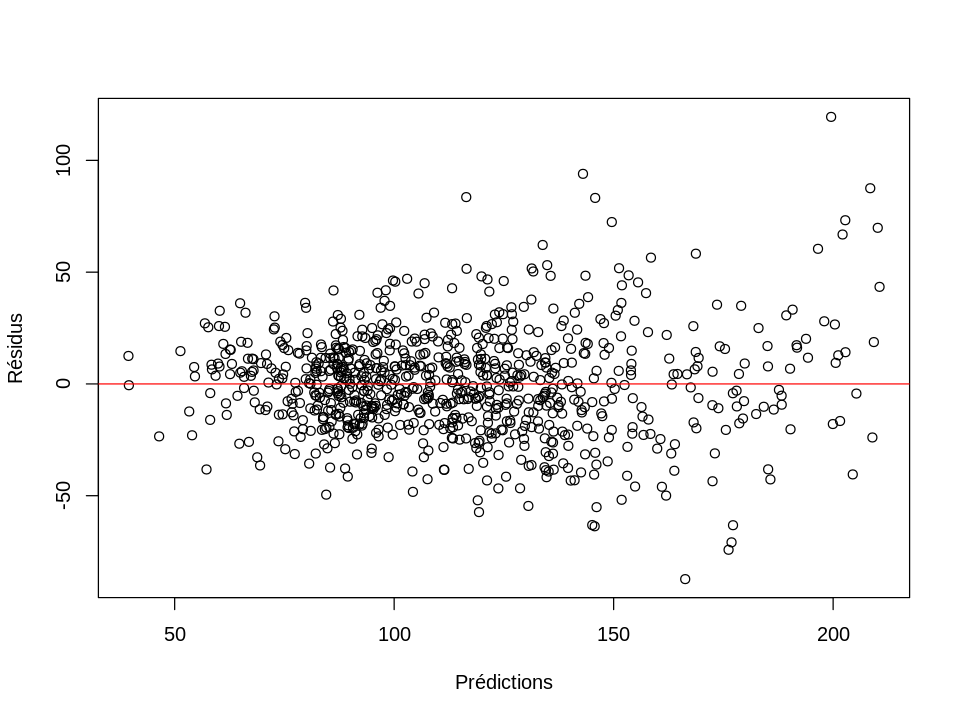

In [109]:
# reponse question precedant
# Prédictions du modèle
predictions <- predict(nnet_optimal, newdata = datappr)

# Calcul des résidus
residuals <- datappr$O3obs - predictions

# Tracer le graphique des résidus
plot(predictions, residuals, xlab = "Prédictions", ylab = "Résidus")
abline(h = 0, col = "red")  # Ligne horizontale à zéro


# weights:  43
initial  value 12283244.819533 
iter  10 value 1321290.513144
iter  20 value 1150312.965697
iter  30 value 1081889.220363
iter  40 value 982172.087448
iter  50 value 891717.271338
iter  60 value 811408.219962
iter  70 value 670277.371717
iter  80 value 640320.384958
iter  90 value 628706.821878
iter 100 value 618665.986811
iter 110 value 612595.455410
iter 120 value 607136.900101
iter 130 value 586693.422935
iter 140 value 573852.560924
iter 150 value 566638.026006
iter 160 value 559978.612136
iter 170 value 543362.879005
iter 180 value 536771.202911
iter 190 value 535749.499278
iter 200 value 533016.319947
final  value 533016.319947 
stopped after 200 iterations


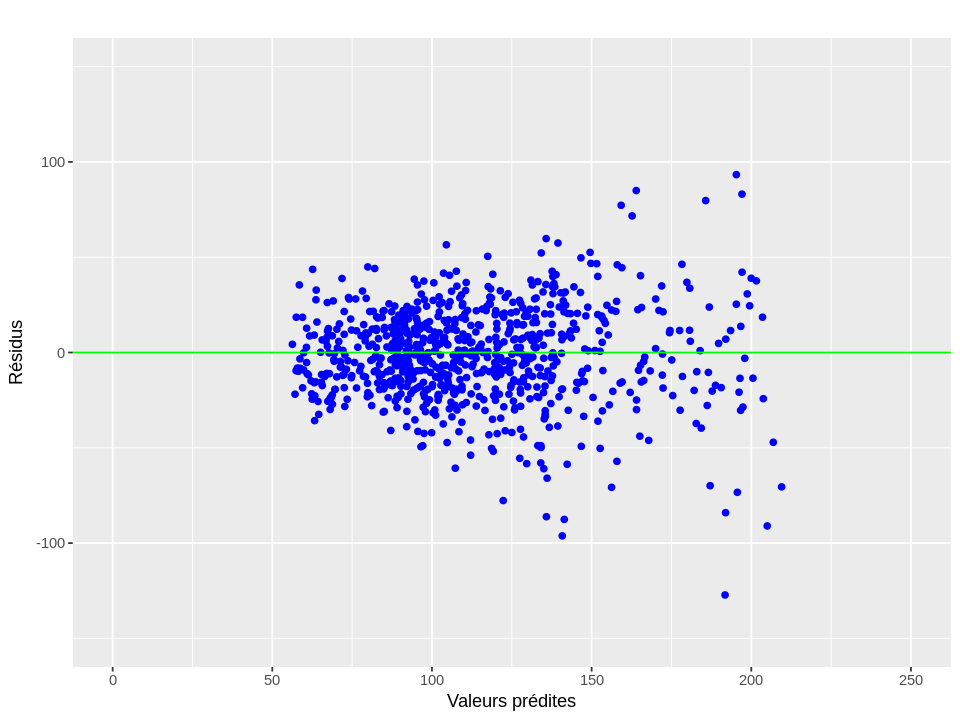

In [104]:
nnet.reg=nnet(O3obs~.,data=datappr,size=3,decay=2,linout=TRUE,maxit=200)
# calcul et graphe des résidus
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"O3obs"]
gplot.res(fit.nnetr,res.nnetr,titre="")

### Cas de la discrimination

In [110]:
# apprentissage
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=0)
summary(nnet.reg)

# weights:  71
initial  value 1181.375251 
final  value 367.261124 
converged


a 12-3-1 network with 43 weights
options were - linear output units  decay=2
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
  -3.98    0.38    0.07    0.17    0.55   -0.50    0.88    1.85   -0.20    1.43 
i10->h1 i11->h1 i12->h1 
 -22.65   -3.42    3.27 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
 -18.00    0.53   -0.01    0.41    0.84    0.79    2.63    0.22   -0.11    0.28 
i10->h2 i11->h2 i12->h2 
  28.47    2.31   -2.01 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
   8.80   -4.11    0.08    0.47   -4.38    0.88   -1.87   -5.76   -0.10   -1.93 
i10->h3 i11->h3 i12->h3 
 -16.06  -13.56   13.67 
  b->o  h1->o  h2->o  h3->o 
 55.60  42.49  85.24  31.70 

La validation croisée est toujours nécessaire afin de tenter d'optimiser les choix en présence : nombre de neurones, `decay` et éventuellement le nombre maximal d'itérations.

L'initialisation de l'apprentissage d'un réseau de neurone comme celle de l'estimation de l'erreur par validation croisée sont aléatoires. Chaque exécution donne donc des résultats différents. À ce niveau, il serait intéressant de construire un plan d'expérience à deux facteurs (ici, les paramètres de taille et `decay`) de chacun trois niveaux. Plusieurs réalisations pour chaque combinaison des niveaux suivies d'un test classique d'anova permettraient de se faire une idée plus juste de l'influence de ces facteurs sur l'erreur.

**Question** Notez la taille et le `decay` optimaux et ré-estimez le modèle pour ces valeurs.

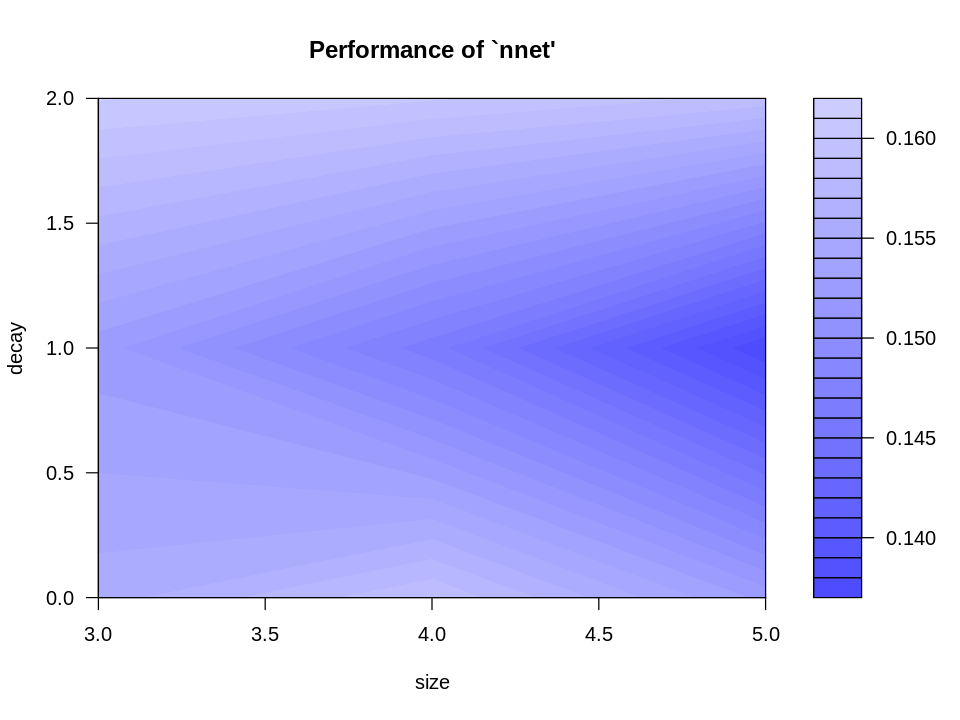

In [111]:
plot(tune.nnet(DepSeuil~.,data=datappq,size=c(3,4,5),decay=c(0,1,2),maxit=200,linout=FALSE))

In [112]:
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=1)

# weights:  71
initial  value 884.222035 
iter  10 value 436.738259
iter  20 value 357.011850
iter  30 value 314.829920
iter  40 value 298.213430
iter  50 value 287.622429
iter  60 value 281.727834
iter  70 value 278.742634
iter  80 value 278.536365
iter  90 value 278.519773
final  value 278.519714 
converged


### Prévisions de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision.


#### Erreur de régression

In [113]:
# Calcul des prévisions
pred.nnetr=predict(nnet.reg,newdata=datestr)
pred.nnetq=predict(nnet.dis,newdata=datestq)
# Erreur quadratique moyenne de prévision
sum((pred.nnetr-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 707.8038

#### Erreur de classification (matrice de confusion)

In [114]:
# Matrice de confusion pour la prévision du
# dépassement de seuil (régression)
table(pred.nnetr>150,datestr[,"O3obs"]>150)


       
        FALSE TRUE
  FALSE   156   22
  TRUE      9   22

In [115]:

confusionMatrix(as.factor(pred.nnetr>150),as.factor(datestr[,"O3obs"]>150))$table

          Reference
Prediction FALSE TRUE
     FALSE   156   22
     TRUE      9   22

In [116]:
# Même chose pour la discrimination
table(pred.nnetq>0.5,datestq[,"DepSeuil"])


       
        FALSE TRUE
  FALSE   163   34
  TRUE      2   10

#### Courbes ROC

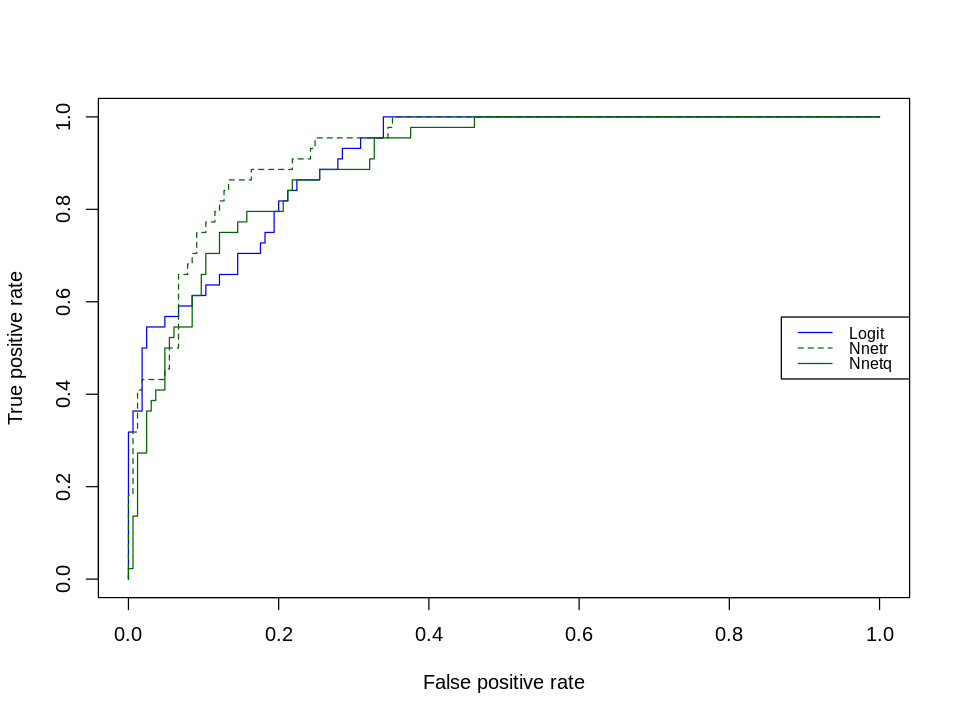

In [118]:
library(ROCR)

roclogit <- predict(log.qm.step1, newdata = datestq, type="response")
predlogit <- prediction(roclogit, datestq[, "DepSeuil"])
perflogit <- performance(predlogit, "tpr", "fpr")

rocnnetr=pred.nnetr/300
prednnetr=prediction(rocnnetr,datestq$DepSeuil)
perfnnetr=performance(prednnetr,"tpr","fpr")

rocnnetq=pred.nnetq
prednnetq=prediction(rocnnetq,datestq$DepSeuil)
perfnnetq=performance(prednnetq,"tpr","fpr")

# tracer les courbes ROC en les superposant pour mieux comparer
plot(perflogit,col="blue")
plot(perfnnetr,col="darkgreen",lty=2,add=TRUE)
plot(perfnnetq,col="darkgreen",add=TRUE)
legend("right", legend=c("Logit", "Nnetr", "Nnetq"),
       col=c("blue","darkgreen", "darkgreen"), lty=c(1,2,1), text.font=1,    cex=0.8)


**Question** Une méthode semble-t-elle significativement meilleure?

En regardant la courbe ROC, il semble que la méthode **Logit** soit significativement meilleure que les méthodes Nnet1 et Nnet2. La courbe ROC de la méthode Logit est plus proche du coin supérieur gauche du graphique, ce qui indique une meilleure capacité de discrimination entre les classes positives et négatives. Cela signifie que pour ce jeu de données ou cette comparaison de modèles, la méthode Logit offre un meilleur compromis entre le taux de vrais positifs et le taux de faux positifs.

# <FONT COLOR="Red"> Épisode 5 :  Industrialisation de l'apprentissage </font>


Un avantage de R est le nombre considérable d'utilisateurs qui participent au développement des librairies. Cet avantage a un revers: le manque d'homogénéité de celles-ci. Pour y remédier dans les applications d'apprentissage machine, la (méta)librairie [`caret`](https://topepo.github.io/caret/) de [Max Kuhn (2008)](https://www.jstatsoft.org/article/view/v028i05) intègre dans un même usage, une même syntaxe, l'ensemble des fonctionnalités d'apprentissage et propose une approche unifiée des procédures d'optimisation des paramètres.

Les instructions suivantes reprennent rapidement les étapes précédentes afin d'introduire l'usage de `caret`. Elles se limitent à l'objectif de prévision de dépassement du seuil (classification). Le code pour modéliser la concentration par régression s'en déduit facilement.

### Calcul parallèle
Par ailleurs, même sous windows, `caret` offre simplement des possibilités de parallélisation en utilisant la package `doParallel`. Même si les algorithmes des différentes méthodes d'apprentissage ne sont pas parallélisés, les itérations des calculs de validation croisée pour l'optimisation des paramètres sont effectivement parallélisés avec un gain de temps très appréciable fonction du nombre de processeurs. Ceci est obtenu en exécutant les commandes suivantes en supposant que 4 processeurs sont disponibles.

In [ ]:
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl)

### Préparation des données
Les données considérées sont les données initiales et la stratégie adoptée pour optimiser les modèles est la validation croisée. D’autres choix sont possibles (bootstrap). La librairie `caret` intègre des fonctions d’échantillonnage et de normalisation des données.

In [ ]:
summary(ozone)

In [ ]:
library(caret)
# extraction des données
# Variable cible
Y=ozone[,"DepSeuil"]
# Variables explicatives
X=ozone[,-c(2,11)]
# Transformation des facteurs en indicatrices pour utiliser certains algorithmes
# notamment xgboost
library(FactoMineR)
X=data.frame(tab.disjonctif(X[,c(1,4)]),X[,-c(1,4)])
summary(Y);summary(X)

In [ ]:
library(caret)

In [ ]:
??caret

In [ ]:
# indices de l’échantillon d’apprentissage
xx=11 # Changer cette valeur pour personnaliser l'échantillonnage
set.seed(xx)
inTrain = createDataPartition(X[,1],p = 0.8, list = FALSE)
# Extraction des échantillons
trainDescr=X[inTrain,]
testDescr=X[-inTrain,]
testY=Y[-inTrain]
trainY=Y[inTrain]

Certaines méthodes sont sensibles à des effets de variance ou d'unité des variables. Il est préférable d'introduire une normalisation.

In [ ]:
# Normalisation calculée sur les paramètres de l'échantillon d'apprentissage
xTrans=preProcess(trainDescr)
trainDescr=predict(xTrans,trainDescr)
# Puis appliquée également à l'échantillon test
testDescr=predict(xTrans,testDescr)
# Choix de la validation croisée
cvControl=trainControl(method="cv",number=10)

### Estimation des modèles
La librairie intègre beaucoup de modèles ou méthodes (233!) et celles qui sont sélectionnées ci-dessous font partie des plus utilisées. Consultez  la   [liste   des   méthodes](http://topepo.github.io/caret/available-models.html)   disponibles   en option   de   la   fonction: `train`.  Le choix est en principe limité également aux méthodes acceptant des variables quantitatives et qualitatives mais, en transformant préalablement les variables qualitatives en paquets d'indicatrices (*dummies*) les autres méthodes sont accessibles. Exécutez chaque bloc de commandes pour tracer séparemment chacun des graphes afin de contrôler le bon comportement
de l’optimisation du paramètre de complexité de chaque modèle.

L'automatisation  de l'optimisation  de  certaines méthodes comme  la régression logistique est moins flexible qu’en utilisation  "manuelle"; en particulier pour le choix de l’algorithme de sélection de variables. Il faut se montrer (très) patient pour certaines optimisations alors que d'autres sont immédiates, voire inutiles.

Le paramètre `tuneLength` caractérise  un "effort" d'optimisation, c'est en gros le nombre de valeurs de paramètres testées sur une grille fixée automatiquement. En prenant plus de soin et aussi plus de temps, il est possible de fixer précisément des grilles pour les valeurs du ou des paramètres optimisés pour chaque méthode. L'approche sommaire de `caret` s'avère souvent suffisante et l'optimisation d'un modèle, de sa complexité et peut être affinée après sélection de la méthode.

**Question** Pour chaque cas, identifiez la méthode, précisez les paramètres associés et notez celui ou ceux optimisés par défaut par `caret`.

In [ ]:
#1 Régression logistique
# Attention, la régression logistique sans interaction (linéaire) est estimée ci-dessous
set.seed(2)
rlogFit = train(trainDescr, trainY,method = "glmStepAIC", tuneLength = 10,
                trControl = cvControl, trace=FALSE)
rlogFit

In [ ]:
#2 Arbre de décision
set.seed(2)
rpartFit = train(trainDescr, trainY, method = "rpart", tuneLength = 10,
    trControl = cvControl)
rpartFit
plot(rpartFit)

In [ ]:
#3 Réseau de neurones
set.seed(2)
nnetFit = train(trainDescr, trainY, method = "nnet", tuneLength = 6,
                trControl = cvControl, trace=FALSE)
nnetFit
plot(nnetFit)

In [ ]:
#4 Random forest
set.seed(2)
rfFit = train(trainDescr, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)
rfFit
plot(rfFit)

In [ ]:
#5 Boosting
set.seed(2)
gbmFit = train(trainDescr, trainY,method = "gbm", tuneLength = 8,
               trControl = cvControl)
gbmFit
plot(gbmFit)

Comme l'algoritme *extreme gradient boosting* (approximation du gradient par décomposition de Taylor et parallélisation des codes) est très présent dans les solutions des concours *Kaggle* celui-ci est testé. *Attention*, les bons résultats des concours sont obtenus au prix d'une lourde et complexe procédure d'optimisation des nombreux paramètres de cette approche; procédure rendue possible par la parallélisation avancée de la librairie [`xgboost`](https://xgboost.readthedocs.io/en/latest/) et l'utilisation de cartes graphiques (GPU). Si cet environnement n'est pas disponible l'optimisation est assez longue, même avec la parallélisation sur 4 processeurs...

In [ ]:
#6 Extrême gradient boosting
library(xgboost)
set.seed(2)
xgbFit = train(trainDescr, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl, trace=FALSE)
xgbFit
plot(xgbFit)

### Prévision et erreur de test
Les méthodes sélectionnées et optimisées sont ensuite appliquées à la prévision de l’échantillon test. Estimation du taux de bien classés:

In [ ]:
models=list(logit=rlogFit,cart=rpartFit,nnet=nnetFit,rf=rfFit,gbm=gbmFit,xgb=xgbFit)
testPred=predict(models, newdata = testDescr)
# taux de bien classés
lapply(testPred,function(x)mean(x==testY))

Tracé  des  courbes  ROC  pour  analyser  la spécificité  et  la sensibilité  des  différentes  méthodes.  

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)

models=list(logit=rlogFit,cart=rpartFit,nnet=nnetFit,rf=rfFit,gbm=gbmFit,xgb=xgbFit)
testProb=predict(models, newdata = testDescr,type="prob")
predroc=lapply(testProb,function(x)prediction(x[,1],testY==FALSE))
perfroc=lapply(predroc,
function(x)performance(x, "tpr", "fpr"))
plot(perfroc$logit,col=1)
plot(perfroc$cart,col=2,add=TRUE)
plot(perfroc$nnet,col=3,add=TRUE)
plot(perfroc$rf,col=4,add=TRUE)
plot(perfroc$gbm,col=5,add=TRUE)
plot(perfroc$xgb,col=6,add=TRUE)
legend("bottomright",legend=c("logit","CART","nnet","RF","boost","xgBoost"),col=c(1:6),pch="_")

### [Validation croisée *Monte Carlo*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)
L'échantillon est de faible taille (#200), et les estimations des taux de bien classés comme le tracé des courbes ROC sont très dépendants de l’échantillon test; on peut s’interroger sur l’identité du modèle le plus performant ainsi que sur la significativité des différences observées entre les méthodes. Il est donc important d’itérer le processus (validation croisée *Monte Carlo*) sur plusieurs échantillons tests.

**Question** Exécutez la fonction en annexe en choisissant les méthodes semblant les plus performantes. Attention au temps de calcul ! CART peut performant est supprimé.

In [ ]:
# Choisir la liste des méthodes et l’effort d’optimisation
models=c("gbm","rf","nnet","glmStepAIC","xgbTree")
noptim=c(6,6,6,6,6)
# Initialiser le générateur et fixer le nombre d’itérations
# Changer ces valeurs. Attention au temps de calcul! Être patient!
Niter=10 ; Init=11
# Appel de la fonction définie en annexe
pred.ozone=pred.autom(X,Y,methodes=models,N=Niter,xinit=Init,size=noptim,type="prob")

In [ ]:
# Calcul des taux de bien classés
obs=pred.ozone$obs
prev.ozone=pred.ozone$pred
res.ozone=lapply(prev.ozone,function(x)apply((x>0.5)==(obs==1),2,mean))
# Moyennes des taux de bien classés par méthode
lapply(res.ozone,mean)
# distributions des taux de bien classés
boxplot(data.frame(res.ozone))

Les commandes suivantes tracent les courbes ROC moyennes.

In [ ]:
## Comparaison des méthodes par le
# tracé des courbes ROC moyennes
#
predroc.ozone=lapply(prev.ozone,function(x)prediction(x,obs==1))
perfroc.ozone=lapply(predroc.ozone,function(x)performance(x,"tpr","fpr"))
plot(perfroc.ozone$gbm,col=1,lwd=2,avg="vertical")
plot(perfroc.ozone$rf,col=2,add=TRUE,lwd=2,avg="vertical")
plot(perfroc.ozone$nnet,add=TRUE,col=3,lwd=1.5,avg="vertical")
plot(perfroc.ozone$xgbTree,add=TRUE,col=4,lwd=1.5,avg="vertical")
plot(perfroc.ozone$glmStepAIC,add=TRUE,col=5,lwd=1.5,avg="vertical")
legend("bottomright",legend=c("boost","RF", "nnet","xgBoost","logit"),col=c(1:5),pch="_")

**Question** Quelle méthode retenir, en fonction du taux de faux positifs acceptable, pour prévoir le dépassement du seuil? Et si le commanditaire veut une solution explicable?

La même démarche réalisée sur la prévision de concentration avant de prédire le dépassement du seuil conduit à des résultats similaires.

*N.B.*
* Ce n'est pas la régression logistique avec interactions (quadratique) qui a été testée dans cette dernière comparaison.
* L'algorithme xgboost nécessiterait des efforts plus importants d'optimisation des paramètres mais le coût de calcul s'en ressent. A tester en Python avec un accès à une carte GPU.

# <FONT COLOR="Red">Épisode 6 : Gestion des données manquantes </font>
**Remarque** Il est possible d'exécuter directement l'*épisode 6* sans passer par toutes les étapes de classification supervisée. Il suffit d'exécuter les *sections 2 et 3* de l'*épisode 1*, phase exploratoire, afin de construire les données utilisées dans les sections 13 et 14 d'imputation des données manquantes et de détection d'atypiques.

## [Gestion des données manquantes](http://wikistat.fr/pdf/st-m-app-idm.pdf)

Les vraies données sont le plus souvent mitées par l'absence de données, conséquence d'erreurs de saisie, de pannes de capteurs... Les librairies de R offrent de très nombreux choix pour faire des imputations de données manquantes quand celles-ci le sont de façon complètement aléatoire.

Plusieurs stratégies sont exécutées et comparées après avoir généré aléatoirement un pourcentage de défaillances (trous) dans les valeurs des variables explicatives.

**Question** Pourquoi la structure des variables explicatives incite-t-elle à exécuter l'algorithme missForest de la librairie éponyme?

**Dans un premier temps**, nous allons comparer quelques méthodes d'imputation sur les données explicatives quantitatives : LOCF, imputation par la moyenne ou la médiane, kNN, MissForest et Amelia II.


**Dans un deuxième temps**, nous nous concentrerons sur la méthode Missforest et l'objectif sera d'étudier l'impact de l'imputation des données sur les performances de classification pour prédire la variable "depassement de seuil" en comparant deux stratégies :


La **première stratégie** commence par imputer les données manquantes en les prévoyant par l'algorithme MissForest.

Une fois les données manquantes imputées, différentes méthodes de prévision sont utilisables comme précédemment. Deux sont exécutées: forêts aléatoires et *extrem gradient boosting*.

La **deuxième stratégie** évite l'étape d'imputation en exécutant directement un algorithme de prévision tolérant des données manquantes. Peu d'algorithmesle font, c'est le cas de `XGBoost`.

Attention, les commandes ci-dessous font appel à de nombreux fichiers qu'il est facile de mélanger.
- `X` données complètes initiales et `Xd` la version où les variables qualitatives sont remplacées par des indicatrices,
- `Xna` les données avec des trous, `Xdna` la version avec indicatrices,

- `XnaImp` les données avec imputations et `XdnaImp` la version avec indicatrices.

Le remplacement des variables qualitatives par des variables indicatrices est imposé par l'utilisation de la librairie `XGBoost` et cela ne change en rien les résultats des forêts aléatoires.

### Préparation des trous dans `ozone`
Les données initiales de la base `ozone` sont reprises. Seule la variable à expliquer de dépassement de seuil est conservée. La librairie `missForest`propose une fonction pour générer un pourcentage fixé a priori de données manquantes dans une base.

In [ ]:
# Variable cible
Y=ozone[,"DepSeuil"]
# Variables explicatives
X=ozone[,-c(2,11)]
n=nrow(X); p=ncol(X)
summary(Y); summary(X)

In [ ]:
library(missForest)
# faire une proportion tauxNA de trous aléatoires dans X
# Données missing at random
tauxNa=0.2
set.seed(11)
Xna=prodNA(X,tauxNa)
summary(Xna)

**Question** Quel est en moyenne le nombre de données manquantes par colonne?

### Comparaison de méthodes d'imputation sur données quantitatives ###

On conserve seulement les variables quantitatives pour comparer diverses méthodes d'imputation.

In [ ]:
#Tableau des données quantitatives
#On compare les différentes méthodes de complétion sur la variable Temperature

Xnaquanti=Xna[,-c(1,4)]
Xquanti=X[,-c(1,4)]
ind.na=which(is.na(Xnaquanti),arr.ind=TRUE)
ind.na.Temp=which(is.na(Xnaquanti[,2]),arr.ind=TRUE)

#### Complétion par la dernière valeur connue (LOCF) ####

In [ ]:
library(zoo) # chargement de la bibliothèque
X.locf=na.locf(Xnaquanti,na.rm=FALSE)
X.locf=na.locf(X.locf,na.rm=FALSE,fromLast=TRUE) # dans l'autre sens
err.locf=(Xquanti-X.locf)[ind.na.Temp,2]
boxplot(err.locf)

#### Complétion par la moyenne ####

In [ ]:
moy=apply(Xnaquanti,2,mean,na.rm=TRUE)
X.moy=Xnaquanti
ind.na=which(is.na(X.moy),arr.ind=TRUE)
X.moy[ind.na]=moy[ind.na[,2]]
err.moy=(Xquanti-X.moy)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy),ylim=c(-15,15))


#### Complétion par la mediane ####

In [ ]:

med=apply(Xnaquanti,2,median,na.rm=TRUE)
X.med=Xnaquanti
ind.na=which(is.na(X.med),arr.ind=TRUE)
X.med[ind.na]=med[ind.na[,2]]
err.med=(Xquanti-X.med)[ind.na.Temp,2]

boxplot(data.frame(err.locf,err.moy,err.med),ylim=c(-15,15))


#### Complétion par k plus proches voisins (kNN) ####

In [ ]:
library(VIM) # chargement de la bibliothèque
X.kNN=kNN(Xnaquanti, k=5, imp_var=FALSE)
err.kNN=(Xquanti-X.kNN)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN),ylim=c(-15,15))


#### Complétion avec Missforest ####

In [ ]:

X.mf=missForest(Xnaquanti,xtrue=Xquanti)
err.mf=(Xquanti-X.mf$ximp)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN,err.mf),ylim=c(-15,15))


#### Completion avec Amelia II ####

In [ ]:
library(Amelia) # chargement de la bibliothèque

In [ ]:
X.amelia=amelia(Xnaquanti,m=1)$imputations$imp1
err.amelia=(Xquanti-X.amelia)[ind.na.Temp,2]
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN,err.mf,err.amelia),ylim=c(-15,15))


**Question** Que concluez vous ? Quelle méthode vous semble la plus pertinente sur ces données ?

### Imputation avec MissForest et impact sur la classification ###

On reprend ici le jeu de données complet, incluant les variables explicatives quantitatives.

Connaissant les "vraies" données initiales, il est possible, dans ce cas de calculer des erreurs d'imputation de `missForest`.

**Question** Quelles sont elles? Quelle estimation de l'erreur est fournie quand les données manquantes le sont vraiment?

In [ ]:
help(missForest)

In [ ]:
XnaImp=missForest(Xna,xtrue=X)

In [ ]:
XnaImp$OOBerror;XnaImp$error

Vérifiez que les imputations sont réalisées.

In [ ]:
summary(XnaImp$ximp)

Comme précédemment, l'utilisation de `XGBoost` impose de transformer les facteurs en indicatrices.

In [ ]:
library(FactoMineR)
# données complètes
Xd=data.frame(tab.disjonctif(X[,c(1,4)]),X[,-c(1,4)])
# données avec trous
Xdna=data.frame(tab.disjonctif(Xna[,c(1,4)]),Xna[,-c(1,4)])
# données avec imputations
XdnaImp=data.frame(tab.disjonctif(XnaImp$ximp[,c(1,4)]),XnaImp$ximp[,-c(1,4)])

La librairie `caret` facilite beaucoup la syntaxe pour l'exécution de `xgboost`, elle est donc reprise. Il faudrait sinon transformer les données sous un autre format. C'est intégré par `caret`.

Construction des mêmes échantillons d'apprentissage et de test dans les trois cas: données initiales, manquantes, imputées.

In [ ]:
library(caret)
# parallélisation
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl)
# indices de l’échantillon d’apprentissage
xx=11 # Changer cette valeur pour personnaliser l'échantillonnage
set.seed(xx)
inTrain = createDataPartition(X[,1],p = 0.8, list = FALSE)
# Extraction des échantillons
trainDescr=Xd[inTrain,]
testDescr=Xd[-inTrain,]
# Les mêmes avec trous
trainDescrNA=Xdna[inTrain,]
testDescrNA=Xdna[-inTrain,]
# Les mêmes avec données manquantes imputées
trainDescrNAimp=XdnaImp[inTrain,]
testDescrNAimp=XdnaImp[-inTrain,]
testY=Y[-inTrain]
trainY=Y[inTrain]
cvControl=trainControl(method="cv",number=10)

In [ ]:
# prévision avec random forest sur données initiales
set.seed(2)
rfFit = train(trainDescr, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)

In [ ]:
# Prévision avec XGBoost sur données initiales

set.seed(2)
xgbFit = train(trainDescr, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl)

Pendant que `XGBoost` tourne, réviser les [principes de cet algorithme](http://wikistat.fr/pdf/st-m-app-agreg.pdf).

In [ ]:
# erreur de prévision sur le test avec données initiales
models=list(rf=rfFit,xgb=xgbFit)
#models=list(rf=rfFit)
testPred=predict(models, newdata = testDescr)
# taux de bien classés
lapply(testPred,function(x)mean(x==testY))

In [ ]:
# Prévision avec random forest sur données imputées
set.seed(2)
rfFitNAimp = train(trainDescrNAimp, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)

In [ ]:
 #Prévision avec XGBoost sur données imputées

xgbFitNAimp = train(trainDescrNAimp, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl)

Pendant que `XGBoost` tourne, réviser les [principes de missForest](http://wikistat.fr/pdf/st-m-app-idm.pdf).

In [ ]:
# erreur de prévision sur le test avec données imputées

models=list(rfNAimp=rfFitNAimp,xgbNAimp=xgbFitNAimp)

#models=list(rfNAimp=rfFitNAimp)
testPred=predict(models, newdata = testDescrNAimp)
# taux de bien classés
lapply(testPred,function(x)mean(x==testY))

**Question** Qu'en déduisez vous sur la qualité des résultats après imputation ? Augmentez le taux de données manquantes pour voir l'impact de ce taux sur la qualité de prédiction.


### Prévision sans imputation

La phase d'imputation est rendue obligatoire par l'usage de nombreuses méthodes qui n'acceptent pas les données manquantes. Il peut être intéressant de s'en passer car les informations reconstruites ne sont pas utilisables à d'autres fins; `XGBoost` offre cette oppotunité. Pendant qu'il tourne, [essayer de comprendre](https://arxiv.org/abs/1603.02754) les astuces mises en oeuvre pour tolérer des données manquantes.

In [ ]:
# Prévision avec XGBoost avec données manquantes

xgbFitNA = train(trainDescrNA, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl)

In [ ]:
# Erreur de prévision avec XGBoot tolérant les données manquantes.
testPred=predict(xgbFitNA, newdata = testDescrNA)
mean(testPred==testY)

**Question** Comparer les résultats obtenus par les différents stratégies. En tenant compte des temps de calcul, laquelle semble la plus efficace sur ces données.

*NB* L'utilisation avancée de `XGBoost` nécessite plus de puissance de calcul afin d'affiner le réglage des nombreux paramètres.

**Question** Qu'en serait-il en utlisant Python au lieu de R?

**FIN DU TP**

# <FONT COLOR="Red">Épisode 7 : Détection d'observations atypiques ou anomalies  </font>


La détection d'observations *atypiques*, *anomalies* ou *outliers* nommée également *OCC* (*One Class Classification*) ou *novelty detection* est source d'une très abondante bibliographie; voir par exemple [Aggarwal 2016](http://www.charuaggarwal.net/outlierbook.pdf). A ne pas confondre avec les modèles de *valeurs extrêmes*, les valeurs atypiques dans le cas unidimensionnel sont généralement traitées en référence à des modèles paramétriques: Gaussien ou autre, qui caractérisent la "normalité". Systématiquement et également dans le cas multidimensionnel, la notion d'anomalie est définie relativement à un modèle et sous le contrôle d'un paramètre à "régler". Le modèle est paramétrique ou non, local ou global. Par exemple, dans le cas du modèle linéaire, la distance de Cook est un indicateur de points influents ou atypiques par rapport au modèle.

R propose quelques librairies et fonctions de détection d'atypiques.
- [`outliers`](https://cran.r-project.org/web/packages/outliers/outliers.pdf) propose un ensemble de tests univariés.
- [`Rlof`]() propose une version parallélisée du calcul du score LOF (*Local Factor Outlier*). Une estimation locale de la densité en un point est comparée à celle de ses voisins.
- [`dbscan`](https://cran.r-project.org/web/packages/dbscan/dbscan.pdf) propose en plus d'algorihtmes de classification non-supervisée originaux, le calcul de `glosh` (*Global-Local Outlier Score from Hierarchies*).
- [`kernlab`](http://ftp.auckland.ac.nz/software/CRAN/doc/vignettes/kernlab/kernlab.pdf) propose une option de *One Class Classification SVM* qui cherche à séparer l'origine de l'ensemble des points; `e1071`le propose aussi mais avec des problèmes d'exécution!
- [`randomForest`](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#micro7) estime, dans le cas supervisé lorsque une variable explicative est connue, une notion de "distance" de chaque point avec ses voisins en considérant les co-appartenances des points aux mêmes feuilles des arbres. Dans le cas contraire, comme pour la situation d'OCC, une approche non supervisée consiste à générer tout un ensemble d' observations atypiques avant de construire un modèle prédisant pour chaque observation la variable échantillon initiale *vs.* atypique simulé. La notion précédente de "distance" est à nouveau utilisée comme score d'atypicité.

Quelques cas sont considérés ici.

Ce traitement intervient dans ce tutoriel avec une finalité essentiellement pédagogique. Il n'est pas indispensale sur ces données, relativement cohérentes alors que l'objectif poursuivi n'est pas la recherche d'une défaillance contrairement à une situation du domaine industriel: suivi de fabrication ou de fonctionnement.

Néanmoins, sur tout jeu de données, l'étape préalable exploratoire peut inclure la recherche d'observations atypiques multidimensionnelles qui permettraient d'identifier des incohérences de mesures en complément des études unidimensionnelles de la première partie.

Considérons quatre approches suivant des principes très différents parmi bien d'autres. Elles vont permettre d'identifier des observations atypiques avant de les représenter en utilisant l'ACP.
### *Local Outlier Factor*
Les données sont restreintes aux seules variables quantitatives explicatives.

**Question** Quel est le rôle du paramètre *k* ci-dessous?

In [ ]:
library(Rlof)
ozoneR=ozone[,-c(1,2,5,11)]
atypLof=lof(ozoneR,k=c(3:7),cores=3)
options(repr.plot.width=8, repr.plot.height=6)
boxplot(atypLof)

In [ ]:
table(atypLof[,1]>1.5,Y)

**Question** Comment intervient la borne 1.5? A quelle classe appartiennent majoritairement les observations jugées atypiques.

In [ ]:
atypLofInd=which(atypLof[,1]>1.5)
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(0.5,length(coul))
acp=princomp(ozoneR,cor=TRUE)
options(repr.plot.width=6, repr.plot.height=6)
coul[atypLofInd]=2
taille[atypLofInd]=.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

**Question** Que dire de la localisation des observations atypiques dans le plan de l'ACP?

### *Global-Local Outlier Score from Hierarchies*
Les scores proches de 1 signalent des atypiques.

In [ ]:
library(dbscan)
atypGlosh=glosh(as.matrix(ozoneR),k=3)
options(repr.plot.width=4, repr.plot.height=6)
boxplot(atypGlosh)

In [ ]:
table(atypLof[,1]>1.5,atypGlosh>0.82)

**Question** Que dire de ces deux critères?

In [ ]:
atypGloshInd=which(atypGlosh>0.82)
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(0.5,length(coul))
coul[atypGloshInd]=2; taille[atypGloshInd]=.8
options(repr.plot.width=6, repr.plot.height=6)
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

### *One Class Classification SVM*
**Question** Quel est le rôle du paramètre `nu`?

In [ ]:
library(kernlab)
ozoneOcc=ksvm(x=as.matrix(ozoneR),y=NULL,type="one-svc",
              kernel="rbfdot",nu = 0.005)
atypOcc=!fitted(ozoneOcc)
ozoneOcc

In [ ]:
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(.5,length(coul))
options(repr.plot.width=6, repr.plot.height=6)
coul[atypOcc]=2
taille[atypOcc]=0.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

**Question** Même question sur la répartition des observations atypiques.

In [ ]:
table(atypLof[,1]>1.5,atypOcc)

**Question** Comment interpréter la table ci-dessus?

### Anomalies au sens de *random forest*
#### Cas supervisé
La première approche prend en compte la variable explicative et considère donc les observations les plus en marge du modèle.

In [ ]:
library(randomForest)
Y=ozone[,11]
X=ozone[,-c(2,11)]
ozoneRF=randomForest(X,Y,proximity=TRUE)
atypRF=outlier(ozoneRF)
options(repr.plot.width=4, repr.plot.height=6)
boxplot(atypRF)

In [ ]:
atypRFInd=which(atypRF>20)
coul=as.numeric(Y)+2
options(repr.plot.width=8, repr.plot.height=6)
plot(atypRF,type="h",col=coul)
legend("topright",legend=levels(Y),text.col=c(3:4))

In [ ]:
table(atypRF>20,Y)

**Question** Que dire de la répartition des atypiques par rapport à la variable de dépassement de seuil ?

In [ ]:
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(.5,length(coul))
acp=princomp(ozoneR,cor=TRUE)
options(repr.plot.width=6, repr.plot.height=6)
coul[atypRFInd]=2
taille[atypRFInd]=.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

**Question** Commenter la répartition des atypiques au sens de **Random Forest**. Serait-il raisonnable de supprimer ces observations ?

**Remarque** Si la variable à expliquer *$Y$* est telle que l'on soupçonne de possibles erreurs de labels, cela peut être une façon de les détecter.

#### Cas non-supervisé
Moins connue, Breiman a proposé une version [non-supervisée](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#unsup) de randomForest. Elle fournit *in fine* le même type de critère mais sans faire intervenir *$Y$*.

In [ ]:
set.seed(11)
ozoneURF <- randomForest(x=ozoneR,y=NULL,proximity=TRUE)
atypURF=outlier(ozoneURF)
options(repr.plot.width=4, repr.plot.height=6)
boxplot(atypURF)

In [ ]:
atypURFInd=which(atypURF>2.5)
coul=as.numeric(Y)+2
options(repr.plot.width=8, repr.plot.height=6)
plot(atypURF,type="h",col=coul)
legend("topright",legend=levels(Y),text.col=c(3:4))

In [ ]:
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(.5,length(coul))
options(repr.plot.width=6, repr.plot.height=6)
coul[atypURFInd]=2
taille[atypURFInd]=.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

In [ ]:
table(atypURF>2.5,atypLof[,1]>1.5)
table(atypURF>2.5,atypOcc)
table(atypLof[,1]>1.5,atypURF>2.5)

**Question** Que dire sur la correspondance entre les trois stratégies de détection d'observations atypiques?

**Question** Qu'est-ce qui permettrait d'en choisir une parmi les trois ou parmi les très nombreuses autres méthodes disponibles dans la littérature?

## Annexe: Fonction de validation croisée *Monte Carlo*
*N* réplications des estimations / prévisions

In [ ]:
pred.autom=function(X,Y,p=1/2,methodes=c("knn",
"rf"),size=c(10,2),xinit=11,N=10,typerr="cv",
number=4,type="raw") {
# Fonction de prévision de N échantillons tests
# par une liste de méthodes de régression
# ou classification (uniquement 2 classes)
# Optimisation des paramètres par validation
# croisée (défaut) ou bootstrap ou... (cf. caret)
# X : matrice ou frame des variables explicatives
# Y : variable cible quantitative ou qualitative
# p : proportion entre apprentissage et test
# methodes : liste des méthodes de discrimination
# size : une grille des paramètres à optimiser
# xinit : générateur de nombres aléatoires
# N : nombre de réplications apprentissage/test
# typerr : "cv" ou "boo" ou "oob"
# number : nombre de répétitions CV ou bootstrap
# pred : liste des matrices de prévision
# type d’erreur
Control=trainControl(method=typerr,number=number)
# initialisation du générateur
set.seed(xinit)
# liste de matrices stockant les prévisions
# une par méthode
inTrain=createDataPartition(Y,p=p,list=FALSE)
ntest=length(Y[-inTrain])
pred=vector("list",length(methodes))
names(pred)=methodes
pred=lapply(pred,function(x)x=matrix(0,
nrow=ntest,ncol=N))
obs=matrix(0,ntest,N)
set.seed(xinit)
for(i in 1:N) {
# N itérations
# indices de l’échantillon d’apprentissage
inTrain=createDataPartition(Y,p=p,list=FALSE)
# Extraction des échantillons
trainDescr=X[inTrain,]
testDescr=X[-inTrain,]
trainY=Y[inTrain]
testY=Y[-inTrain]
# stockage des observés de testY
obs[,i]=testY
# centrage et réduction des variables
xTrans=preProcess(trainDescr)
trainDescr=predict(xTrans,trainDescr)
testDescr=predict(xTrans,testDescr)
# estimation et optimisation des modèles
# pour chaque méthode de la liste
for(j in 1:length(methodes)) {
# modélisation
modFit = train(trainDescr, trainY,method = methodes[j], tuneLength = size[j],
               trControl = Control)
# prévisions
if (type=="prob")  pred[[j]][,i]=predict(modFit,
newdata = testDescr,type=type)[,1]
else pred[[j]][,i]=predict(modFit,
newdata = testDescr)
}}
list(pred=pred,obs=obs)
# résultats
}